### Questão 1

Vamos montar um modelo de regressão linear para prever os preços de imóveis da região de King County dos Estados Unidos, usando a base de dados _[House Sales in King County, USA](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)_. Este exercício têm 5 fases.

### Análise descritiva de dados

Carreguemos o modelo:

In [1]:
from brandedpipes import __
import kagglehub
from kagglehub import KaggleDatasetAdapter
from glob import glob
from pathlib import Path
import pandas as pd

pd.set_option('display.float_format', '{:.3f}'.format)

datadir = Path(kagglehub.dataset_download("harlfoxem/housesalesprediction"))
print(datadir)
datafiles = __| datadir.glob('*') | list |__
print(datafiles)
datafile = datafiles[0]
# Load the latest version
q1_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "harlfoxem/housesalesprediction",
  datafile.name,
)

/home/adam/.cache/kagglehub/datasets/harlfoxem/housesalesprediction/versions/1
[PosixPath('/home/adam/.cache/kagglehub/datasets/harlfoxem/housesalesprediction/versions/1/kc_house_data.csv')]


id             date      price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000 221900.000         3      1.000         1180   
1  6414100192  20141209T000000 538000.000         3      2.250         2570   
2  5631500400  20150225T000000 180000.000         2      1.000          770   
3  2487200875  20141209T000000 604000.000         4      3.000         1960   
4  1954400510  20150218T000000 510000.000         3      2.000         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650   1.000           0     0  ...      7        1180              0   
1      7242   2.000           0     0  ...      7        2170            400   
2     10000   1.000           0     0  ...      6         770              0   
3      5000   1.000           0     0  ...      7        1050            910   
4      8080   1.000           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode    lat     long  sqft_living15  sqft_lot15  
0      1955             0    98178 47.511 -122.257           1340        5650  
1      1951          1991    98125 47.721 -122.319           1690        7639  
2      1933             0    98028 47.738 -122.233           2720        8062  
3      1965             0    98136 47.521 -122.393           1360        5000  
4      1987             0    98074 47.617 -122.045           1800        7503  

[5 rows x 21 columns]

Vejamos que colunas temos:

In [2]:
DF = pd.DataFrame

q1_columns_df = DF({
    'type': q1_df.dtypes
})

q1_columns_df

type
id               int64
date            object
price          float64
bedrooms         int64
bathrooms      float64
sqft_living      int64
sqft_lot         int64
floors         float64
waterfront       int64
view             int64
condition        int64
grade            int64
sqft_above       int64
sqft_basement    int64
yr_built         int64
yr_renovated     int64
zipcode          int64
lat            float64
long           float64
sqft_living15    int64
sqft_lot15       int64

Temos 19 colunas. Queremos um preditor para a coluna `price`:

In [3]:
y = q1_df['price']

Todas as demais colunas são de interesse, exceto por `id`, que é apenas um identificador arbitrário.

A coluna `date` (data da venda) é interessante, porque pode ajudar a modelar informação sobre o estado do mercado em um ponto do tempo. Contudo, vamos ignorá-la porque, numa aplicação do modelo em que a usássemos, teríamos de passar também uma data esperada da venda. Ideia interessante, mas me parece fora do escopo.

In [4]:
X = q1_df.drop(['id', 'price', 'date'], axis=1)

Todas as colunas restantes codificadas como inteiros ou ponto flutuantes. Algumas têm valor categórico evidente, como `waterfront` (que é basicamente um `bool`), `view`, `condition`, `grade` e `zipcode`.

In [5]:
def puv(df, column):
    """
    [P]rint [U]nique [V]alues
    """
    print(f'Valores únicos de {column}:', df[column].unique())
puv(q1_df, 'waterfront')
puv(q1_df, 'view')
puv(q1_df, 'condition')
puv(q1_df, 'grade')
puv(q1_df, 'zipcode')

Valores únicos de waterfront: [0 1]
Valores únicos de view: [0 3 4 2 1]
Valores únicos de condition: [3 5 4 1 2]
Valores únicos de grade: [ 7  6  8 11  9  5 10 12  4  3 13  1]
Valores únicos de zipcode: [98178 98125 98028 98136 98074 98053 98003 98198 98146 98038 98007 98115
 98107 98126 98019 98103 98002 98133 98040 98092 98030 98119 98112 98052
 98027 98117 98058 98001 98056 98166 98023 98070 98148 98105 98042 98008
 98059 98122 98144 98004 98005 98034 98075 98116 98010 98118 98199 98032
 98045 98102 98077 98108 98168 98177 98065 98029 98006 98109 98022 98033
 98155 98024 98011 98031 98106 98072 98188 98014 98055 98039]


Como `waterfront`, representando um valor booleano, já está praticamente na forma _one-hot encoding_, e a maioria das demais possuem uma ordenação intrísceca, não vamos expandi-las. `zipcode`, porém, provavelment precisará de alguns ajustes que faremos em breve.

Note também que não há nenhuma columa com valor em falta. Isso vai nos salvar de casos de borda e é um sinal de qualidade

In [6]:
def gnanc(df):
    """[G]et [NaN] [C]olumns"""
    columns = df.columns
    return DF({
        'column': columns,
        'hasNaN': [df[c].isnull().any() for c in columns]
    })
gnanc(q1_df)

column  hasNaN
0              id   False
1            date   False
2           price   False
3        bedrooms   False
4       bathrooms   False
5     sqft_living   False
6        sqft_lot   False
7          floors   False
8      waterfront   False
9            view   False
10      condition   False
11          grade   False
12     sqft_above   False
13  sqft_basement   False
14       yr_built   False
15   yr_renovated   False
16        zipcode   False
17            lat   False
18           long   False
19  sqft_living15   False
20     sqft_lot15   False

#### Examinando `price` (valor a prever)

Vejanos as estatísticas dos preços

In [7]:
y_df = DF(q1_df['price'])
y_df.describe()

price
count   21613.000
mean   540088.142
std    367127.196
min     75000.000
25%    321950.000
50%    450000.000
75%    645000.000
max   7700000.000

Notamos que o preço tem uma variação muito grande. O desvio padrão é quase cinco vezes maior que o menor valor, e mais que a metade da média e mediana. Isto fica ainda mais evidente no boxplot:

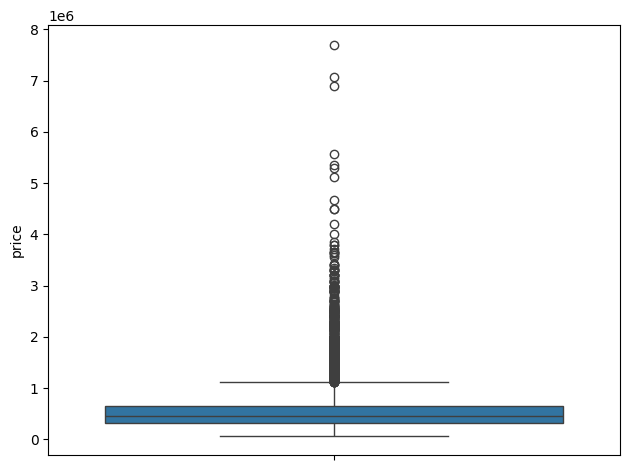

In [8]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

def boxplot(df, column):
    sns.boxplot(data=df, y=column)
    plt.tight_layout()
    plt.show()
boxplot(y_df, 'price')

Isso pode tornar interessante examinar também o logaritmo do preço:

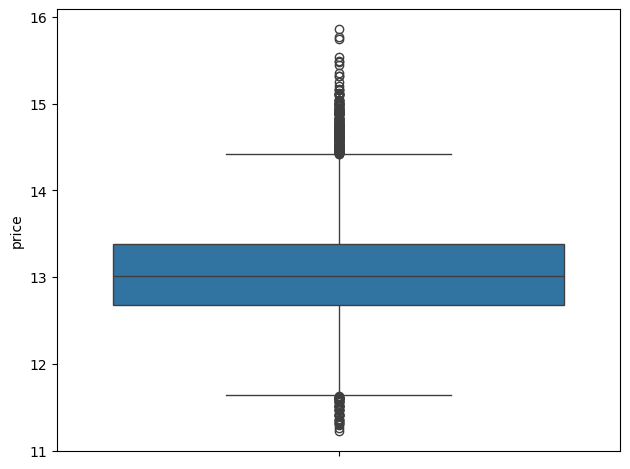

price
count 21613.000
mean     13.048
std       0.527
min      11.225
25%      12.682
50%      13.017
75%      13.377
max      15.857

In [9]:
import numpy as np 

y_log_df = np.log1p(y_df)
boxplot(y_log_df, 'price')
y_log_df.describe()

A discrepância realmente foi amenizada pela logaritimização. Vejamos como isso afeta as correlações.

#### Correlação entre fatores e saída

Vamos ver a correlação das variáveis com o preço, e com o log do preço:

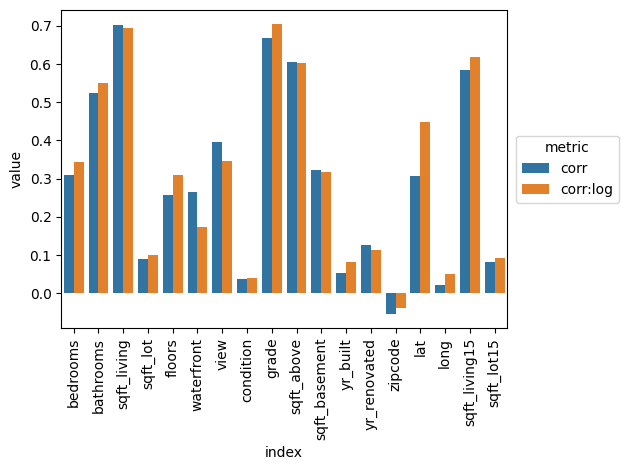

corr  corr:log
zipcode       -0.053    -0.038
long           0.022     0.050
condition      0.036     0.040
yr_built       0.054     0.081
sqft_lot15     0.082     0.092
sqft_lot       0.090     0.100
yr_renovated   0.126     0.114
floors         0.257     0.311
waterfront     0.266     0.175
lat            0.307     0.449
bedrooms       0.308     0.344
sqft_basement  0.324     0.317
view           0.397     0.347
bathrooms      0.525     0.551
sqft_living15  0.585     0.619
sqft_above     0.606     0.602
grade          0.667     0.704
sqft_living    0.702     0.695

In [10]:
X_y_corr = X.corrwith(y)
X_y_log_corr = X.corrwith(y_log_df['price'])
X_y_corr_df = DF(
  {
    'corr': X_y_corr,
    'corr:log':  X_y_log_corr
  }
)

X_y_corr_long = (
    X_y_corr_df
        .reset_index()
        .melt(
            id_vars='index',
            var_name='metric',
            value_name='value'
        )
)

sns.barplot(
    data=X_y_corr_long,
    x='index',
    y='value',
    hue='metric'
)
plt.legend(
    title='metric',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


X_y_corr_df.sort_values(by='corr')

A correlação do _log do preço_ dos imóveis  com cada um dos campos é ligeiramente melhor que a correlação com o preço original na maior parte das colunas, e quando não é, a diferença é minúscula. Tudo indica que utilizar o log do preço será mais vantajoso.

Vamos então  Com essas informações em mãos, vamos analisar os campos.

#### Campo `zipcode`

A menor correlação é o `zipcode`: -0.038. Faz sentido: é uma variavel categórica cujo suposto valor numérico nada descreve sobre o imóvel. O fato de ter uma correlação tão baixa é praticamente um bom exemplo de como o valor numérico é aleatório.

Ainda assim, ZIP codes registram partes das cidades que diferem drasticamente entre si. De fato, se ordernarmos os ZIP codes por valor médio, obtemos uma relação visualmente muito semelhante a linear em escala logarítmica:

In [11]:
zc_means = (
    q1_df.groupby("zipcode")["price"]
      .median()
      .sort_values()
)

zc_df = DF(
    zc_means
)
zc_df['position'] = range(len(zc_means))

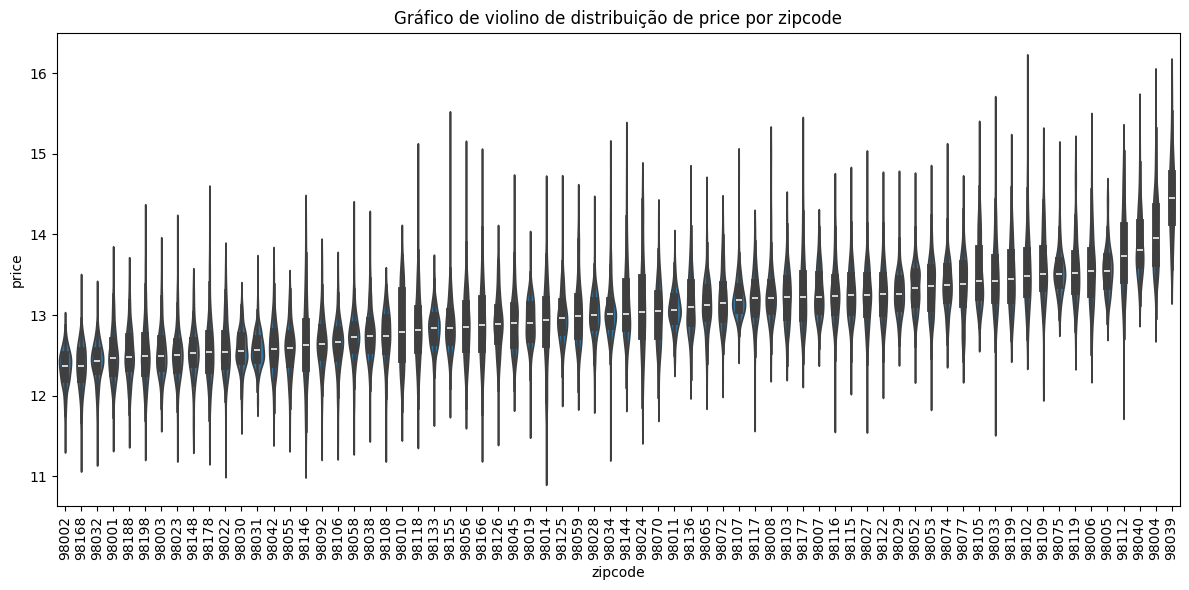

In [12]:
def violin(x, y):
    plt.figure(figsize=(12, 6))
    sns.violinplot(
        x=x,
        y=y,
        order=zc_means.index,
        inner="box",
    )
    plt.title(f'Gráfico de violino de distribuição de {y.name} por {x.name}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

violin(X['zipcode'], y_log_df['price'])

Assim, se adicionarmos coluna com o índice do ZIP code ordenado por média, e outra com o logaritmo do preço, temos valores potencialmente correlacioados:

In [13]:
X['zipcode:position'] = [
    zc_df.loc[zc]['position'].astype(int) 
        for zc in X['zipcode']
]

A correlação com o logo do preço é muito maior agora, uma das mais relevantes, o que o torna um valor muito relevante para a previsão:

In [14]:
def print_corr(X, x_column, y, y_column):
    X_y_corr = X[x_column].corr(y_log_df[y_column])
    print(
        f'Correlação entre {x_column} e {y_column}: {X_y_corr:0.3f}',
    )

print_corr(X, 'zipcode:position', y_log_df, 'price')

Correlação entre zipcode:position e price: 0.714


Naturalmente, o ZIP code, como definido originalmente, não é mais de interesse:

In [15]:
X.drop('zipcode', axis=1, inplace=True)

#### Campos `condition` e `grade`

Condition tem a correlação mais baixa após o ZIP code não ordenado. Vejamos seu histograma para ver se há algo significativo a considerar:

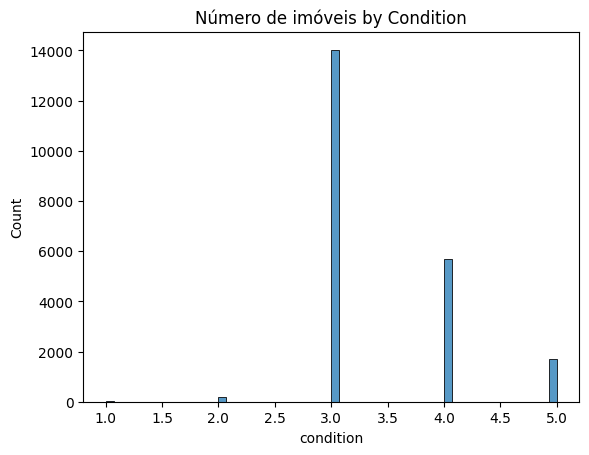

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
condition                                                                   
1                30         30           30        30      30          30   
2               172        172          172       172     172         172   
3             14031      14031        14031     14031   14031       14031   
4              5679       5679         5679      5679    5679        5679   
5              1701       1701         1701      1701    1701        1701   

            view  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
condition                                                                    
1             30     30          30             30        30            30   
2            172    172         172            172       172           172   
3          14031  14031       14031          14031     14031         14031   
4           5679   5679        5679           5679      5679          5679   
5           1701   1701        1701           1701      1701          1701   

             lat   long  sqft_living15  sqft_lot15  zipcode:position  
condition                                                             
1             30     30             30          30                30  
2            172    172            172         172               172  
3          14031  14031          14031       14031             14031  
4           5679   5679           5679        5679              5679  
5           1701   1701           1701        1701              1701

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(
    data=X,
    x='condition',
    kde=False,
    stat="count",
)

plt.title("Número de imóveis by Condition")
plt.show()

X.groupby('condition').count()

Notamos muito poucos valores nas condições 1 e 2, e um número desproporcional de valores na condição três (mais que doas as outras somadas!) Isso ajuda a explicar a baixa correlação. Poderíamos trabalhar com essa métrica usando SMOTE, por exemplo, mas como temos outras, vamos descartá-la.

In [17]:
X.drop('condition', axis=1, inplace=True)

Por outro lado, `grade` (que representa a qualidade fundacional do imóvel, ao invés do estado do acabamento) tem a mais alta correlação, depois do zipcode aptado e da área construída. Naturalmente, vamos mantê-lo.

##### `lat` e `long`

`long` (longitude) é o seguindo valor menos influente. Isso surpreeende, não só porque não segue a proverbial variação entre leste e oeste [[archplan.buffalo.edu](https://archplan.buffalo.edu/research/research-initiatives/seeitthrough/aschoolanditscity/eastwestdivide.html)] como também porque o condado varia bastante, com muito mais áreas urbanas a oeste:

<div style="max-width:400px">

![Mapa do condado de King](condado-de-king.png)

</div>

De qualquer forma, com uma correlação tão baixa, vamos descartar a longitude.

In [18]:
X.drop(['long'], axis=1, inplace=True)

Por outro lado, a latitude tem uma correlação até bem alta. Isso é surpreendente já que o condado tem meros 100 km de norte a sul [[your.kingcounty.gov](https://your.kingcounty.gov/dnrp/library/2008/kcr1973/kcr1973.pdf?utm_source=chatgpt.com)], o que por si só não deve causar grande variação em clima, e o mapa mostra certa uniformidade as várias faixas norte-sul.Talvez a latitude estreja representada (até com mais granuaridade e interpretabilidade) nos ZIP codes, mas vamos mantê-la dada sua alta correlação com o preço.

#### Campos `sqft_lot` e `sqft_lot15`

Também surpreende a baixa correlação de `sqft_lot` (0,09) e `sqt_lot15` (0,1). Suas estatisticas mostram uma variação bem grande, com desvio-padrão maior até que o valor médio e mediano. 

In [19]:
X[['sqft_lot', 'sqft_lot15']].describe()

sqft_lot  sqft_lot15
count   21613.000   21613.000
mean    15106.968   12768.456
std     41420.512   27304.180
min       520.000     651.000
25%      5040.000    5100.000
50%      7618.000    7620.000
75%     10688.000   10083.000
max   1651359.000  871200.000

No boxplot, notamos outliers bem extremos (sinais de terrenos industriais e rurais):

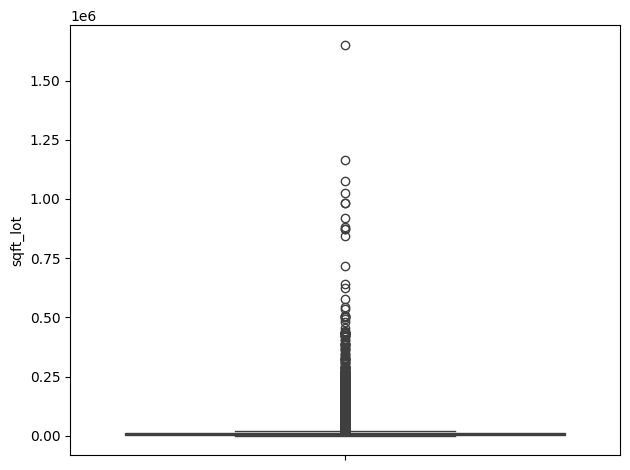

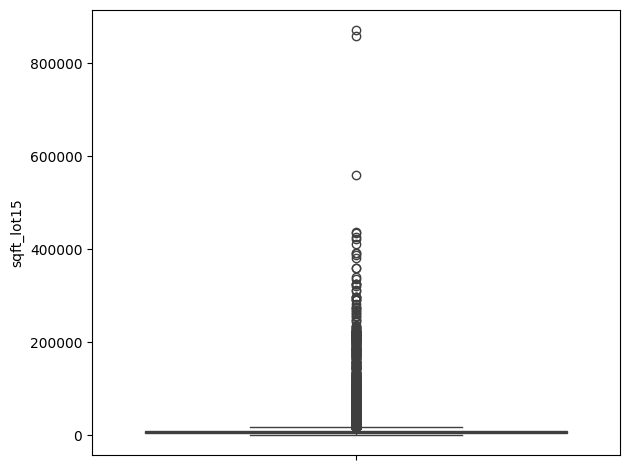

In [20]:
boxplot(X, 'sqft_lot')
boxplot(X, 'sqft_lot15')

Com esses extremos, convém observar os logaritmos dos valores:

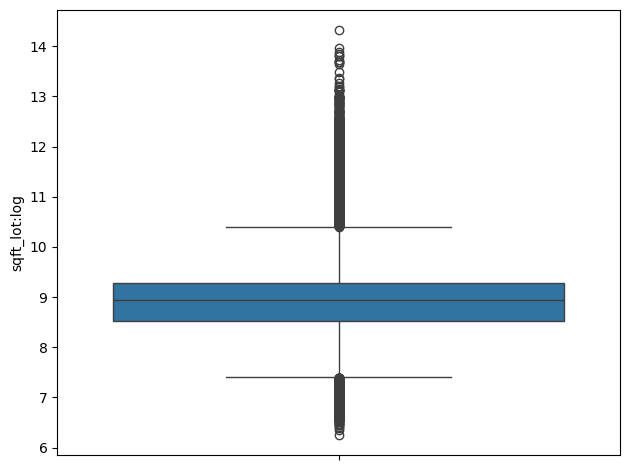

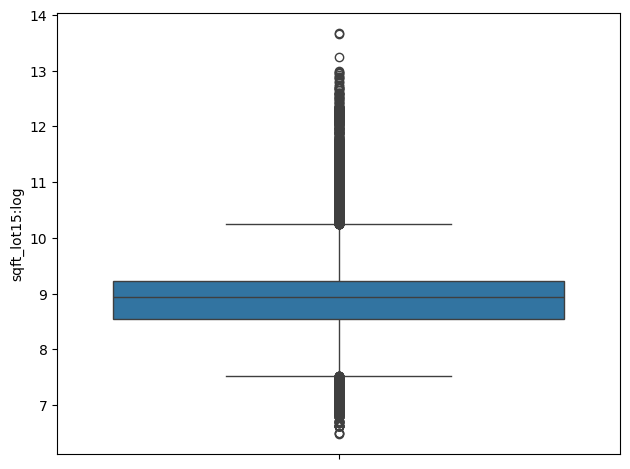

sqft_lot:log  sqft_lot15:log
count     21613.000       21613.000
mean          8.990           8.961
std           0.902           0.813
min           6.254           6.479
25%           8.525           8.537
50%           8.938           8.939
75%           9.277           9.219
max          14.317          13.678

In [21]:
X['sqft_lot:log'] = np.log(X['sqft_lot'])
X['sqft_lot15:log'] = np.log(X['sqft_lot15'])
boxplot(X, 'sqft_lot:log')
boxplot(X, 'sqft_lot15:log')
X[['sqft_lot:log', 'sqft_lot15:log']].describe()

Os valores ficaram bem mais razoáveis. Como se correlacionam com o preço?

In [22]:
print_corr(X, 'sqft_lot:log', y_log_df, 'price')
print_corr(X, 'sqft_lot15:log', y_log_df, 'price')

Correlação entre sqft_lot:log e price: 0.138
Correlação entre sqft_lot15:log e price: 0.123


A correlação melhorou bastante, então vamos descartar os valores originais. Como `sqft_lot` e `sqft_lot15` são também naturalmente correlacionados, vamos descartar `sqft_lot15:log`.

In [23]:
X.drop(['sqft_lot', 'sqft_lot15', 'sqft_lot15:log'], axis=1, inplace=True)

Também podemos explorar a linearidade entre os valores:

<Figure size 800x500 with 0 Axes>

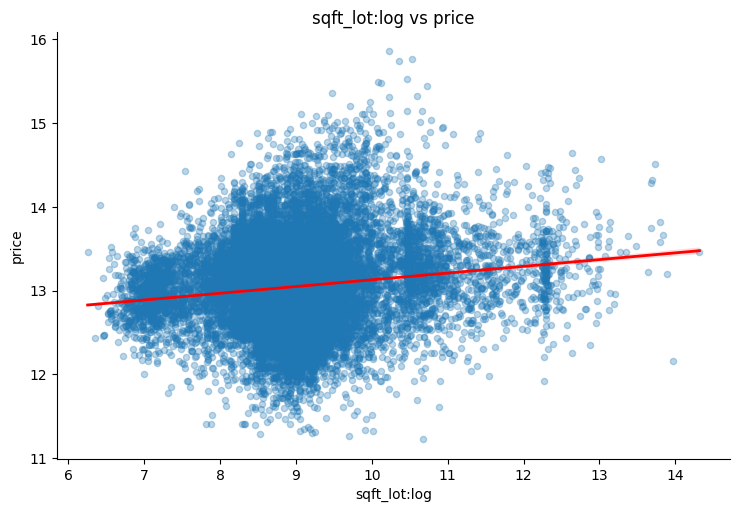

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

def scatter(x, y):
    df = DF({
        x.name: x.values,
        y.name: y.values
    })
    plt.figure(figsize=(8,5))
    #sns.regplot(data=df, x=x.name, y=y.name, alpha=0.4);
    sns.lmplot(data=df, x=x.name, y=y.name,
           height=5, aspect=1.5,
               scatter_kws={'s':20, 'alpha':0.3},
              line_kws={'color': 'red', 'linewidth': 2})
    plt.title(f'{x.name} vs {y.name}')
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    
    plt.show()

scatter(X['sqft_lot:log'], y_log_df['price'])

A maior preocupação aqui é a variação no resíduo, mas nesse gráfico ao menos a relação entre log da área e log do preço parece razoavelmente linear.

#### Campos `sqft_basement` e `sqft_above`

Como analisamos as colunas com valores de área de terreno, vamos analisar as colunas com valores de área construída. Comecemos com `sqft_basement`.

O campo `sqft_basement` tem correlação 0.317, a menor de todas os dados de áreas construídas. Vejamos as estatísticas:

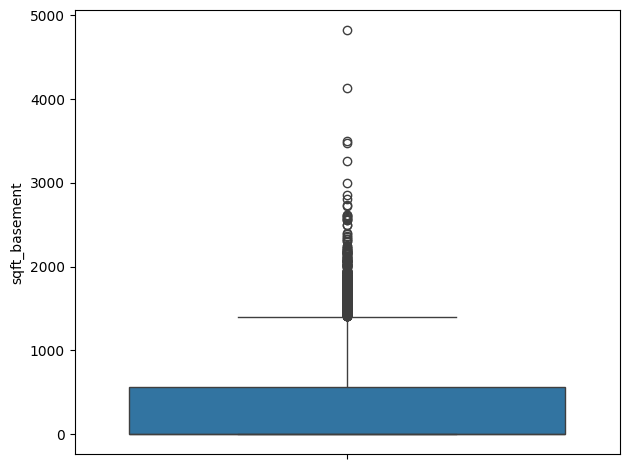

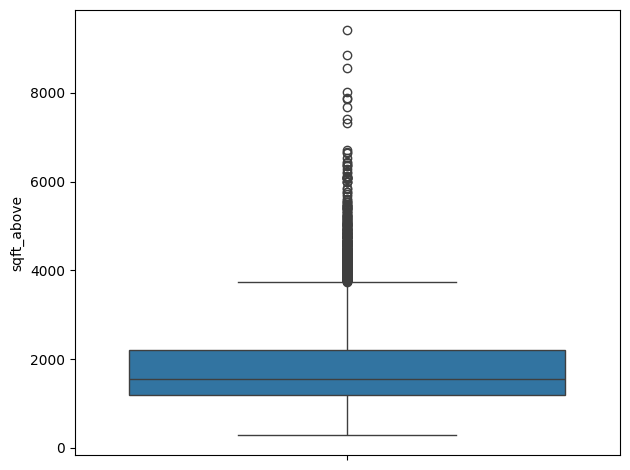

sqft_basement  sqft_above
count      21613.000   21613.000
mean         291.509    1788.391
std          442.575     828.091
min            0.000     290.000
25%            0.000    1190.000
50%            0.000    1560.000
75%          560.000    2210.000
max         4820.000    9410.000

In [25]:
boxplot(X, 'sqft_basement')
boxplot(X, 'sqft_above')
X[['sqft_basement', 'sqft_above']].describe()

Notamos que a área de porão tem uma variação muito grande, com desvio-padrão muito maior que a média. Faz sentido: a maioria imóveis simplesmente não têm porão.

Talvez a mera presença do porão seja um bom preditor? Vejamos:

In [26]:
X['basement'] = X['sqft_basement'] > 0.1
print_corr(X, 'basement', y_log_df, 'price')

Correlação entre basement e price: 0.212


Ao contrário: a presença de porão se correlaciona menos ainda com o preço.

`sqft_above`, por outro lado, tem uma correlação maior com o preço: 0,606. Não só isso, mas o valor `sqft_living` é igual a soma de `sqft_above` e `sqft_basement`. Um dos valores deve ser retirado para evitar colinearidades. Como `sqft_basement` tem a menor correlação, o removemos.

In [27]:
X.drop(['sqft_basement', 'basement'], axis=1, inplace=True)

Como fica a lienaridade entre esses valores e o preço? VEjamos:

<Figure size 800x500 with 0 Axes>

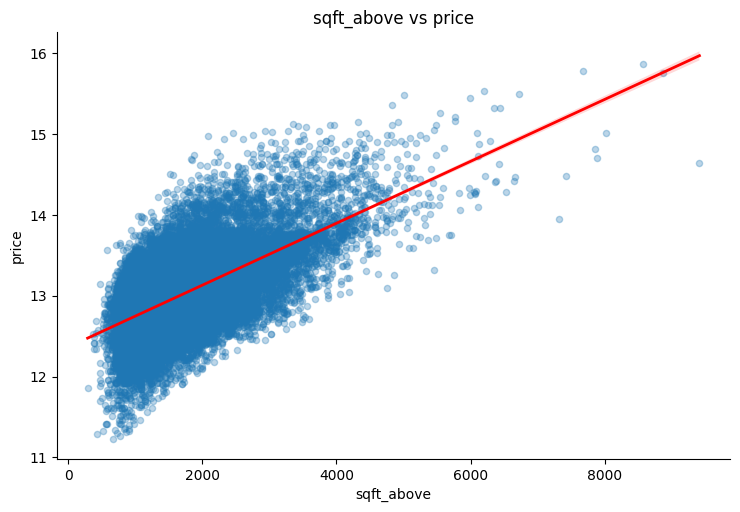

In [28]:
scatter(X['sqft_above'], y_log_df['price'])

Nada mau! Mas os outliers causaram uma certa estranheza. Vamos calcular com o log da área:

Correlação entre sqft_above:log e price: 0.586


<Figure size 800x500 with 0 Axes>

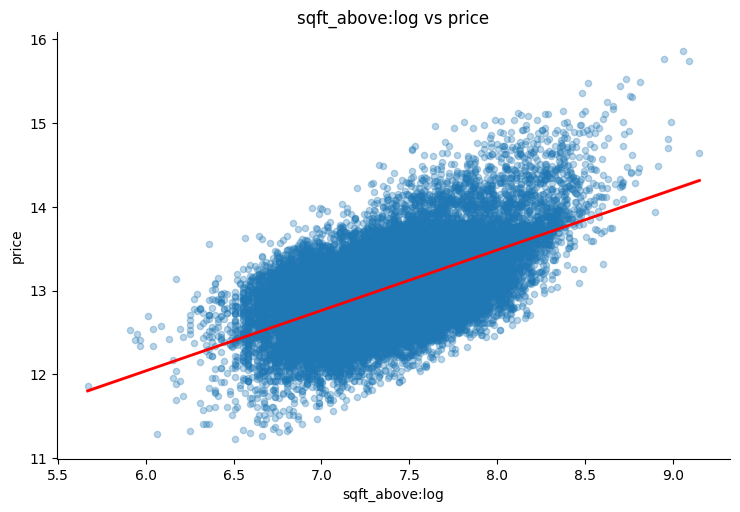

In [29]:
X['sqft_above:log'] = np.log(X['sqft_above']) 
print_corr(X, 'sqft_above:log', y_log_df, 'price')
scatter(X['sqft_above:log'], y_log_df['price'])

Conseguimos uma correlação ainda maior, e um gráfico claramente ainda mais linear. Vamos dispensar o valor bruto da área superior:

In [30]:
X.drop(['sqft_above'], axis=1, inplace=True)

#### Campos `sqft_living` e `sqft_living15`

Notamos claramente que `sqft_living` e `sqft_living15` têm grande correlação com o preço: `sqft_living15` tem correlação 0,585 e `sqft_living` tem correlação 0.702, a maior das correlações de campos não procesados. (INteressante como a área construída vale tão mais que a área do terreno).

Vejamos suas métricas:

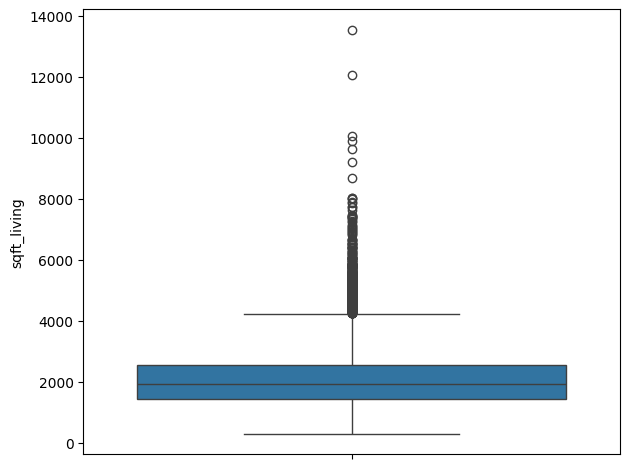

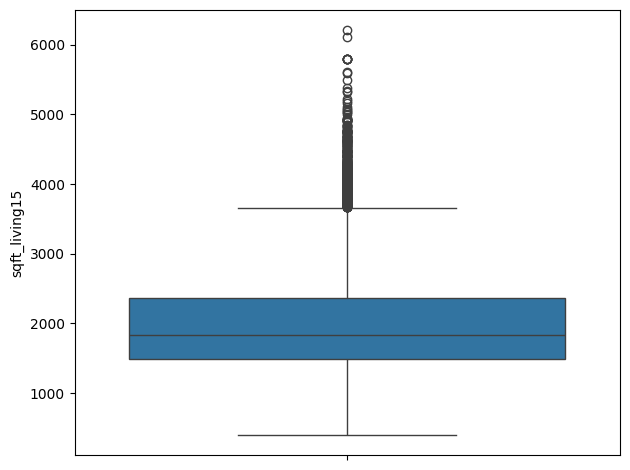

sqft_living  sqft_living15
count    21613.000      21613.000
mean      2079.900       1986.552
std        918.441        685.391
min        290.000        399.000
25%       1427.000       1490.000
50%       1910.000       1840.000
75%       2550.000       2360.000
max      13540.000       6210.000

In [31]:
boxplot(X, 'sqft_living')
boxplot(X, 'sqft_living15')
X[['sqft_living', 'sqft_living15']].describe()

A área construída, é, claramente, não só altamente correlacionada, também são valores "bem comportados", como variância razoável. Ainda há outliers, porém, então exploremos o usuo de log:

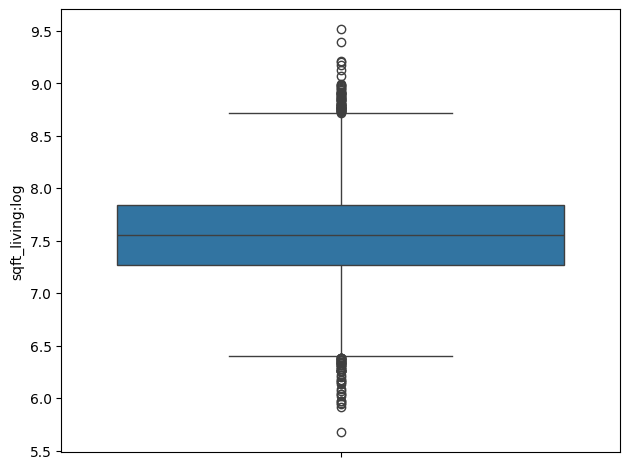

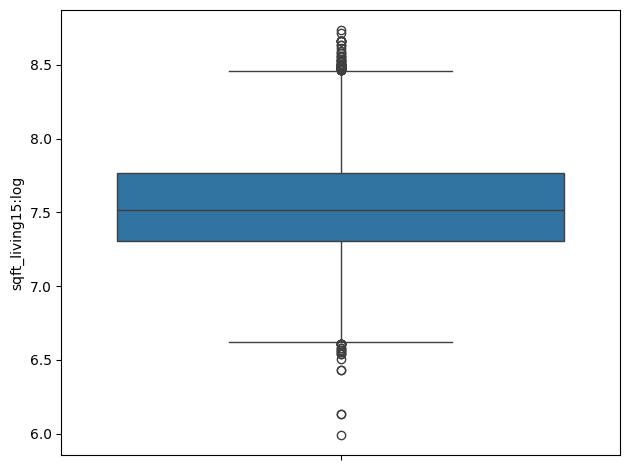

sqft_living:log  sqft_living15:log
count        21613.000          21613.000
mean             7.551              7.540
std              0.425              0.327
min              5.673              5.991
25%              7.264              7.307
50%              7.555              7.518
75%              7.844              7.767
max              9.513              8.734

In [32]:
def clc(df, column):
    '''[C]reate [L]og [C]olumn'''
    df[f'{column}:log'] = np.log1p(X[column])
clc(X, 'sqft_living')
clc(X, 'sqft_living15')
boxplot(X, 'sqft_living:log')
boxplot(X, 'sqft_living15:log')
X[['sqft_living:log', 'sqft_living15:log']].describe()

O uso do logaritmo das áreas construídas amenizou as discrepâncias. Vejamos a linearidade:

<Figure size 800x500 with 0 Axes>

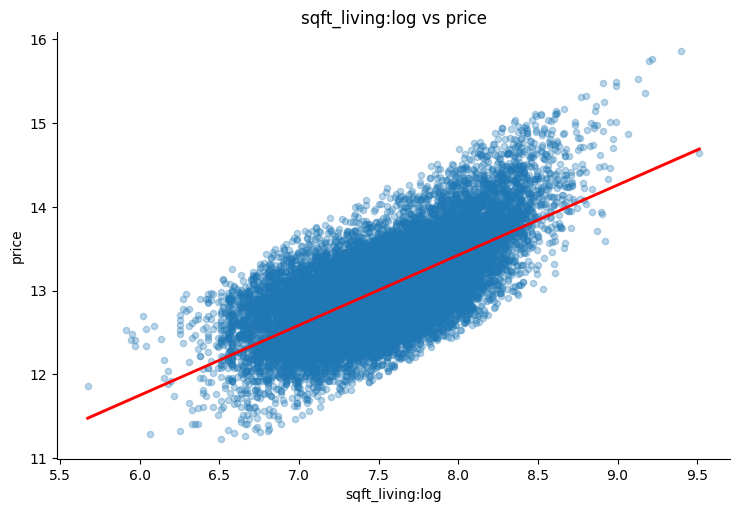

<Figure size 800x500 with 0 Axes>

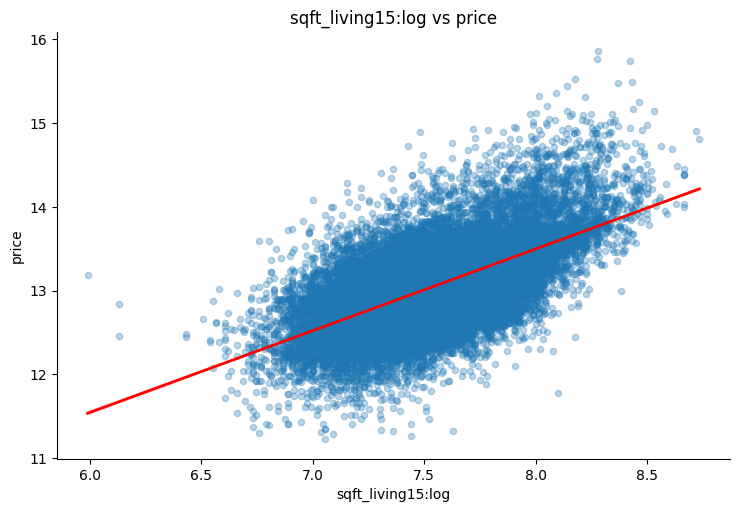

In [33]:
scatter(X['sqft_living:log'], y_log_df['price'])
scatter(X['sqft_living15:log'], y_log_df['price'])

A relação parece bem linear, inclusive com uma (aparente) distribuição normal dos resídulos. O valor do lote, não surpreendentemente, se correlacionou mais que o valor dos lotes vizinhos, então vamos descartar tanto os valores "brutos" quanto o logaritmo da média dos vizinhos:

In [34]:
X.drop(['sqft_living', 'sqft_living15', 'sqft_living15:log'], axis=1, inplace=True)

#### Campos `bathrooms` e `bedrooms`

O número de quartos e banheiros têm correlação significativa com o preço: `bedrooms` tem correlação de 0,344 enquanto `bathrooms` tem correlação de 0,551. Suas métricas são razoáveis, com médias próximas e desvio-padrão razoável, embora claramente haja vários outliers.

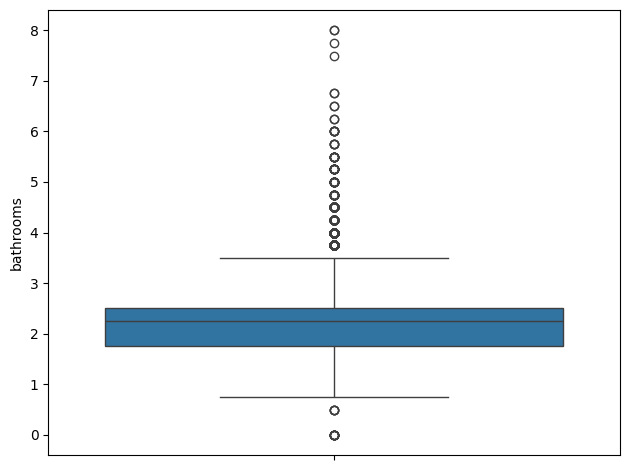

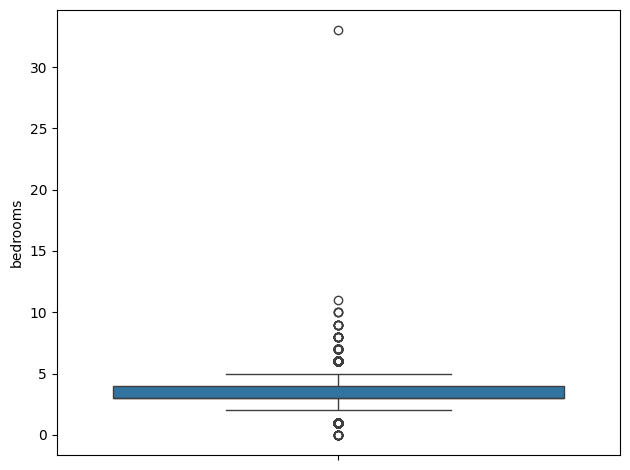

bathrooms  bedrooms
count  21613.000 21613.000
mean       2.115     3.371
std        0.770     0.930
min        0.000     0.000
25%        1.750     3.000
50%        2.250     3.000
75%        2.500     4.000
max        8.000    33.000

In [35]:
boxplot(X, 'bathrooms')
boxplot(X, 'bedrooms')
X[['bathrooms', 'bedrooms']].describe()

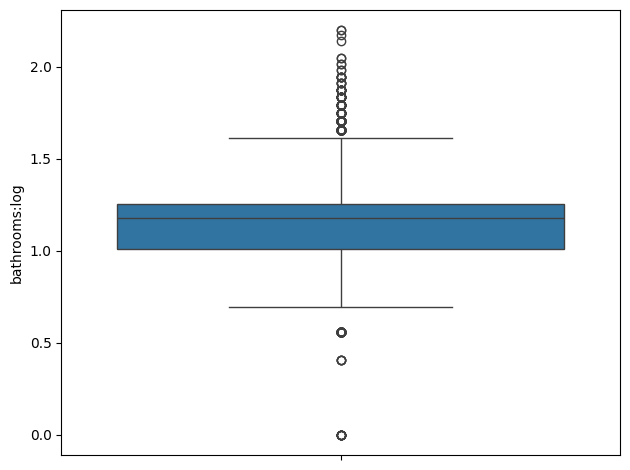

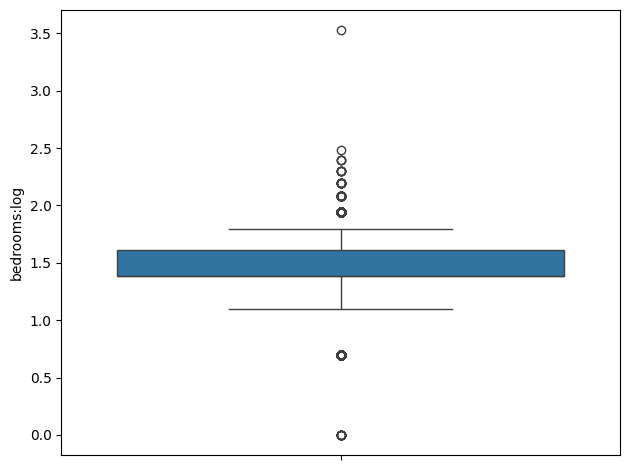

In [36]:
clc(X, 'bathrooms')
clc(X, 'bedrooms')
boxplot(X, 'bathrooms:log')
boxplot(X, 'bedrooms:log')

Como fica a correlação?

In [37]:
print_corr(X, 'bathrooms:log', y_log_df, 'price')
print_corr(X, 'bedrooms:log', y_log_df, 'price')

Correlação entre bathrooms:log e price: 0.532
Correlação entre bedrooms:log e price: 0.346


E a linearidade?

<Figure size 800x500 with 0 Axes>

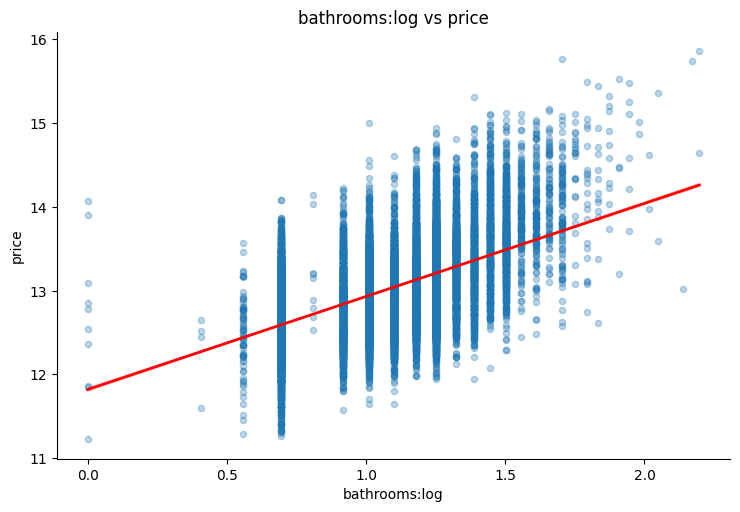

<Figure size 800x500 with 0 Axes>

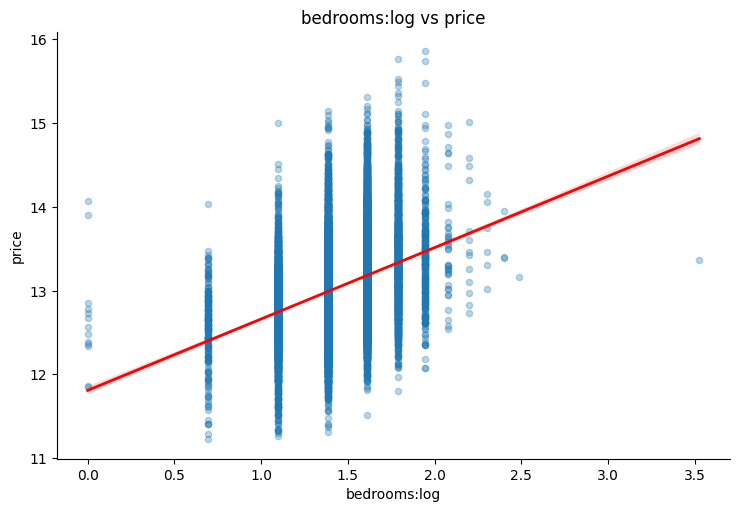

In [38]:
scatter(X['bathrooms:log'], y_log_df['price'])
scatter(X['bedrooms:log'], y_log_df['price'])

O número de quartos parece menos bem comportado, mas ainda segue uma certa linearidade.

In [39]:
X.drop(['bathrooms', 'bedrooms'], axis=1, inplace=True)

#### Campos `yr_built` e `yr_renovated`

O ano de construção de um imóvel é muito fracamente correlacionado: 0,081. 

O ano de renovação, porém, já tem uma correlação significativa, de 0,114. Vejamos suas estatísticas:

In [40]:
X[['yr_built', 'yr_renovated']].describe()

yr_built  yr_renovated
count 21613.000     21613.000
mean   1971.005        84.402
std      29.373       401.679
min    1900.000         0.000
25%    1951.000         0.000
50%    1975.000         0.000
75%    1997.000         0.000
max    2015.000      2015.000

Aqui já notamos um problema: nem todas as casas foram renovadas! Vejamos quais anos incluem renovação:

In [41]:
X[X['yr_renovated'] > 0.1]['yr_renovated'].count()

np.int64(914)

In [42]:
X[X['yr_renovated'] > 0.1]['yr_renovated'].unique()

array([1991, 2002, 2010, 1999, 1992, 2013, 1994, 1978, 2005, 2008, 2003,
       1984, 1954, 2014, 2011, 1974, 1983, 1945, 1990, 1988, 1957, 1977,
       1981, 1995, 2000, 1998, 1970, 1989, 2004, 1986, 2009, 2007, 1987,
       1973, 2006, 1985, 2001, 1980, 1971, 1979, 1997, 1950, 1969, 1948,
       2015, 1968, 2012, 1963, 1951, 1993, 1962, 1996, 1972, 1953, 1955,
       1982, 1956, 1940, 1976, 1946, 1975, 1958, 1964, 1959, 1960, 1967,
       1965, 1934, 1944])

Excluindo as casas não renovadas, há uma correlação significativa com o preço?

In [43]:
renovated = X['yr_renovated'] > 0.1
print_corr(X[renovated], 'yr_renovated', y_log_df[renovated], 'price')

Correlação entre yr_renovated e price: 0.196


Há uma correlação significativa, então não convém substituir por uma flag. Mas podemos remover o ano de construção.

In [44]:
X.drop('yr_built', axis=1, inplace=True)

#### Campo `view` e `waterfront`

Os campos que representama vista têm correlações significativas. `view`tem 0,347 e `waterfront` tem 0,175. Vamos mantê-los.

#### Correlações entre fatores

Estes são os fatores que temos no momento.

In [45]:
X.columns

Index(['floors', 'waterfront', 'view', 'grade', 'yr_renovated', 'lat',
       'zipcode:position', 'sqft_lot:log', 'sqft_above:log', 'sqft_living:log',
       'bathrooms:log', 'bedrooms:log'],
      dtype='object')

Como eles se correlacionam entre si? Vejamos:

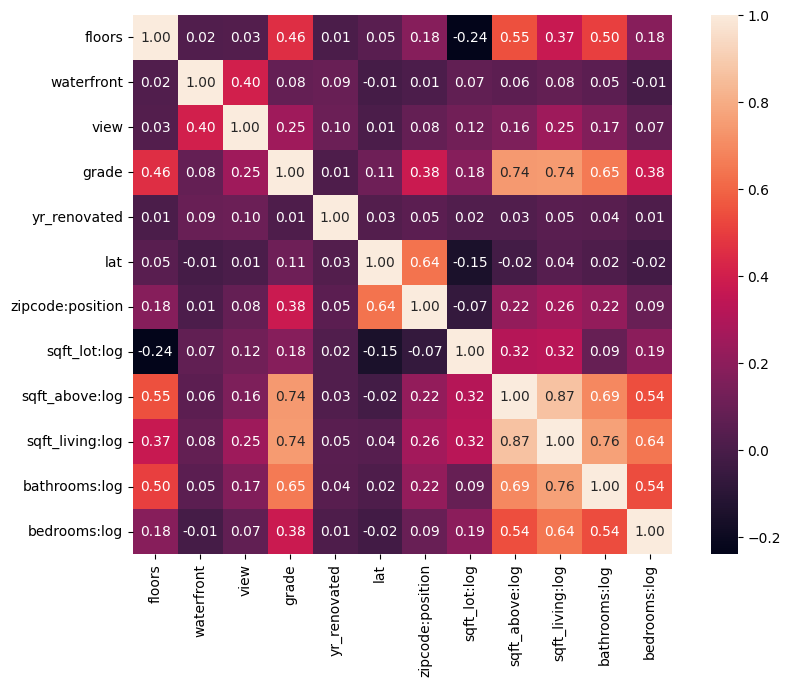

In [46]:
X_corr = X.corr(numeric_only=True)

plt.figure(figsize=(10, 7))
sns.heatmap(X_corr, annot=True, fmt=".2f", square=True)
plt.show()

Temos muitos valores com alta correlação. Podemos reduzir bastante o número de parâmetros. Vamos ver as maiores:

In [47]:
columns = X.columns
X_corr_df = DF({
    'column1': [],
    'column2': [],
    'corr:abs': []
})
for i, c1 in enumerate(columns):
    for c2 in columns[i+1:]:
        X_corr_df.loc[len(X_corr_df)] = [c1, c2, abs(X_corr[c1][c2])]

X_corr_df.sort_values(by='corr:abs', ascending=False, inplace=True)
X_corr_df[X_corr_df['corr:abs'] > 0.7]

column1          column2  corr:abs
60   sqft_above:log  sqft_living:log     0.865
63  sqft_living:log    bathrooms:log     0.764
35            grade  sqft_living:log     0.744
34            grade   sqft_above:log     0.743

Uma correlação tão alta entre área construída e área superior é esperada. Talvez valha a pena remover a área superior, dado que a mantemos para obter alguma informação sobre o porão, que, já sabemos, tem pouca influência:

In [48]:
X.drop('sqft_above:log', axis=1, inplace=True)

A relação entre área construída e banheiros também é esperada. Parece fazer sentido remover os banheiros também:

In [49]:
X.drop('bathrooms:log', axis=1, inplace=True)

Por outro lado, a relação entre `grade` e área é natural, mas são informações intríscecamente difernetes. Não vamos remover nenhuma por ora.

#### VIF

Como última validação antes da modelagem, vamos aplicar VIF para evitar colinearidades entre fatores:

In [50]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = sm.add_constant(X)

vif_df = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])]
})

vif_df

feature        VIF
0              const 209164.453
1             floors      1.534
2         waterfront      1.203
3               view      1.303
4              grade      2.790
5       yr_renovated      1.021
6                lat      1.763
7   zipcode:position      2.015
8       sqft_lot:log      1.395
9    sqft_living:log      3.831
10      bedrooms:log      1.811

Agora, todos os fatores são pouco correlacionados. Podemos treinar o modelo.

### Modelo de Regressão Linear

Com esses parâmetros, podemos treinar o nosso modelo.

In [51]:
from sklearn.model_selection import train_test_split

def train_linear_regression_model(X, y):
    (
        X_train,
        X_test,
        y_train,
        y_test
    ) = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit model
    model = sm.OLS(y_train, X_train).fit()
    return model, X_test, y_test

In [52]:
model, X_test, y_test = train_linear_regression_model(X, y_log_df['price'])

#### Performance do modelo
Vejamos sua performance:

In [53]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_linear_regression_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Metrics
    r2  = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)

    print(f"Metrics for {name}")
    print(f"  R²: {r2:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  MAE: {mae:.3f}")

In [54]:
evaluate_linear_regression_model('first try', model, X_test, y_test)

Metrics for first try
  R²: 0.830
  RMSE: 0.048
  MAE: 0.166


Esses valores são excelentes! Especialmente quando consideramos os valores máximos:

In [55]:
y_test.max()

np.float64(15.532905791436665)

Os parâmetros do modelo:

In [56]:
DF(model.params)

0
const            -14.371
floors            -0.012
waterfront         0.401
view               0.093
grade              0.100
yr_renovated       0.000
lat                0.481
zipcode:position   0.012
sqft_lot:log       0.004
sqft_living:log    0.440
bedrooms:log      -0.034

### Ajuste dos modelo

#### One-hot enconding  para ZIP code

Ainda assim, podemos tentar melhorar o modelo. Por exemplo, o truque de ordenar os ZIP codes "funcionou" e nos salvou um bom número de parâmetros, mas e se utilizássemos one-hot encoding?

In [57]:
X_1he_zip = X.copy()
X_1he_zip.drop('zipcode:position', axis=1, inplace=True)
X_1he_zip['zipcode'] = q1_df['zipcode']
X_1he_zip = pd.get_dummies(X_1he_zip, columns=['zipcode'], drop_first=True, dtype=int)

In [58]:
model_1he_zip, X_test, y_test = train_linear_regression_model(X_1he_zip, y_log_df['price'])
evaluate_linear_regression_model('One-hot encoded ZIP code', model_1he_zip, X_test, y_test)

Metrics for One-hot encoded ZIP code
  R²: 0.878
  RMSE: 0.035
  MAE: 0.137


A melhora foi considerável, inegavelmente, mesmo que ao custo de muito mais colunas:

In [59]:
__| X.columns | len | print  |__
__| X_1he_zip.columns | len | print  |__

11
79


#### Adicionando longitude

Antes, removemos `long` porque havia pouca correlação, e queríamos reduzir o número de parâmetros. Se o adicionarmos de volta, haverá melhora? Vejamos.

In [60]:
X_long = X_1he_zip.copy()
X_long['long'] = q1_df['long']

In [61]:
model_long, X_test, y_test = train_linear_regression_model(X_long, y_log_df['price'])
evaluate_linear_regression_model('model with longitude', model_long, X_test, y_test)

Metrics for model with longitude
  R²: 0.878
  RMSE: 0.035
  MAE: 0.137


Não houve melhora significativa. Não surpeende, mas levanta outra questão: se removermos tanto latitude quanto longitude do modelo com ZIP code codificado, qual seria o resultado?

#### Removendo coordenadas

Observemos primeiramente os parâmetros:

In [62]:
DF(model_long.params[[not s.startswith('zipcode_') for s in model_long.params.index]])

0
const           -73.718
floors            0.008
waterfront        0.472
view              0.068
grade             0.108
yr_renovated      0.000
lat               0.524
sqft_lot:log      0.073
sqft_living:log   0.462
bedrooms:log     -0.042
long             -0.462

Latitude e longitude ainda parecem bem relevantes! Treinemos um modelo para ver como funciona sem as coordenadas:

In [63]:
X_no_coords = X_1he_zip.copy()
X_no_coords.drop('lat', axis=1, inplace=True)

In [64]:
model_no_coords, X_test, y_test = train_linear_regression_model(X_no_coords, y_log_df['price'])
evaluate_linear_regression_model('model with no coordinates', model_no_coords, X_test, y_test)

Metrics for model with no coordinates
  R²: 0.878
  RMSE: 0.035
  MAE: 0.137


Muito surpreendentemente, remover latitude e longitude simplesmente não teve efeito perceptível nas métricas! Se, por um lado, podemos esperar algo assim dado que ZIP codes encodam parte dessa informação, inclusive de maneira muito mais granular e sem as mudanças bruscas/não-lineares que se espera de coordenadas, é curioso ver que, parâmetros que atnes estavam tão relevantes, agora não são.

#### Removendo parâmetros com coeficientes minúsculos

Além disso, nota-se que o número de andares e o ano da renovação ambos têm coeficientes muito baixos. Faria diferença removê-los?

In [65]:
X_no_floor_yr = X_no_coords.copy()
X_no_floor_yr.drop(['floors', 'yr_renovated'], axis=1, inplace=True)

In [66]:
model_no_floor_yr, X_test, y_test = train_linear_regression_model(X_no_floor_yr, y_log_df['price'])
evaluate_linear_regression_model('model with no floor/renovation year', model_no_floor_yr, X_test, y_test)

Metrics for model with no floor/renovation year
  R²: 0.877
  RMSE: 0.035
  MAE: 0.138


Houve um aumento minúsculo dos erros, mas isso mostra como mesmo esses fatores tão pequenos podem ser relevantes. Vamos mantê-los.

#### Adicionando banheiros

Anteriormente, removemos os banheiros. E se o adissionássemos novamente? Eles são usualmente um sinal de qualidade da casa.

In [67]:
X_bathrooms = X_no_coords.copy()
X_bathrooms['bathrooms:log'] = np.log1p(q1_df['bathrooms'])

In [68]:
model_bathrooms, X_test, y_test = train_linear_regression_model(X_bathrooms, y_log_df['price'])
evaluate_linear_regression_model('model with bathrooms', model_bathrooms, X_test, y_test)

Metrics for model with bathrooms
  R²: 0.878
  RMSE: 0.035
  MAE: 0.137


Claramente, pouco afetou o resultado. Podemos experimentar mais, mas o modelo com ZIP code em one-hot encoding mas sem coordenadas é o melhor até o momento.

Vamos analisá-lo.

### Interpretação de resultados

Novamente, estes são os coeficientes dos parâmetros do modelo sem coordenadas (sem contar as flags dos ZIP codes):

In [69]:
DF(model_no_coords.params[[not s.startswith('zipcode_') for s in model_no_coords.params.index]])

0
const            7.618
floors           0.006
waterfront       0.473
view             0.068
grade            0.108
yr_renovated     0.000
sqft_lot:log     0.071
sqft_living:log  0.464
bedrooms:log    -0.042

É interessante notar como o coeficiente da constante mudou drasticamente, de -14,4 no mdelo original, para 7,6! Faz sentido: como adicionamos ZIP code codificado com one-hot encoding, temos mais parâmetros para somar, logo nosso baseline deve ser maior. 

Antes de explorarmos os ZIP codes, notemos como o número de quartos tem um efeito negativo! É importante lembrar que este parâmetro é um log, então isso não significa que ter mais quartos vai necessariamente reduzir o preço, mas provavelmente o parâmetro se torna bem menos relevante, com um coeficiente menor que 1. Ainda assim, um efeito inesperado.

#### Efeito de ZIP code

Vejamos os ZIP codes:

In [79]:
zc_coefs = DF(model_no_coords.params[[s.startswith('zipcode_') for s in model_no_coords.params.index]]).sort_values(by=0)
zc_coefs[:10]

0
zipcode_98023 -0.027
zipcode_98032 -0.022
zipcode_98003  0.007
zipcode_98002  0.024
zipcode_98092  0.033
zipcode_98022  0.055
zipcode_98030  0.055
zipcode_98198  0.065
zipcode_98168  0.074
zipcode_98042  0.080

In [81]:
zc_coefs[59:]

0
zipcode_98107 0.887
zipcode_98199 0.888
zipcode_98040 0.928
zipcode_98105 1.006
zipcode_98119 1.009
zipcode_98102 1.022
zipcode_98109 1.046
zipcode_98112 1.110
zipcode_98004 1.164
zipcode_98039 1.378

Os coeficientes dos ZIP codes ainda são bem pequenos. Como é possível, então, que valores tão grandes quanto o preço de imóveis seja previsto a partir desses coeficientes? Para começar, estamos modelando o logaritmo do preço dos imóveis, não o preço dos imóveis. Considerando isos, os ZIP codes na verdade têm uma influência bem dominadora, especialmente considerando regiões mais valisas.

Depois dos ZIP codes, a maior influência é a área construída, `sqft_living:log`. Claramente, o tamanho do terreno não é tão relevante (ou melhor, o efeito varia muito dependendo da região, talvez fosse mais efetivo junto com os ZIP codes). Os outros fatores são relevantes, mas têm certa correlação com o tamanho da área construída de qualquer forma.

### Aplicações

Vejamos os valores em números "reais" (valores em dólares):

In [93]:
model_no_coords, X_test, y_test = train_linear_regression_model(X_no_coords, y_log_df['price'])

y_pred = model_no_coords.predict(X_test)
y_test = np.exp(y_test)-1
y_pred = np.exp(y_pred)-1

# Metrics
r2  = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)

print(f"Metrics for 'real' price prediction with no-coords model")
print(f"  R²: {r2:.3f}")
print(f"  RMSE: {rmse:.3f}")
print(f"  MAE: {mae:.3f}")
print(f"  mean(y) / sd(y): {y.mean()} / {y.std()}")

Metrics for 'real' price prediction with no-coords model
  R²: 0.864
  RMSE: 20496040251.883
  MAE: 78493.135
  mean(y) / sd(y): 540088.1417665294 / 367127.1964826998


Nosso modelo possui um erro absoluto médio de aproximadamente US$ 78 mil quando aplicado. Considerando que os valores têm média de US$ 540 mil e variãncia de US$ 367 mil, esse erro é bem razoável!

Uma utilidade possível seria definir sugestões de preços iniciais para ofertas. Outra seria encontrar imóveis que, segundo o modelo, estariam subvalorizados. Poderíamos fazer isso com nossa base de testes, por sinal:

In [99]:
pred_df = DF({
    'predicted': y_pred,
    'real': y_test,
    'diff': y_pred-y_test
})
pred_df[pred_df['diff'] > 0].head()

predicted        real       diff
4106  1265597.268 1038000.000 227597.268
1227   267791.790  211000.000  56791.790
20164  420491.673  384500.000  35991.673
13342  445331.966  385000.000  60331.966
15468  264598.142  175000.000  89598.142

Se o modelo se provar correto, a arbitragem só nos cinco imóveis mais subvalorizados daria quase US$ 500 mil de lucro!

Naturalmente, essa não é uma fórmula a ser seguida cegamente, mas pode apontar possíveis oportunidades a serem availadas.

In [ ]:
# Sandbox

## Questão 2

> Esta questão aborda a aplicação prática de um problema de Ciência de Dados utilizando Machine Learning. O objetivo é prever se os indivíduos irão cancelar suas reservas em uma rede de hotéis, utilizando o conjunto de dados Hotel Booking Demand. Siga os passos abaixo para desenvolver sua solução.

### Análise Descritiva dos Dados

Carregando dados:

In [2]:
from brandedpipes import __
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "hotel_bookings.csv"

# Load the latest version
q2_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "jessemostipak/hotel-booking-demand",
  file_path,
)

q2_df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

    agent company days_in_waiting_list customer_type    adr  \
0     NaN     NaN                    0     Transient  0.000   
1     NaN     NaN                    0     Transient  0.000   
2     NaN     NaN                    0     Transient 75.000   
3 304.000     NaN                    0     Transient 75.000   
4 240.000     NaN                    0     Transient 98.000   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   
3                            0                          0           Check-Out   
4                            0                          1           Check-Out   

  reservation_status_date  
0              2015-07-01  
1              2015-07-01  
2              2015-07-02  
3              2015-07-02  
4              2015-07-03  

[5 rows x 32 columns]

Separando partes:

In [3]:
X = q2_df.drop('is_canceled', axis=1)
y = q2_df[['is_canceled']]

#### Sumários

In [4]:
q2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
q2_df.describe().transpose()

count     mean     std      min      25%  \
is_canceled                    119390.000    0.370   0.483    0.000    0.000   
lead_time                      119390.000  104.011 106.863    0.000   18.000   
arrival_date_year              119390.000 2016.157   0.707 2015.000 2016.000   
arrival_date_week_number       119390.000   27.165  13.605    1.000   16.000   
arrival_date_day_of_month      119390.000   15.798   8.781    1.000    8.000   
stays_in_weekend_nights        119390.000    0.928   0.999    0.000    0.000   
stays_in_week_nights           119390.000    2.500   1.908    0.000    1.000   
adults                         119390.000    1.856   0.579    0.000    2.000   
children                       119386.000    0.104   0.399    0.000    0.000   
babies                         119390.000    0.008   0.097    0.000    0.000   
is_repeated_guest              119390.000    0.032   0.176    0.000    0.000   
previous_cancellations         119390.000    0.087   0.844    0.000    0.000   
previous_bookings_not_canceled 119390.000    0.137   1.497    0.000    0.000   
booking_changes                119390.000    0.221   0.652    0.000    0.000   
agent                          103050.000   86.693 110.775    1.000    9.000   
company                          6797.000  189.267 131.655    6.000   62.000   
days_in_waiting_list           119390.000    2.321  17.595    0.000    0.000   
adr                            119390.000  101.831  50.536   -6.380   69.290   
required_car_parking_spaces    119390.000    0.063   0.245    0.000    0.000   
total_of_special_requests      119390.000    0.571   0.793    0.000    0.000   

                                    50%      75%      max  
is_canceled                       0.000    1.000    1.000  
lead_time                        69.000  160.000  737.000  
arrival_date_year              2016.000 2017.000 2017.000  
arrival_date_week_number         28.000   38.000   53.000  
arrival_date_day_of_month        16.000   23.000   31.000  
stays_in_weekend_nights           1.000    2.000   19.000  
stays_in_week_nights              2.000    3.000   50.000  
adults                            2.000    2.000   55.000  
children                          0.000    0.000   10.000  
babies                            0.000    0.000   10.000  
is_repeated_guest                 0.000    0.000    1.000  
previous_cancellations            0.000    0.000   26.000  
previous_bookings_not_canceled    0.000    0.000   72.000  
booking_changes                   0.000    0.000   21.000  
agent                            14.000  229.000  535.000  
company                         179.000  270.000  543.000  
days_in_waiting_list              0.000    0.000  391.000  
adr                              94.575  126.000 5400.000  
required_car_parking_spaces       0.000    0.000    8.000  
total_of_special_requests         0.000    1.000    5.000

#### Colunas com null/NaN

In [6]:
nan_df = gnanc(q2_df)
nan_df[nan_df['hasNaN']]

column  hasNaN    NaNs
10  children    True       4
13   country    True     488
23     agent    True   16340
24   company    True  112593

#### Total de registros:

In [7]:
len(q2_df)

119390

(A maior parte dos registros não têm empresa.)

#### Variáveis categóricas

In [8]:
buckets = [
    'hotel', 'meal', 'market_segment', 'distribution_channel',
    'deposit_type', 'customer_type', 'reservation_status',
    'reserved_room_type', 'assigned_room_type',
    'country', 'company', 'agent'
]

buckets_df = DF({
    'dtype': [q2_df[b].dtype for b in buckets],
    'count': [q2_df[b].unique().size for b in buckets]
}, index=buckets)
buckets_df

dtype  count
hotel                  object      2
meal                   object      5
market_segment         object      8
distribution_channel   object      5
deposit_type           object      3
customer_type          object      4
reservation_status     object      3
reserved_room_type     object     10
assigned_room_type     object     12
country                object    178
company               float64    353
agent                 float64    334

Algumas categorias são muito grandes, vamos restringir:

In [9]:
categories_df = buckets_df[buckets_df['count'] <= 12]

`children` deve ser inteiro. Único empecilho são meros 4 linhas com valor `nan` para children, quase certamente erros. Vamos converter para zero:

In [10]:
X['children'] = X['children'].fillna(0).astype(int, copy=False)

#### Gráficos

##### Cancelamentos e não cancelamentos:

<Axes: xlabel='is_canceled', ylabel='count'>

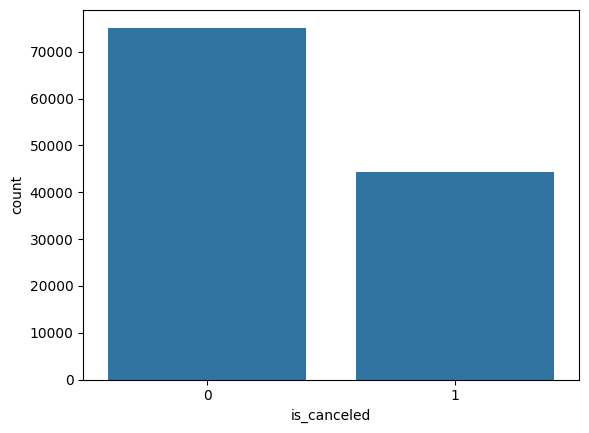

In [11]:
sns.countplot(data=q2_df, x="is_canceled")

Há uma diferença significativa, mas não parece tão impactante. Não vamos balancear a base.

#### Variáveis categóricas:

In [12]:
def countplots(df, columns, hue='is_canceled', per_row=3, width=5, height=4):
    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        sns.countplot(data=df, x=col, ax=ax, hue=hue)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

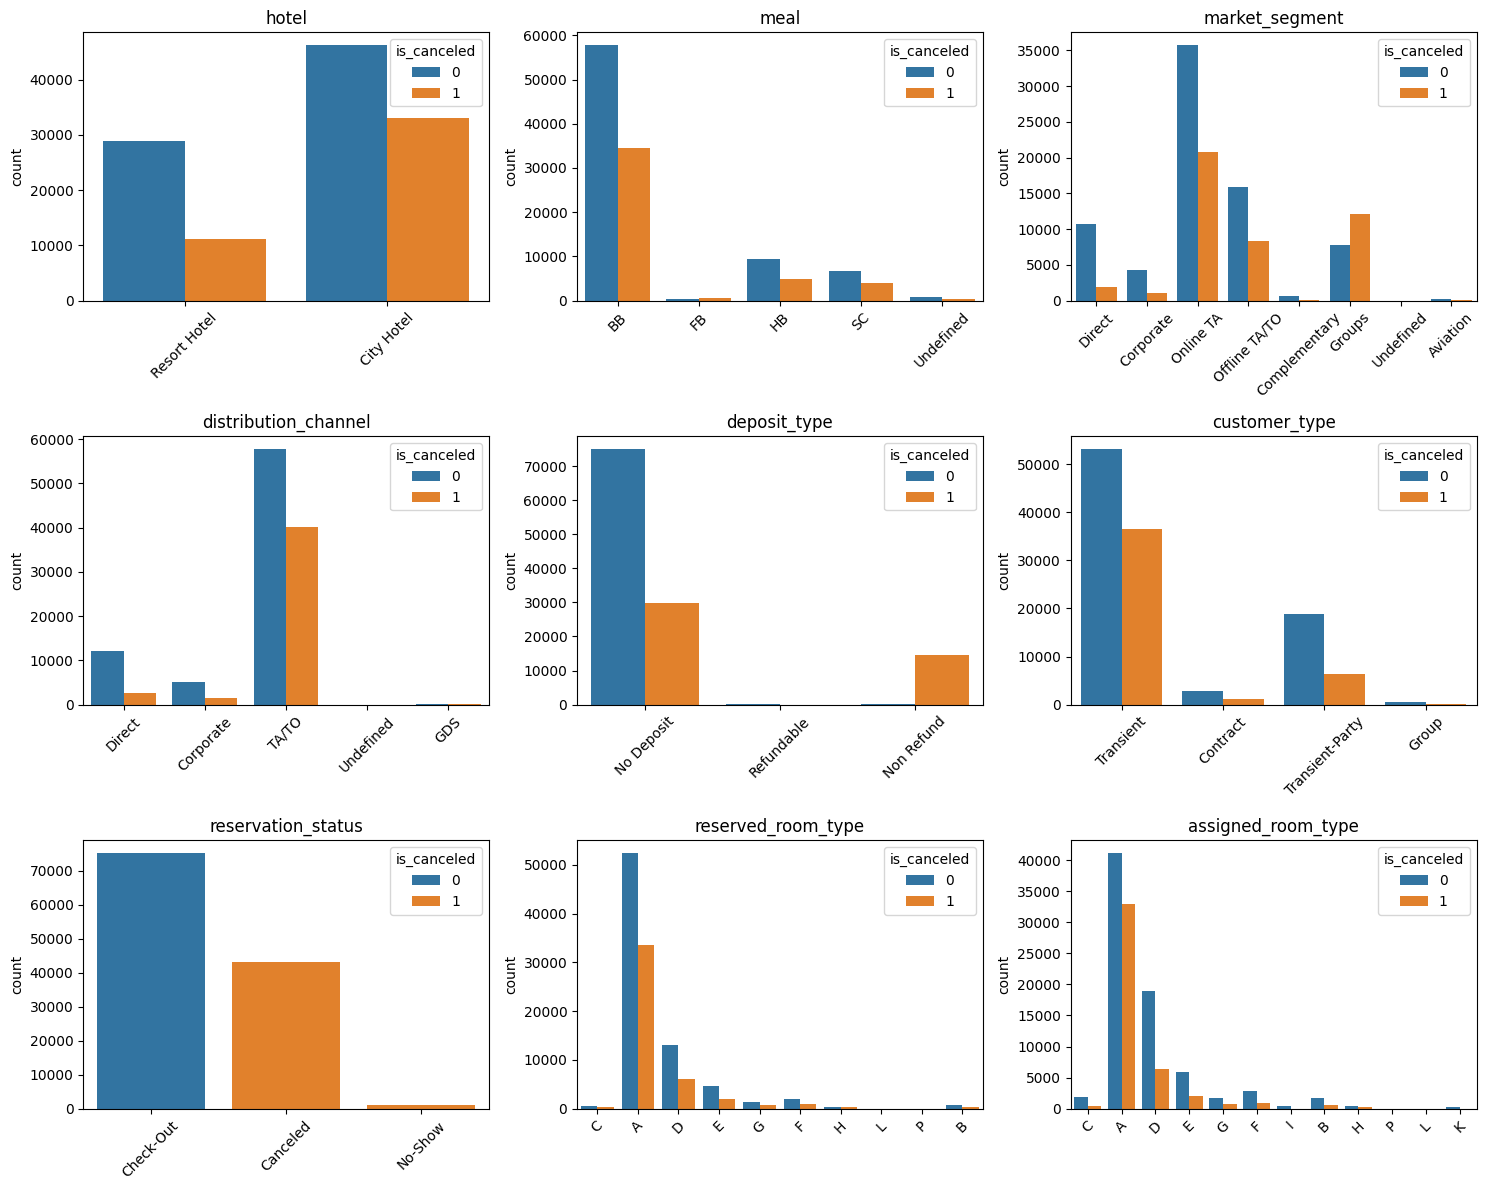

In [13]:
countplots(q2_df, categories_df.index)

`reservation_status` tem basicamente a mesma informação de `is_canceled`, e assim como `is_canceled`, só temos essa informação tarde demais, então vamos removê-lo.

In [14]:
def drop(df, *columns):
    df.drop(list(columns), axis=1, inplace=True)

drop(X, 'reservation_status', 'reservation_status_date')

categories_df= categories_df.drop(index='reservation_status')

#### Boxplot de variáveis numéricas

In [15]:
def boxplots(df, columns, per_row=3, width=5, height=4):
    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        sns.boxplot(data=df, y=col, ax=ax)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

numeric = [
    'lead_time',  'adults', 'children', 'babies', 'stays_in_weekend_nights',
    'stays_in_week_nights', 'required_car_parking_spaces',
    'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes', 'days_in_waiting_list', 'adr','total_of_special_requests'
]

numbers_df = DF({
    'dtype': [q2_df[b].dtype for b in numeric],
    'count': [q2_df[b].unique().size for b in numeric]
}, index=numeric)
numbers_df

dtype  count
lead_time                         int64    479
adults                            int64     14
children                        float64      6
babies                            int64      5
stays_in_weekend_nights           int64     17
stays_in_week_nights              int64     35
required_car_parking_spaces       int64      5
previous_cancellations            int64     15
previous_bookings_not_canceled    int64     73
booking_changes                   int64     21
days_in_waiting_list              int64    128
adr                             float64   8879
total_of_special_requests         int64      6

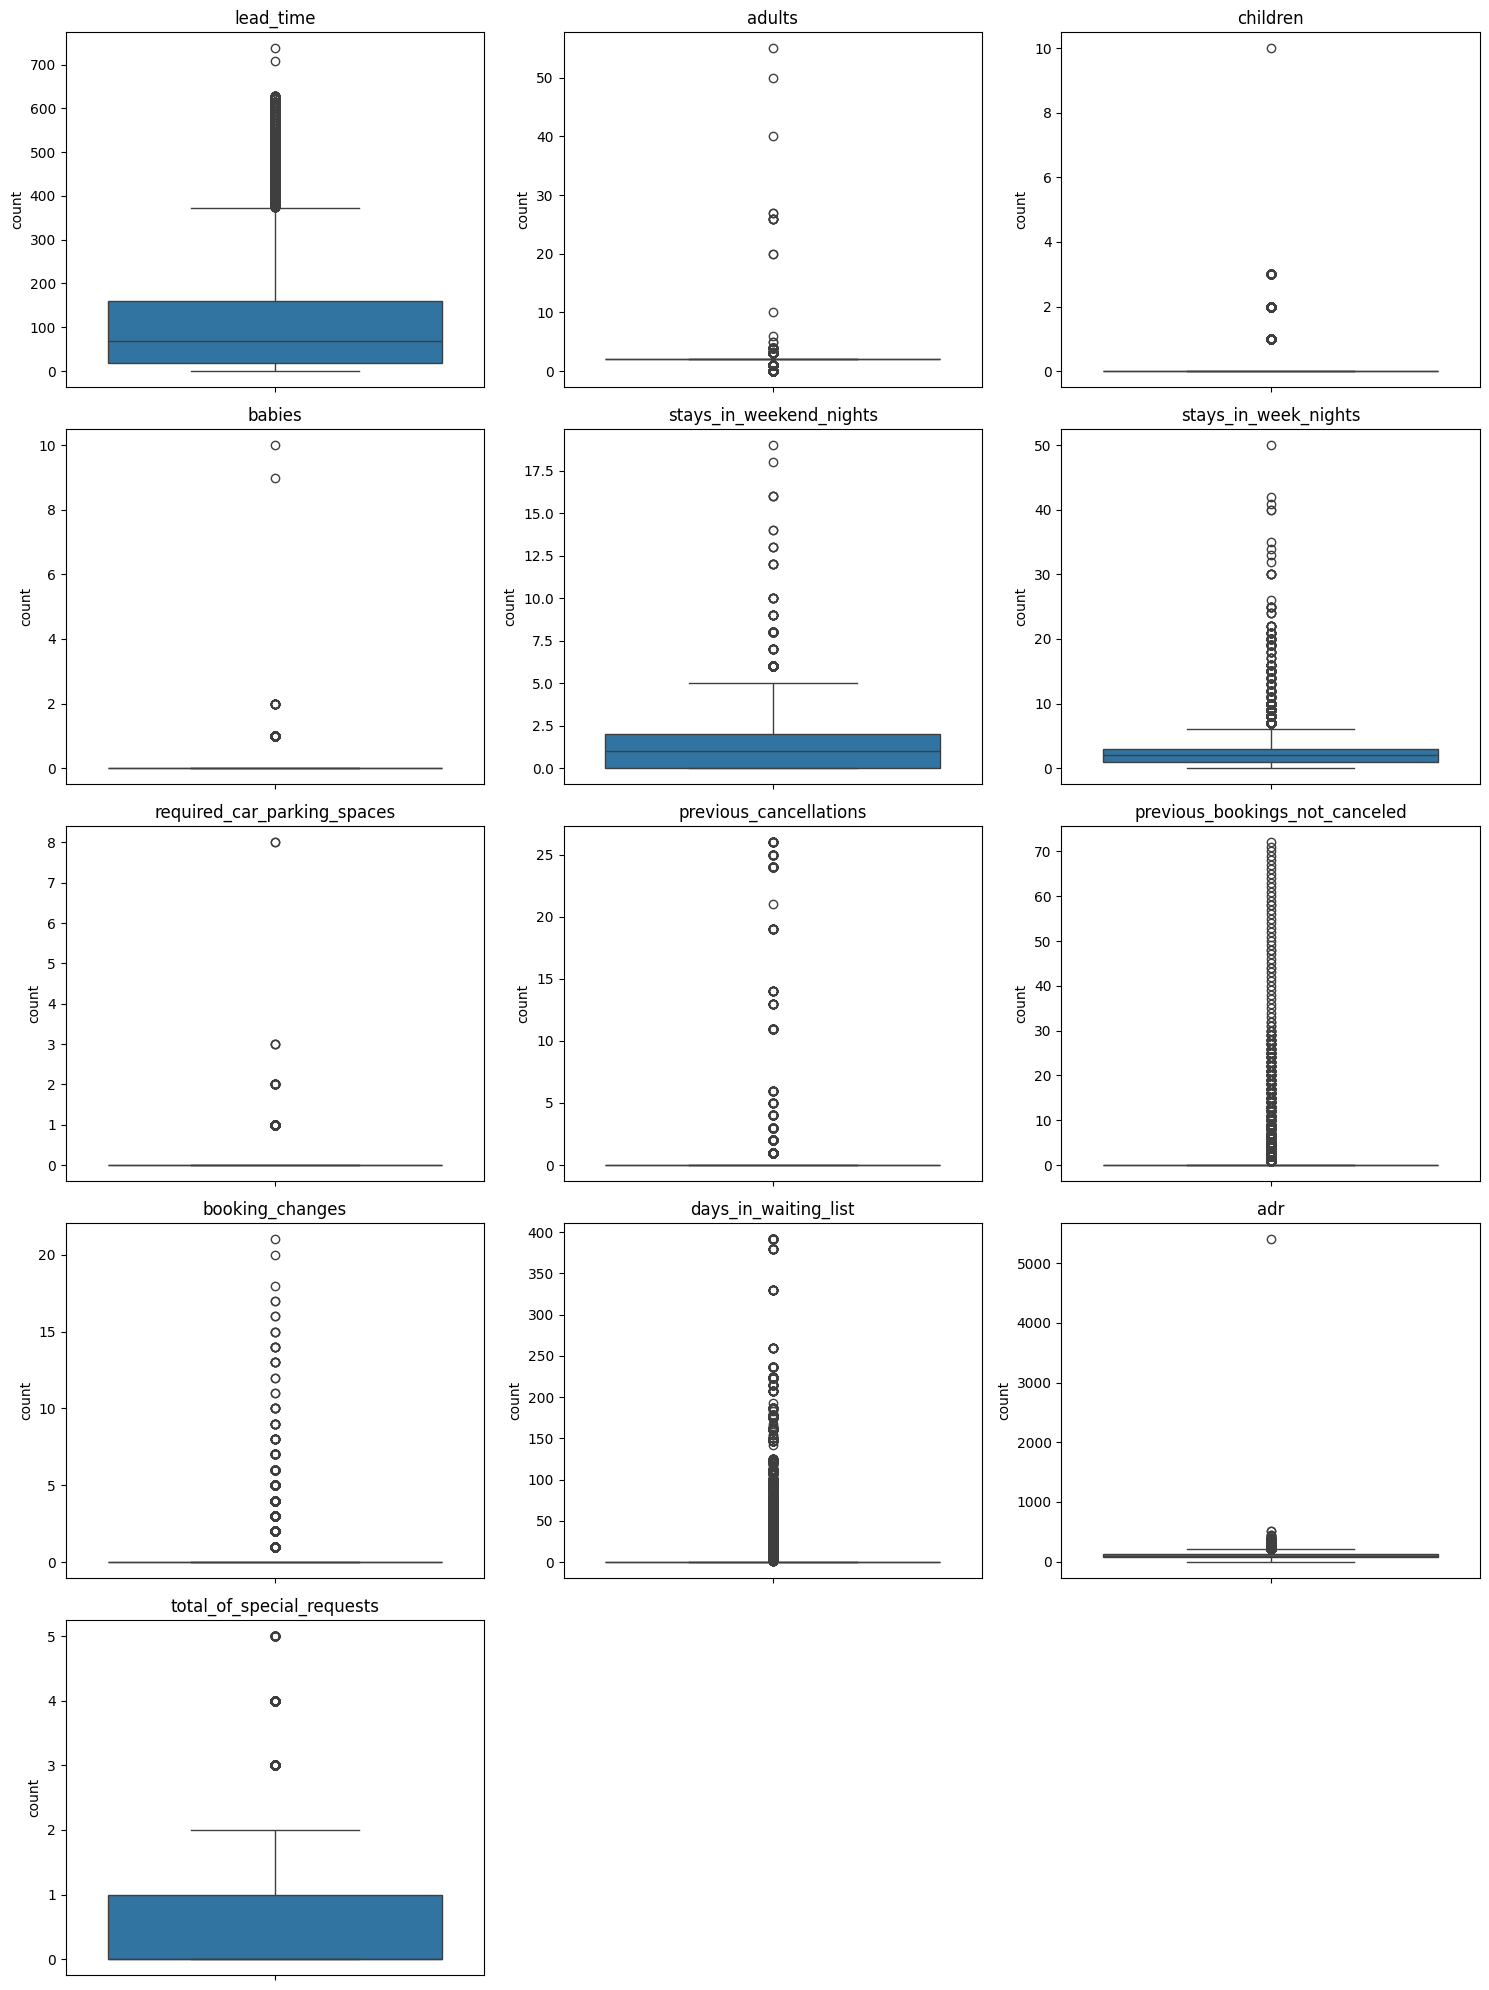

In [16]:
boxplots(q2_df, numbers_df.index)

ADR (que é aproximadamente gasto por noite) tem um outlier absurdo:

In [17]:
q2_df.sort_values(by='adr', ascending=False).head()[['hotel', 'is_canceled', 'adr']]

hotel  is_canceled      adr
48515     City Hotel            1 5400.000
111403    City Hotel            0  510.000
15083   Resort Hotel            0  508.000
103912    City Hotel            0  451.500
13142   Resort Hotel            1  450.000

Este valor é tão desproporcional e único, que vamos removê-lo da base.

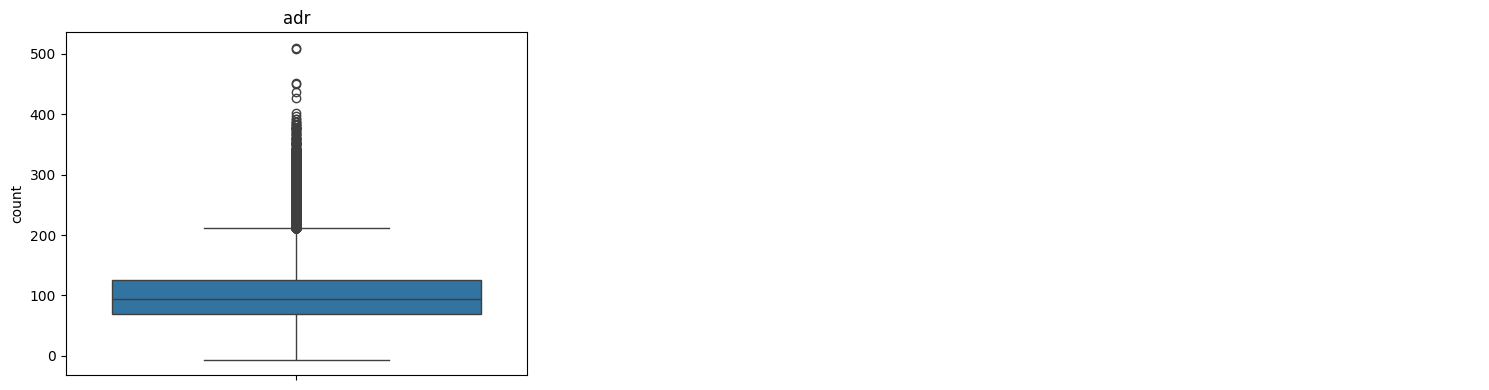

In [18]:
outlier = X[X['adr'] > 2000].index
X = X.drop(outlier)
y = y.drop(outlier)
boxplots(X, ['adr'])

Todos são muito _skewed_. Poderíamos balancear a base, mas dada a quantidade de conlunas com muita variação, vamos remover as menos relevantes, e usar métodos com regularização mais tarde.

Vejamos uns histogramas:

In [19]:
def histograms(df, columns, per_row=3, bins=5, width=5, height=4):
    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        sns.histplot(data=df, x=col, ax=ax, bins=bins)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

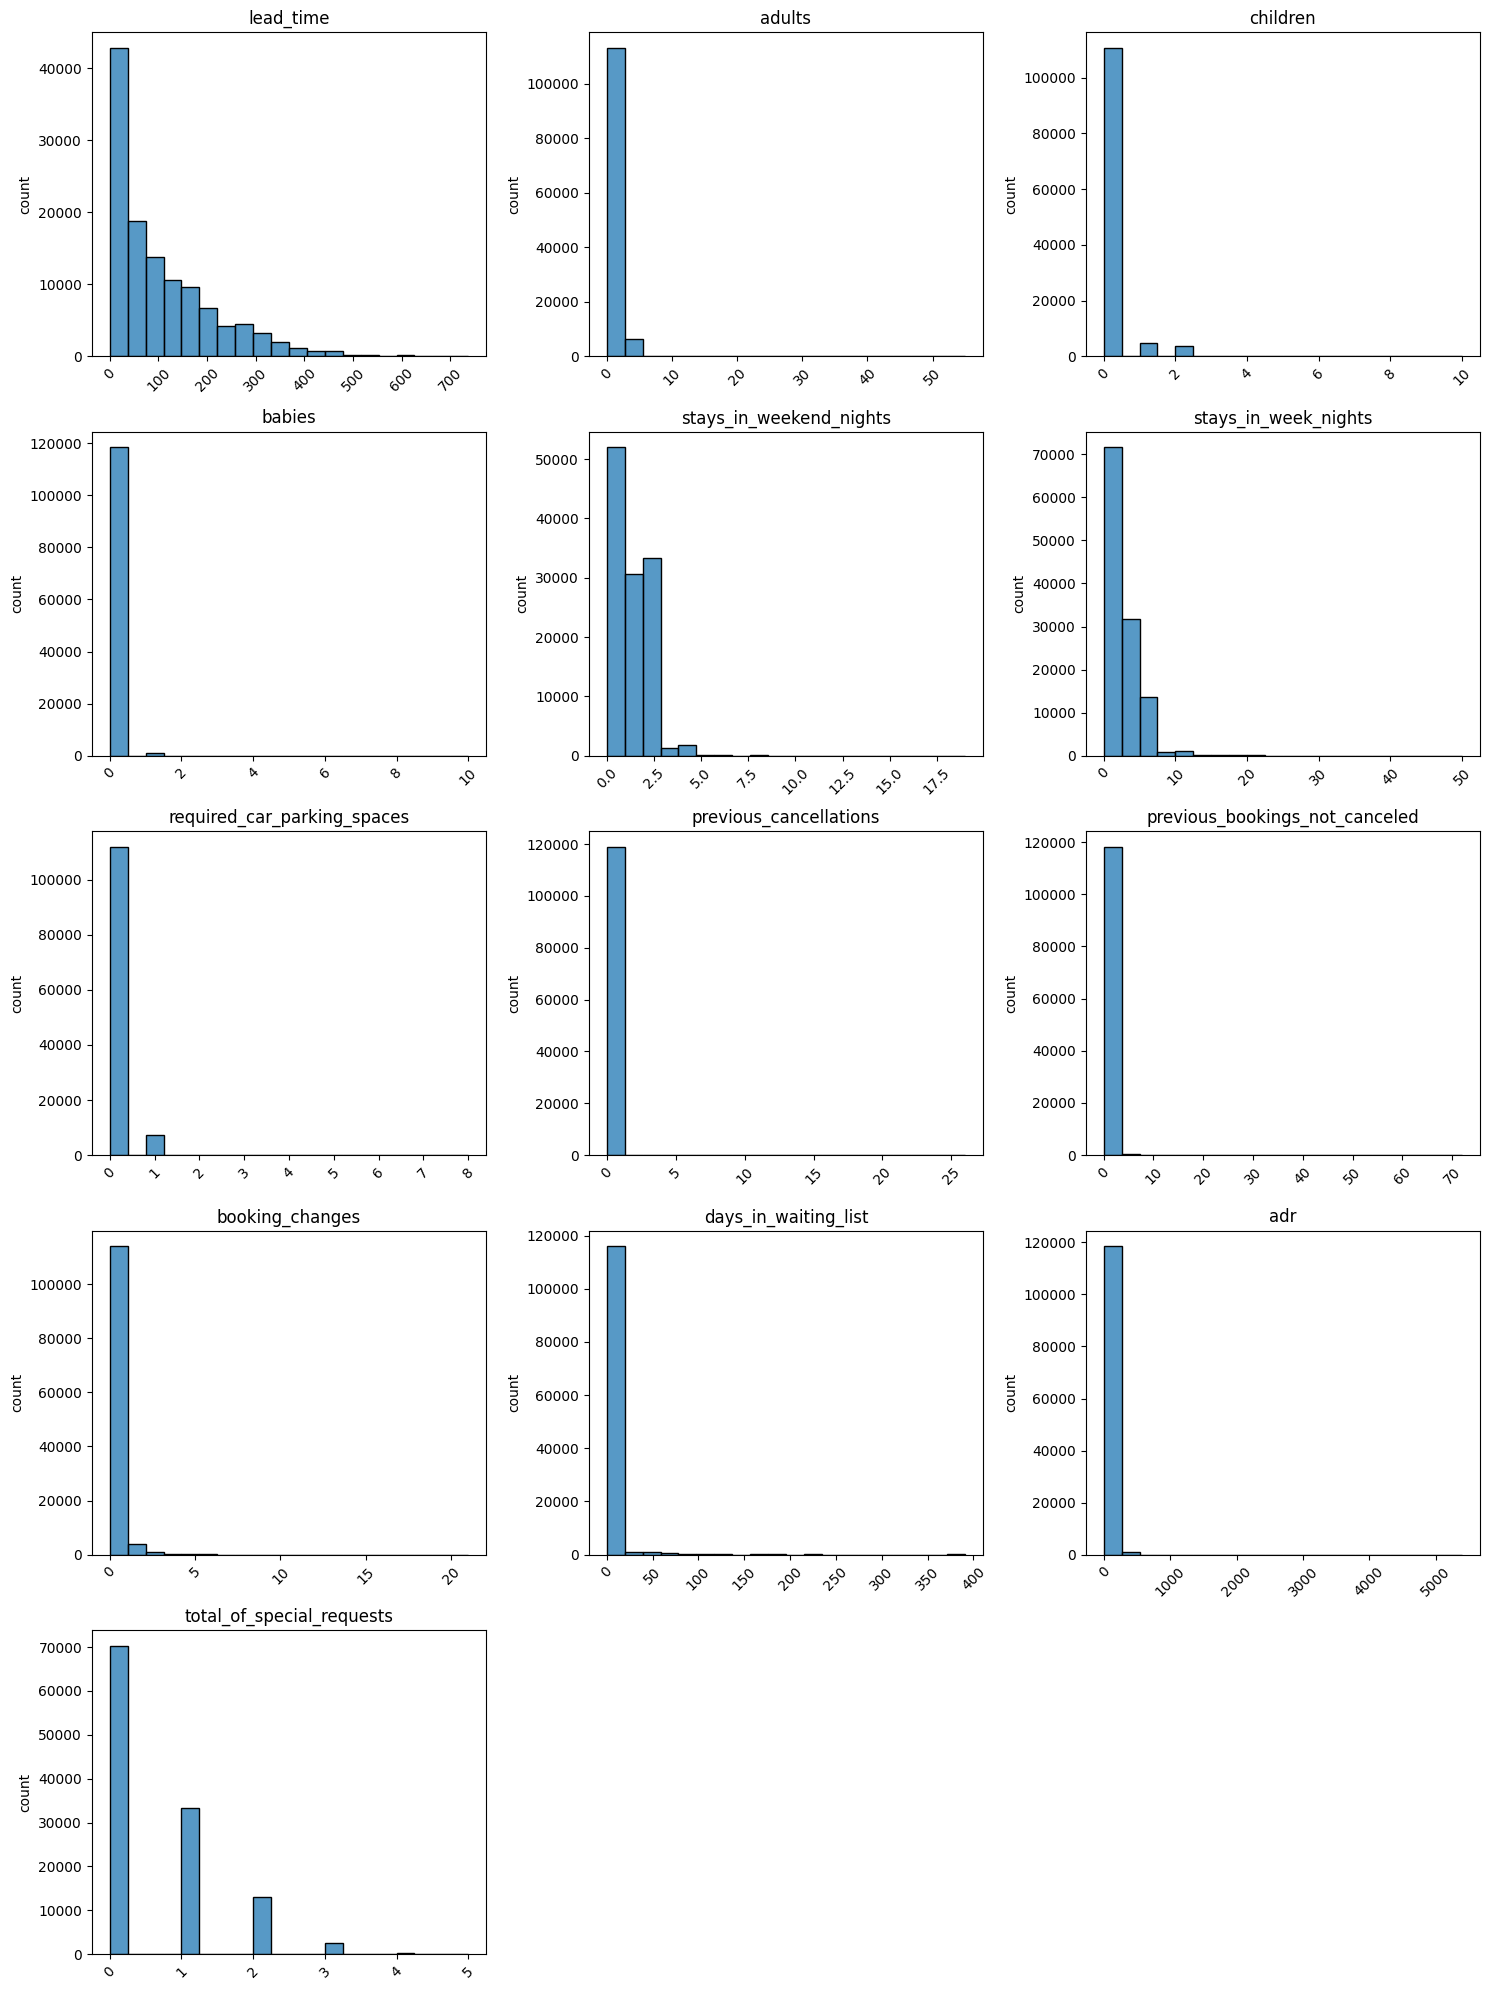

In [20]:
histograms(q2_df, numbers_df.index, bins=20)

Difícil availar o número de bookings não cancelados e dias de espera. Façamos um gráfico de proporções

In [21]:
def count_canceled(df, factor, output):
    counting = DF(df[factor].value_counts())
    counting['canceled'] = [
        sum(df[output][df[factor] == c]) for c in counting.index
    ]
    counting["not_canceled"] = counting.iloc[:, 0] - counting["canceled"]
    counting["canceled%"] = counting["canceled"] / counting.iloc[:, 0]
    counting["not_canceled%"] = counting["not_canceled"] / counting.iloc[:, 0]
    counting.sort_index(inplace=True)
    return counting

def binned_counting(counting, factor_name, num_bins):
    bins = np.linspace(
        counting.index.min(),
        counting.index.max(),
        num_bins + 1
    )

    counting = counting.copy()
    counting['bin'] = pd.cut(counting.index, bins, include_lowest=True)
    #return counting
    groups = counting.groupby('bin', observed=True)
    groups_medians = groups['bin'].first().apply(lambda x: x.mid).astype(float)
    exited_count = groups['canceled'].sum()
    #return exited_count
    stayed_count = groups['not_canceled'].sum()
    total_count = exited_count + stayed_count

    counting = pd.DataFrame({
        'count': total_count,
        factor_name: groups_medians,
        'canceldd': exited_count,
        'not_canceled': stayed_count,
        'canceled%': exited_count / total_count,
        'not_canceled%': stayed_count / total_count,
    }, index=groups_medians)
    return counting

def proportions(df, columns, proportional=True, per_row=3, width=5, height=4):  
    suffix = '%' if proportional else ''

    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        counting = count_canceled(df, col, 'is_canceled')
        sns.set(style="whitegrid")
    
        x = counting.index
        yes = counting["canceled%"]
        no = counting["not_canceled%"]

        
        ax.stackplot(x, yes, no, labels=["canceled", "not_canceled"])
        
        ax.legend(loc="upper right")
        ax.set_xlabel("Index")
        ax.set_ylabel("Proportion")
        ax.set_title(f"Proporção de cancelamento por {col}")
    plt.show()
    

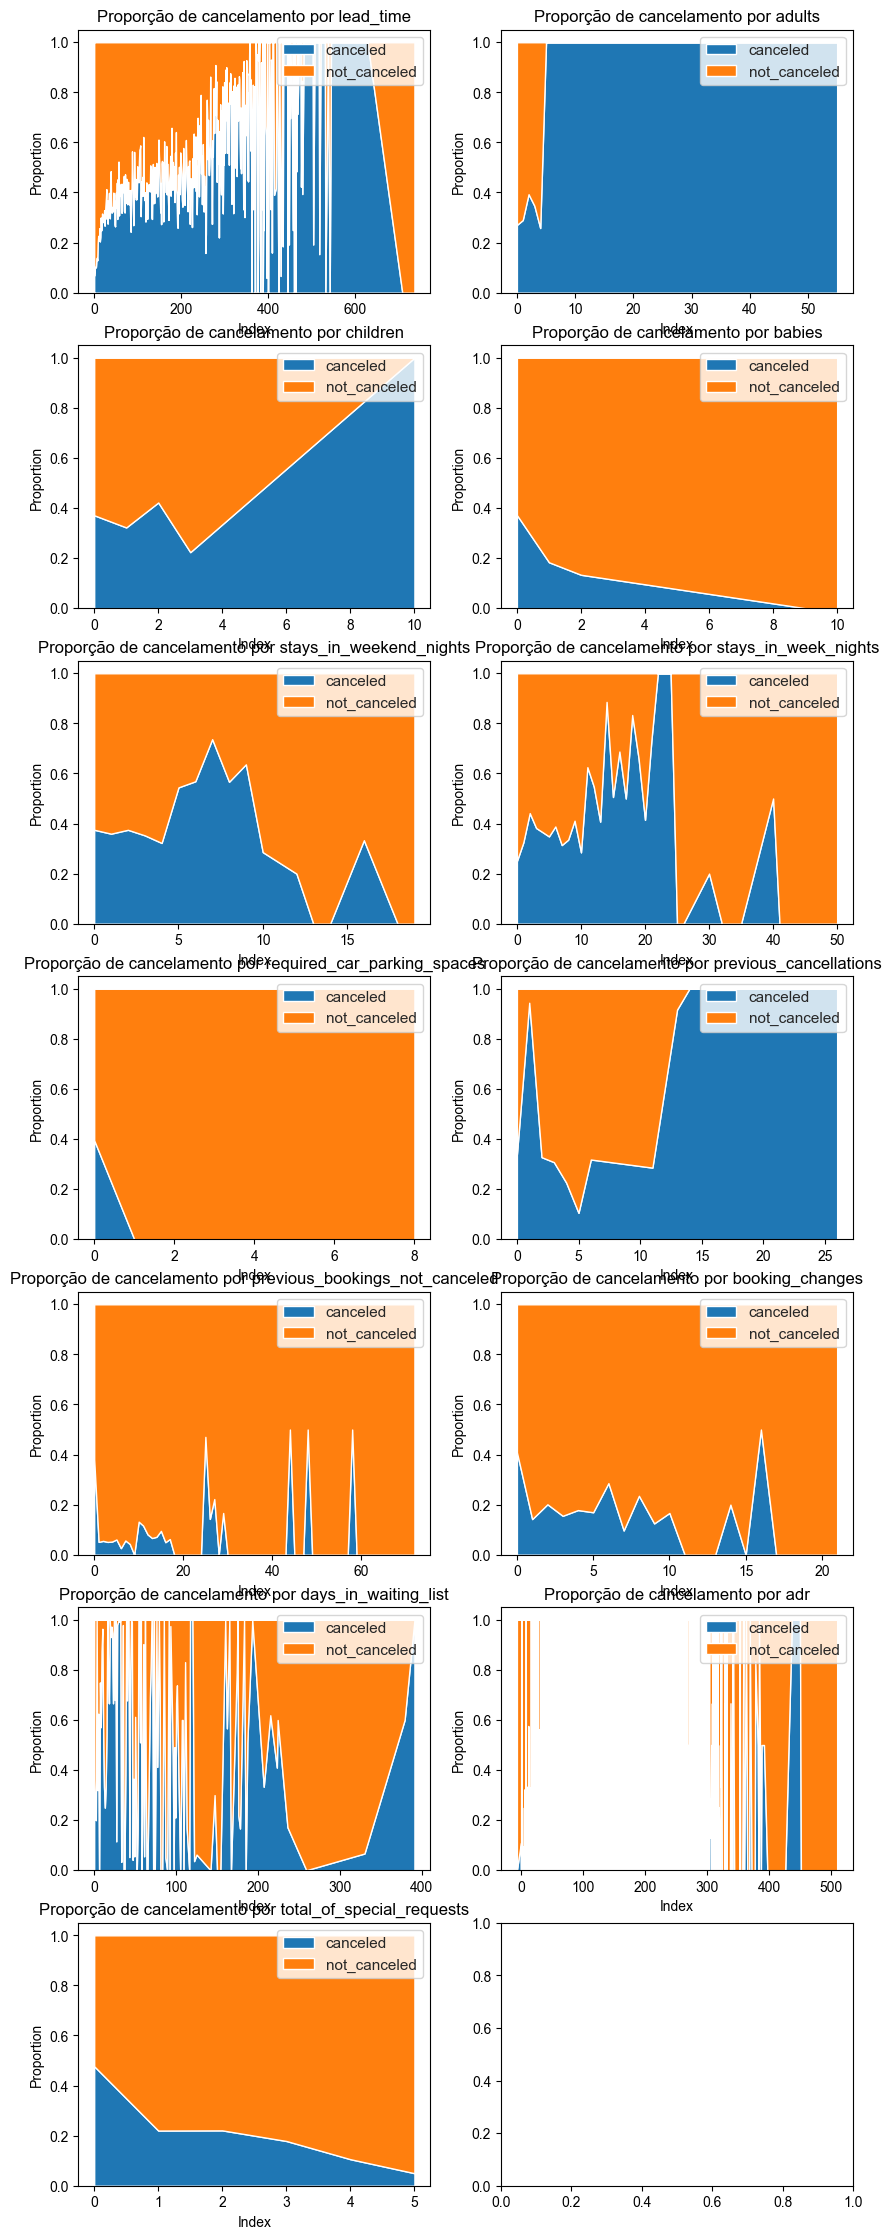

In [22]:
proportions(pd.concat([X, y], axis=1), numbers_df.index, per_row=2)

Os gráficos são horríveis, mas o importante é que mostram que são valors relevantes, nenhum deles é vazio de informação.

##### Coluna `country`

Esses são valores categóricos que possuem categorias demais:

In [23]:
print(q2_df['country'].unique().size)
print(q2_df['company'].unique().size)
print(q2_df['agent'].unique().size)

178
353
334


`country` podem ser agrupados. Podemos usar os agrupamentos do World Bank [[ourworldindata.org]]()b

In [24]:
def normalize_country(series):
    # This map I've got from ChatGPT
    parent_map = {
        'CN': 'CHN',    # Correcting China
        'CYM': 'GBR',   # Cayman Islands → United Kingdom
        'HKG': 'CHN',   # Hong Kong → China
        'MAC': 'CHN',   # Macao → China
        'GIB': 'GBR',   # Gibraltar → United Kingdom
        'JEY': 'GBR',   # Jersey → United Kingdom
        'GGY': 'GBR',   # Guernsey → United Kingdom
        'IMN': 'GBR',   # Isle of Man → United Kingdom
        'VGB': 'GBR',   # British Virgin Islands → United Kingdom
        'AIA': 'GBR',   # Anguilla → United Kingdom
        'FRO': 'DNK',   # Faroe Islands → Denmark
        'GLP': 'FRA',   # Guadeloupe → France
        'MYT': 'FRA',   # Mayotte → France
        'PYF': 'FRA',   # French Polynesia → France
        'ATF': 'FRA',   # French Southern Territories → France
        'ABW': 'NLD',   # Aruba → Netherlands
        'ASM': 'USA',   # American Samoa → United States
        'UMI': 'USA',   # U.S. Minor Outlying Islands → United States
        'TMP': 'TLS',   # Old East Timor code → Timor-Leste
        'ATA': 'ATA',   # Antarctica → Antatctica
        'CN': 'CHN',    # Fix invalid code → China
    }
    return series.fillna('NDA').replace(parent_map)

X['country:parent'] = normalize_country(X['country'])

## Getting WB codes
def world_bank_countries_groups():
    df = pd.read_csv(
        'https://ourworldindata.org/grapher/'
        'world-regions-according-to-the-world-bank.csv?'
        'v=1&csvType=filtered&useColumnShortNames=true&'
        'overlay=download-data',
        storage_options = {
            'User-Agent': 'Our World In Data data fetch/1.0'
        }
    )
    
    ## Apparently people book hotels from Antarctica...
    df.loc[len(df)] = ['Antarctica', 'ATA', 2023, 'Antarctica', 2023]
    df.loc[len(df)] = ['No Data Available', 'NDA', 2023, 'No Data Available', 2023]
    
    df.set_index('Code', inplace=True)
    
    ### Create codes for legibility (names are too long)
    df['wb_region:code'] = df['wb_region'].apply(
        lambda s:
            ''.join(
                c for c in s if c.isupper()
            ).replace('WB', '')
    )
    return df

wb_countries_df = world_bank_countries_groups()

X['country:wb_region'] = X['country:parent'].replace(
    wb_countries_df['wb_region:code'].to_dict()
)

# Getting proportion of cancelations per region
X_y = pd.concat([X, y], axis=1)
wb_region_groupby = X_y.groupby('country:wb_region')
wb_regions_canceled_df = DF({
    'canceled': wb_region_groupby['is_canceled'].sum(),
    'total': wb_region_groupby.size()
})

wb_regions_canceled_df['canceled%'] = (
    wb_regions_canceled_df['canceled'] / 
        wb_regions_canceled_df['total']
)

import geopandas as gpd

def get_world_map(wb_countries_df):
    # Data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
    # Item "Admin 0 - Countries"
    world = gpd.read_file("ne_110m_admin_0_countries.shp")
    # For some reason, these countries have different codes.
    world.loc[world['SOVEREIGNT'] == 'Norway', 'ISO_A3'] = 'NOR'
    world.loc[world['SOVEREIGNT'] == 'France', 'ISO_A3'] = 'FRA'

    world = world.merge(
        wb_countries_df,
        left_on="ISO_A3", right_index=True,
        how="left"
    )
    world['wb_region:code'] = world['wb_region:code'].fillna('NDA')
    return world

world = get_world_map(wb_countries_df[['wb_region:code']])
world['canceled'] = world["wb_region:code"].replace(
    wb_regions_canceled_df['canceled%'].to_dict()
)

def plot_world(world):
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    world.plot(
        column="canceled",
        cmap="Blues",
        linewidth=0.8,
        ax=ax,
        edgecolor="0.8",
        legend=False,
    )
    
    ax.set_title("Proporção de cancelamentos por região do globo", fontsize=16)
    ax.axis("off")
    
    sm = plt.cm.ScalarMappable(
        cmap="Blues",
        norm=plt.Normalize(
            vmin=world["canceled"].min(),
            vmax=world["canceled"].max()
        )
    )
    sm._A = []  # required by matplotlib
    
    cbar = fig.colorbar(
        sm,
        ax=ax,
        fraction=0.046,
        pad=0.04
    )
    cbar.ax.tick_params(labelsize=10)
    cbar.formatter.set_powerlimits((-2, 2))
    
    plt.show()

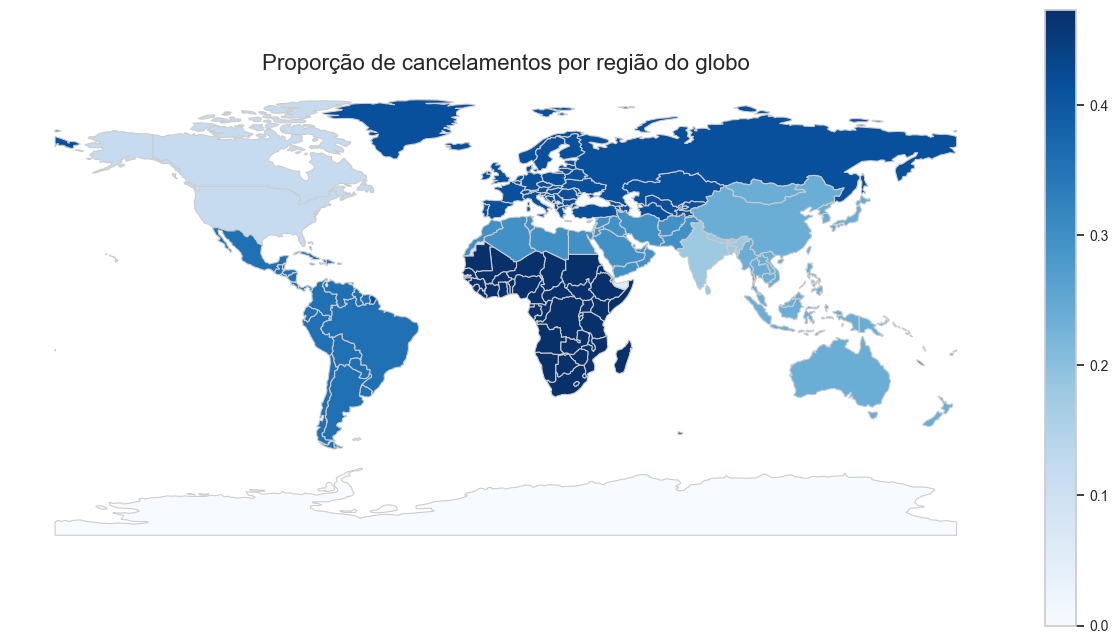

In [25]:
plot_world(world)

VEmos no gráfico que as regiões oferecem informação bem relevante, então vamos mantê-las.

##### Colunas `company`  e `agent`
`company` e `agent` são especialmente problemáticos porque são raramente setados. E possuem muitos valores, não dá para usar one-hot enconding. 



In [26]:
q2_df.groupby('company')['is_canceled'].sum().sort_values()

company
61.000       0
64.000       0
65.000       0
71.000       0
76.000       0
          ... 
153.000     48
348.000     59
40.000      77
223.000    119
67.000     175
Name: is_canceled, Length: 352, dtype: int64

In [27]:
q2_df.groupby('agent')['is_canceled'].sum().sort_values()

agent
535.000        0
527.000        0
510.000        0
508.000        0
54.000         0
           ...  
19.000       780
6.000       1025
1.000       5280
240.000     5484
9.000      13264
Name: is_canceled, Length: 333, dtype: int64

Mas são importantes, e podemos usar target enconding [[scikit-learn.org]](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html). Vamos criar uma pipeline:

In [28]:
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer(
    [
        ('company:mean', TargetEncoder(), ['company']),
        ('agent:mean', TargetEncoder(), ['agent'])
    ],
    remainder='passthrough'
)
pipeline_items = [
    ('transformer', transformer),
]

Também precisamos remover os NaN.

In [29]:
X['company'] = X['company'].fillna(0)
X['agent'] = X['agent'].fillna(0)

##### Data de chegada

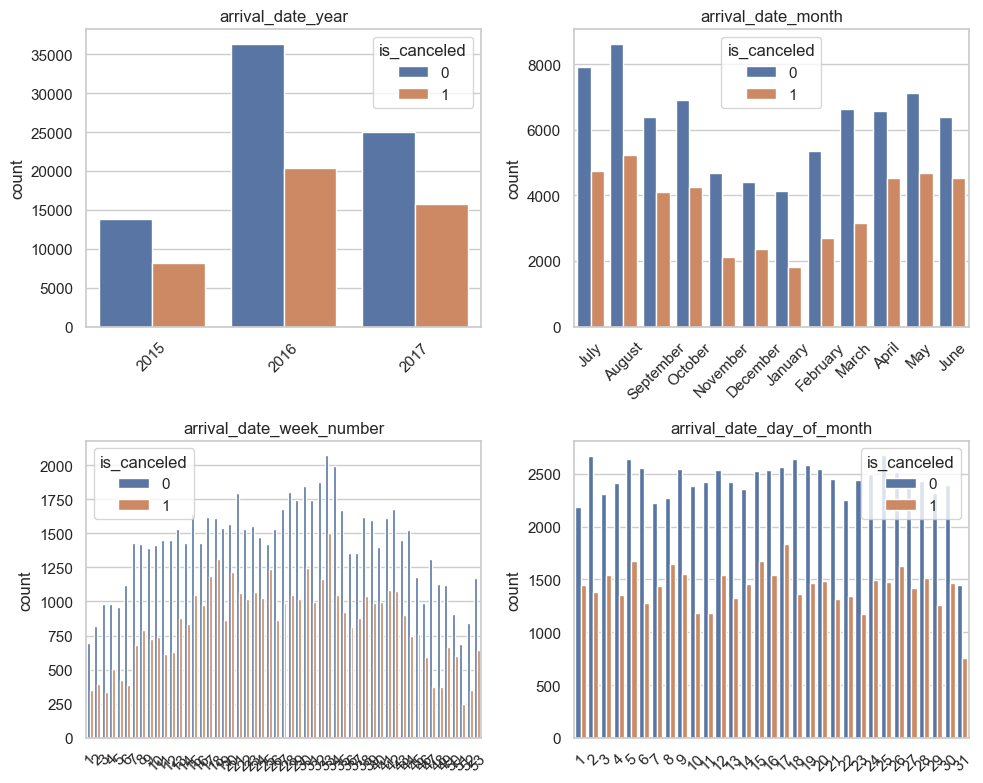

In [30]:
arrival_date_fields = [
    c for c in q2_df.columns
    if c.startswith('arrival_date')
]
countplots(q2_df, arrival_date_fields, per_row=2)

Padrões interessants por dai da semana, mês, ano etc. Talvez o timestamp tenha informaçaõ também, mas **não vamos adicionar o timestamp porque ele já é uma combinaçaõ linear dos outros fatores.**

Precisamos converter mês em um número. Além disso, embora ano tenha um poder de decisão razoável, nós queremos prever eventos futuros, então vamos removê-lo.

In [31]:
import calendar
month_names = list(calendar.month_name)
X['arrival_date_month:number'] = X['arrival_date_month'].map(month_names.index)
X.drop(['arrival_date_month', 'arrival_date_year'], axis=1, inplace=True)

#### Correlações
Vamos calcular correlações (aqui faremos um target enconding de `company`, `country` e `agent`):

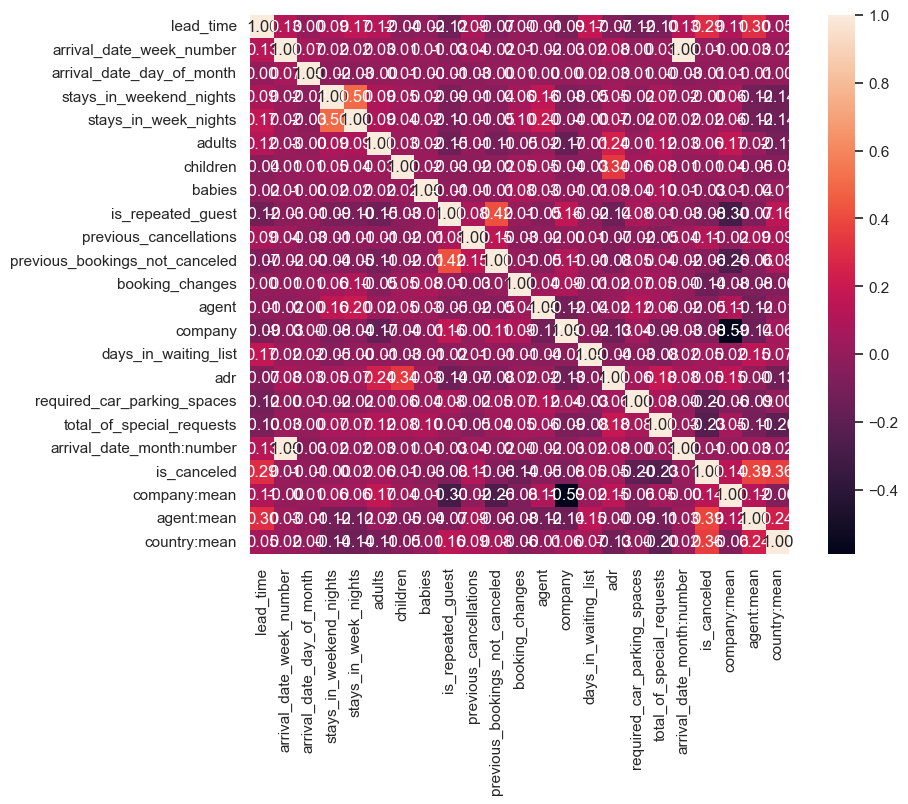

column1                         column2  corr:abs
38   arrival_date_week_number       arrival_date_month:number     0.995
214                   company                    company:mean     0.588
63    stays_in_weekend_nights            stays_in_week_nights     0.499
149         is_repeated_guest  previous_bookings_not_canceled     0.418
248               is_canceled                      agent:mean     0.386
249               is_canceled                    country:mean     0.361
125                  children                             adr     0.341
20                  lead_time                      agent:mean     0.305
159         is_repeated_guest                    company:mean     0.301
18                  lead_time                     is_canceled     0.293

In [32]:
X_corr_inspect = pd.concat([X, y], axis=1)


def target_enconde(df, column, target='is_canceled', op='mean'):
    df[f'{column}:{op}'] = df.groupby(column)[target].transform(op)
    df[f'{column}:{op}'] = df[f'{column}:{op}'].fillna(df[df[column].isna()][target].mean())
target_enconde(X_corr_inspect, 'company')
target_enconde(X_corr_inspect, 'agent')
target_enconde(X_corr_inspect, 'country')

X_corr = X_corr_inspect.corr(numeric_only=True)

plt.figure(figsize=(10, 7))
sns.heatmap(X_corr, annot=True, fmt=".2f", square=True)
plt.show()

columns = X_corr.columns
X_corr_df = DF({
    'column1': [],
    'column2': [],
    'corr:abs': []
})
for i, c1 in enumerate(columns):
    for c2 in columns[i+1:]:
        X_corr_df.loc[len(X_corr_df)] = [c1, c2, abs(X_corr[c1][c2])]

X_corr_df.sort_values(by='corr:abs', ascending=False, inplace=True)
X_corr_df.head(10)


Nenhuma correlação tão grande que indice colinearidade. Mas é interessante notar que `is_repeated_guest` é associado a `previous_bookings_not_canceled`. De fato, a existência de reservas anteriores já indica que o usuário é um hóspede recorrente. Podemos remover esse parâmetro então. Mesmo com `arriva_date_week_number` e `arrival_date_month:number`: um determina o outro, basicamente. Vamos remover a semana, porque, embora tenha mais informação, o mês é mais interpretável, e o dia do mês têm o resto da informação.

In [33]:
X.drop(['is_repeated_guest', 'arrival_date_week_number'], axis=1, inplace=True)

#### Encoding

In [34]:
X['country'] = ''
X_encoded = X.drop(['country', 'country:parent'], axis=1)
X_encoded = pd.get_dummies(X_encoded, columns=categories_df.index, drop_first=True, dtype=int)
X_encoded = pd.get_dummies(X_encoded, columns=['country:wb_region'], drop_first=True, dtype=int)
X_encoded = X_encoded.fillna(0)

#### Colinearidade

Para a regressão funcionar, não pode haver colinearidade entre os campos. Verifiquemos:

In [35]:
X_colin = sm.add_constant(X_encoded)

In [36]:
vif_df = pd.DataFrame({
    "feature": X_colin.columns,
    "VIF": [variance_inflation_factor(X_colin.values, i)
            for i in range(X_colin.shape[1])]
}).sort_values(by='VIF', ascending=False)
print('done')

/home/adam/lib/virtualenv/data-mining-experiments/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


done


In [37]:
vif_df.head(69)

feature       VIF
58       assigned_room_type_P       inf
47       reserved_room_type_P       inf
0                       const 60271.958
60      country:wb_region_ECA  5073.116
59      country:wb_region_EAP  1664.699
..                        ...       ...
35    deposit_type_Refundable     1.041
55       assigned_room_type_I     1.037
7                      babies     1.026
56       assigned_room_type_K     1.021
2   arrival_date_day_of_month     1.008

[67 rows x 2 columns]

Não surpreende que o quarto atribuído seja tão próximo do quarto reservado! 

In [38]:
vif_df[vif_df['feature'].map(lambda s: '_room_type' in s)]

feature   VIF
58  assigned_room_type_P   inf
47  reserved_room_type_P   inf
44  reserved_room_type_G 5.040
45  reserved_room_type_H 5.039
54  assigned_room_type_H 4.977
53  assigned_room_type_G 4.837
43  reserved_room_type_F 3.662
42  reserved_room_type_E 3.629
51  assigned_room_type_E 3.586
52  assigned_room_type_F 3.519
41  reserved_room_type_D 2.827
50  assigned_room_type_D 2.787
39  reserved_room_type_B 1.717
48  assigned_room_type_B 1.687
40  reserved_room_type_C 1.682
49  assigned_room_type_C 1.612
46  reserved_room_type_L 1.203
57  assigned_room_type_L 1.201
55  assigned_room_type_I 1.037
56  assigned_room_type_K 1.021

A relação entre o quarto reservado e o recebido é relevante, mas só se recebe quarto quando a reserva é executada. Podemos ao menos remover o caso de linearidade completa.

In [39]:
X_encoded.drop('assigned_room_type_P', axis=1, inplace=True)
X_colin.drop('assigned_room_type_P', axis=1, inplace=True)

Países também tiveram VIF alto.

In [40]:
vif_df[vif_df['feature'].map(lambda s: 'country' in s)]

feature      VIF
60     country:wb_region_ECA 5073.116
59     country:wb_region_EAP 1664.699
61     country:wb_region_LAC 1405.615
63      country:wb_region_NA 1032.234
62  country:wb_region_MENAAP  716.373
66     country:wb_region_SSA  333.690
64     country:wb_region_NDA  244.104
65      country:wb_region_SA   92.878

In [41]:
X_colin.corr()['country:wb_region_ECA'].abs().sort_values()

required_car_parking_spaces      0.000
assigned_room_type_L             0.001
market_segment_Undefined         0.001
assigned_room_type_H             0.002
distribution_channel_Undefined   0.002
                                  ... 
country:wb_region_NA             0.416
country:wb_region_LAC            0.489
country:wb_region_EAP            0.534
country:wb_region_ECA            1.000
const                              NaN
Name: country:wb_region_ECA, Length: 66, dtype: float64

In [42]:
import numpy as np
np.linalg.matrix_rank(X_colin)

np.int64(66)

In [43]:
X_colin.columns.size

66

Temos rank menor que colunas. Crítico! Suspeitamaos relação colinear entre região e tipos de quartos:

In [44]:
X.groupby(['reserved_room_type', 'country:wb_region']).size().unstack(fill_value=0)

country:wb_region   A   EAP    ECA   LAC  MENAAP    NA  NDA   SA  SSA
reserved_room_type                                                   
A                   1  2252  78630  1909    1022  1230  393  111  445
B                   0    24    974    52      28    30    0    3    7
C                   0    14    857    19      14    23    1    1    3
D                   0   675  17067   607     244   425   28   43  112
E                   1   254   5831   134      54   167   38   11   45
F                   0   114   2487    73      56   112    7    6   42
G                   0    69   1806    66      24    98   11    7   13
H                   0    23    536    18       6    14    0    2    2
L                   0     0      6     0       0     0    0    0    0
P                   0     0      2     0       0     0   10    0    0

In [45]:
X.groupby(['assigned_room_type', 'country:wb_region']).size().unstack(fill_value=0)

country:wb_region   A   EAP    ECA   LAC  MENAAP    NA  NDA  SA  SSA
assigned_room_type                                                  
A                   1  2022  67687  1689     897  1079  190  92  395
B                   0    57   1918    79      40    54    0   3   12
C                   0    52   2185    51      16    36   21   4   10
D                   0   755  22729   701     324   467  156  54  136
E                   1   274   6993   167      62   178   68  14   49
F                   0   139   3241    92      67   143   19   7   43
G                   0    86   2215    73      28   112   14   7   18
H                   0    23    640    19       6    16    4   2    2
I                   0     9    336     1       1     7    6   0    3
K                   0     8    249     6       7     7    0   1    1
L                   0     0      1     0       0     0    0   0    0
P                   0     0      2     0       0     0   10   0    0

Confirmado. Vamos remover o tipo do quarto:

In [46]:
columns = [c for c in X_colin.columns if 'room' in c]
for c in columns:
    X_encoded.drop(c, axis=1, inplace=True)
    X_colin.drop(c, axis=1, inplace=True)

X_encoded.drop(['country:wb_region_SA', 'country:wb_region_NDA'], axis=1, inplace=True)
X_colin.drop(['country:wb_region_SA', 'country:wb_region_NDA'], axis=1, inplace=True)

Agora temos outra identidade quase completa entre o segmento de mercado e o canal de distribuição. Removamos alguns deles.

In [47]:
columns = [c for c in X_colin.columns if 'market_segment' in c]
for c in columns:
    X_encoded.drop(c, axis=1, inplace=True)
    X_colin.drop(c, axis=1, inplace=True)

In [48]:
vif_df = pd.DataFrame({
    "feature": X_colin.columns,
    "VIF": [variance_inflation_factor(X_colin.values, i)
            for i in range(X_colin.shape[1])]
}).sort_values(by='VIF', ascending=False)
print('done')

done


In [49]:
vif_df.head(20)

feature     VIF
0                           const 255.001
33          country:wb_region_ECA  15.410
31  customer_type_Transient-Party   6.186
30        customer_type_Transient   6.084
32          country:wb_region_EAP   6.023
34          country:wb_region_LAC   5.247
25     distribution_channel_TA/TO   4.753
36           country:wb_region_NA   4.121
23    distribution_channel_Direct   4.006
35       country:wb_region_MENAAP   3.171
18             hotel_Resort Hotel   2.489
11                          agent   2.065
37          country:wb_region_SSA   2.022
12                        company   1.594
27        deposit_type_Non Refund   1.522
4            stays_in_week_nights   1.470
1                       lead_time   1.456
14                            adr   1.419
3         stays_in_weekend_nights   1.379
16      total_of_special_requests   1.190

### Modelo de regressão logística

/home/adam/lib/virtualenv/data-mining-experiments/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acurácia : 0.806
Precisão : 0.845
Recall   : 0.593
F1-score : 0.697


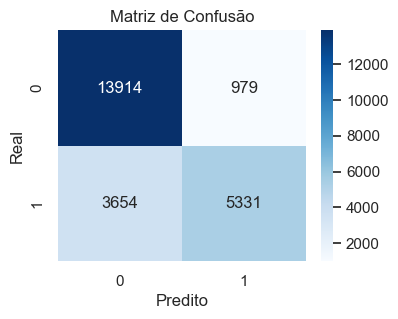

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Acurácia : {accuracy_score(y_test, y_pred):.03f}")
    print(f"Precisão : {precision_score(y_test, y_pred):.03f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.03f}")
    print(f"F1-score : {f1_score(y_test, y_pred):.03f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão")
    plt.show()

def train_and_test(X, y, pipeline):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )
    
    pipe = Pipeline(pipeline + [('clf', LogisticRegression(max_iter=1000))])
    model = pipe.fit(X_train, y_train['is_canceled'])
    evaluate_model(model, X_test, y_test)
    return model #, x_train, X_test, y_train, y_test

model = train_and_test(X_encoded, y, pipeline_items)

Modelo falhou em convergir. Vamos tentar normalizar os valores

Acurácia : 0.799
Precisão : 0.837
Recall   : 0.579
F1-score : 0.685


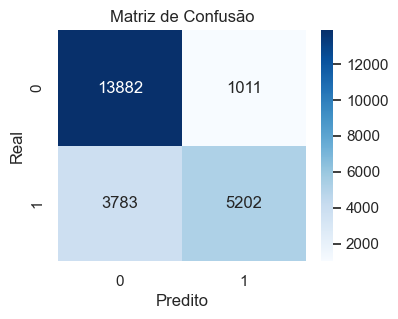

In [51]:
from sklearn.preprocessing import MinMaxScaler

model = train_and_test(X_encoded, y, pipeline_items + [('norm', MinMaxScaler())])

Essa performance parece baixa...

### Análise de _features_

In [52]:
coef = pd.DataFrame({
    "feature": X_encoded.columns,
    "coef": model['clf'].coef_[0]
})

coef["abs_coef"] = coef["coef"].abs()
coef_sorted = coef.sort_values("abs_coef", ascending=False)
coef_sorted.head(20)

feature    coef  abs_coef
14     required_car_parking_spaces -21.752    21.752
9                  booking_changes  18.789    18.789
11                         company  -7.359     7.359
10                           agent  -6.661     6.661
26         deposit_type_Non Refund   4.489     4.489
1        arrival_date_day_of_month   3.987     3.987
6                           babies   3.436     3.436
0                        lead_time   3.370     3.370
15       total_of_special_requests  -3.164     3.164
2          stays_in_weekend_nights   2.870     2.870
13                             adr   2.459     2.459
25  distribution_channel_Undefined   2.403     2.403
5                         children   2.385     2.385
12            days_in_waiting_list  -1.761     1.761
7           previous_cancellations   1.378     1.378
27         deposit_type_Refundable   1.155     1.155
36           country:wb_region_SSA   1.018     1.018
29         customer_type_Transient   0.748     0.748
4                           adults   0.740     0.740
22     distribution_channel_Direct  -0.710     0.710

O número de vagas de carro reservadas têm um peso enorme! Esse não conseguimos interpretar.

`booking_changes` é o segundo fator mais relevante, e faz sentido: uma reserva problemática antes de se tornar totalmente inviável.

`company`  e `agent` são interessantes, porque aparentemente reduzem a probabilidade de cancelamento. Talvez esses garantam que a viagem seja mais bem planejada?

Talvez a variável mais estranha seja o tipo de reserva sem reembolso. Afinal, se não pode haver reembolso, então os hóspedes podem ser relutantes em perder o dinheiro. Mas a variável parece aumentar a probabilidade de cancelamento! Mas isso parece advir de agentes solicitarem muitas reservas sem reembolso.

In [53]:
q2_df.groupby(['agent','deposit_type'])['is_canceled'].mean().unstack()

deposit_type  No Deposit  Non Refund  Refundable
agent                                           
1.000              0.387       1.000         NaN
2.000              0.210         NaN         NaN
3.000              0.208       1.000         NaN
4.000              0.590       1.000         NaN
5.000              0.255       1.000         NaN
...                  ...         ...         ...
510.000            0.000         NaN         NaN
526.000            0.100         NaN         NaN
527.000            0.000         NaN         NaN
531.000            0.676         NaN         NaN
535.000            0.000         NaN         NaN

[333 rows x 3 columns]

### Justificativa de modelo

A regressão logística é mais apropriada porque permite uma resposta binária, enquanto a regressão linear leva a uma resposta numérica que varia muito. Como a saída a ser estimada é booleana (cancelado/não cancelado), a regressão logística é a escolha mais óbvia.

## Questão 3

> Esta questão aborda a aplicação prática de um problema de ANOVA (Análise de Variância) utilizando dados reais empregados em contextos empresariais. O objetivo é analisar as médias de quantidades e preços de produtos agrupados por paı́ses, utilizando o conjunto de dados Vendas de Varejo Online. Siga os passos abaixo para desenvolver sua solução.


### Análise Descritiva dos Dados

In [2]:
import pandas as pd

q3_df = pd.read_excel("online_retail_II.xlsx")

In [3]:
q3_df.head(3)

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom

In [4]:
len(q3_df)

525461

In [5]:
q3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


Sete colunas.
#### Preparação de dados
Há alguns valores nulos em Description e Customer ID, mas essas colunas não devem afetar nossas operações, então não vou remover tais linhas.

Nosso interesse: produtos, países e preço. Removamos todas as outras. Mantendo description para interpretação, e Invoice para remover cancelamentos.

In [6]:
relevant_cols_df = q3_df.drop(['InvoiceDate', 'Customer ID'], axis=1)

Segundo a documentação da base, transações que começam com `c` indicam cancelamento. Vejamos quantas há:

In [7]:
relevant_cols_df["Invoice"].str.startswith(('C', 'c'), na=False).sum()

np.int64(10206)

In [8]:
no_cancel_df = relevant_cols_df[~relevant_cols_df["Invoice"].str.startswith(('C', 'c'), na=False)]

Removidos os cancelmanentos, observemos as estatísticas:

In [9]:
no_cancel_df.describe()

Quantity          Price
count  515255.000000  515255.000000
mean       10.956631       3.956373
std       104.354013     127.688563
min     -9600.000000  -53594.360000
25%         1.000000       1.250000
50%         3.000000       2.100000
75%        10.000000       4.210000
max     19152.000000   25111.090000

Ainda há valores negativos. Vamos removê-los.

In [10]:
no_neg_df = no_cancel_df[(no_cancel_df['Quantity'] > 0) & (no_cancel_df['Price'] > 0)]

In [11]:
print(f'Número de países: {no_neg_df['Country'].unique().size}')
print(f'Número de produtos: {no_neg_df['Description'].unique().size}')

Número de países: 40
Número de produtos: 4534


In [12]:
products_per_country_df = DF(
    no_neg_df.groupby('Country')['StockCode'].unique().apply(len)
).rename({'StockCode': 'SKUs'}, axis=1)
products_per_country_df

SKUs
Country                   
Australia              418
Austria                363
Bahrain                 93
Belgium                481
Bermuda                 34
Brazil                  61
Canada                  77
Channel Islands        541
Cyprus                 417
Denmark                284
EIRE                  2047
Finland                226
France                1297
Germany               1457
Greece                 419
Hong Kong               60
Iceland                 70
Israel                  73
Italy                  510
Japan                  129
Korea                   52
Lebanon                 12
Lithuania              113
Malta                  162
Netherlands            879
Nigeria                 30
Norway                 219
Poland                 133
Portugal               544
RSA                    101
Singapore              110
Spain                  682
Sweden                 432
Switzerland            674
Thailand                76
USA                    159
United Arab Emirates   334
United Kingdom        4241
Unspecified            245
West Indies             49

In [13]:
no_neg_df.describe()

Quantity          Price
count  511565.00000  511565.000000
mean       11.40017       4.251841
std        86.76126      63.662597
min         1.00000       0.001000
25%         1.00000       1.250000
50%         3.00000       2.100000
75%        10.00000       4.210000
max     19152.00000   25111.090000

"Unspecified" não nos interessa, removendo-os':

In [14]:
specified_countries_df = no_neg_df[no_neg_df['Country'] != 'Unspecified']
specified_countries_df.describe()

Quantity          Price
count  511259.000000  511259.000000
mean       11.400277       4.252465
std        86.786769      63.681599
min         1.000000       0.001000
25%         1.000000       1.250000
50%         3.000000       2.100000
75%        10.000000       4.210000
max     19152.000000   25111.090000

#### Gráficos de distribuiçoes

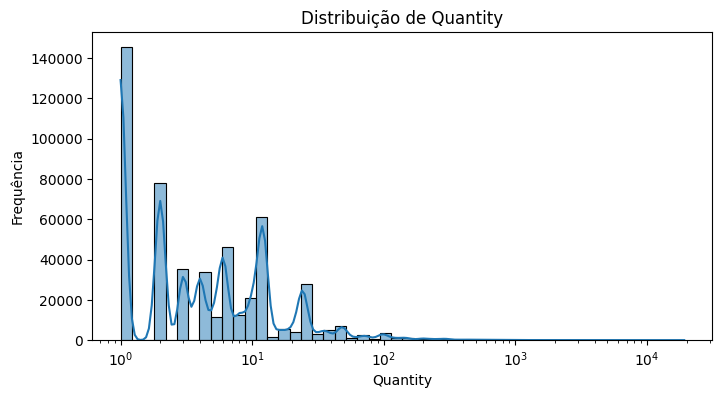

In [15]:
plt.figure(figsize=(8, 4))
sns.histplot(specified_countries_df['Quantity'], bins=50, kde=True, log_scale=True)
plt.title('Distribuição de Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequência')
plt.show()

Grande variedade de quantidades, a maioria em valores pequenos entre 1 e 100.

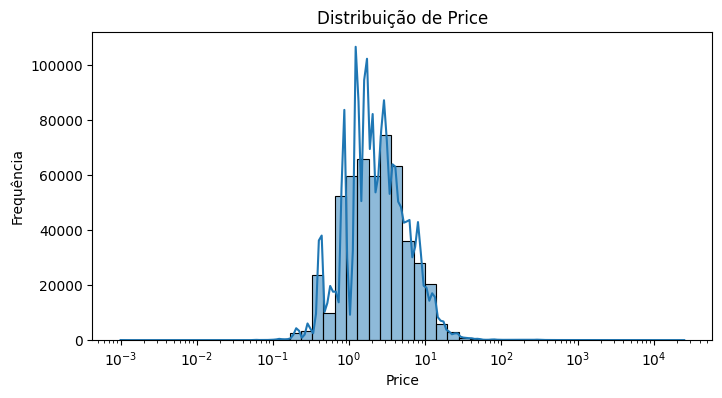

In [16]:
plt.figure(figsize=(8, 4))
sns.histplot(specified_countries_df['Price'], bins=50, kde=True, log_scale=True)
plt.title('Distribuição de Price')
plt.xlabel('Price')
plt.ylabel('Frequência')
plt.show()

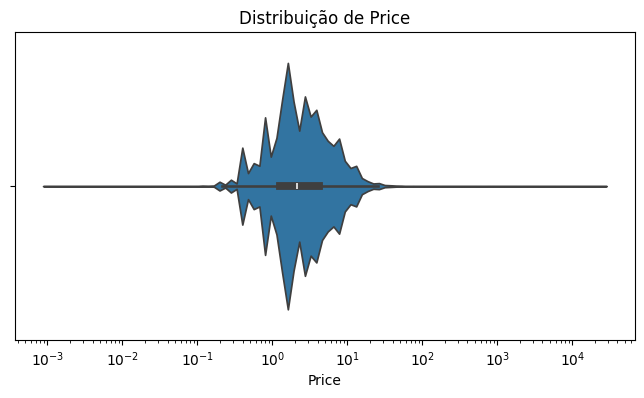

In [17]:
plt.figure(figsize=(8, 4))
sns.violinplot(x=specified_countries_df['Price'], log_scale=True)
plt.title('Distribuição de Price')
plt.xlabel('Price')
plt.show()

Preços parecem seguir uma distribuição nornmal.

#### Mèdias por país e produto

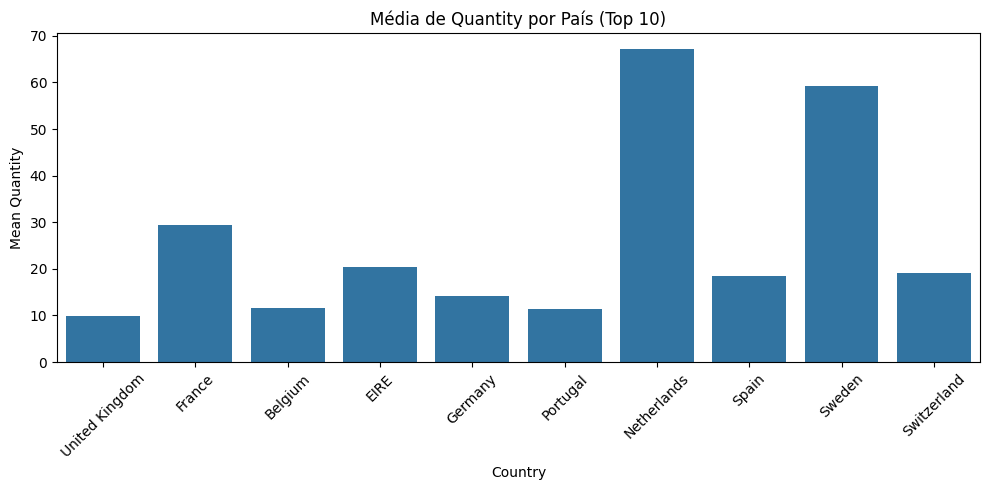

In [18]:
top_countries = specified_countries_df['Country'].value_counts().head(10).index
df_top = specified_countries_df[specified_countries_df['Country'].isin(top_countries)]

plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_top,
    x='Country',
    y='Quantity',
    estimator='mean',
    errorbar=None
)
plt.title('Média de Quantity por País (Top 10)')
plt.xticks(rotation=45)
plt.xlabel('Country')
plt.ylabel('Mean Quantity')
plt.tight_layout()
plt.show()


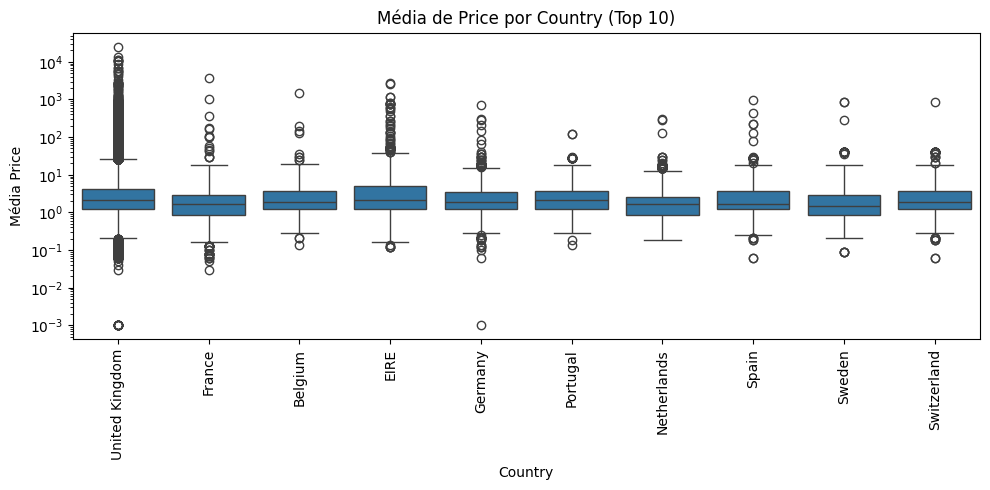

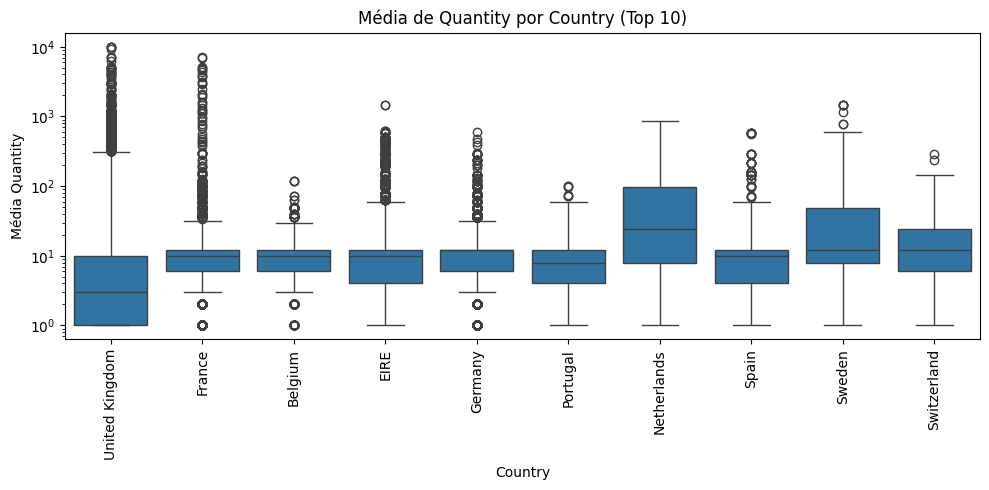

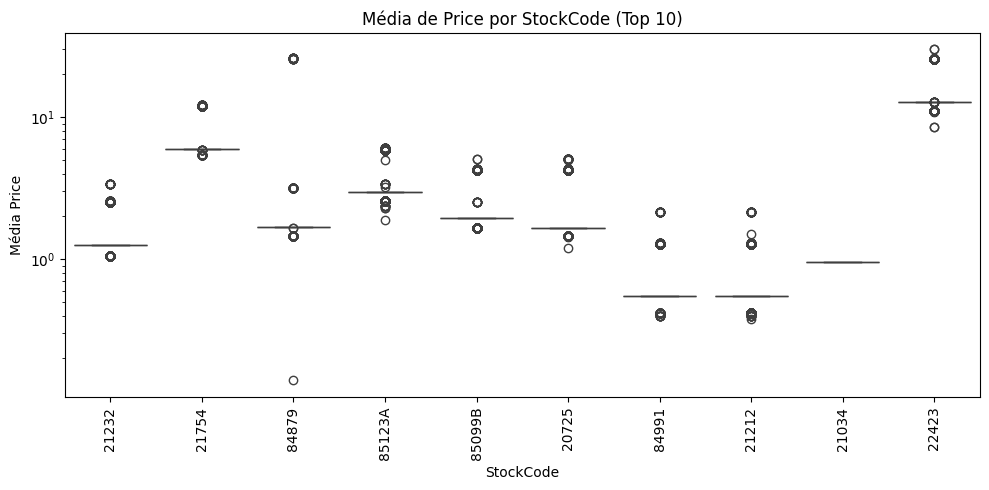

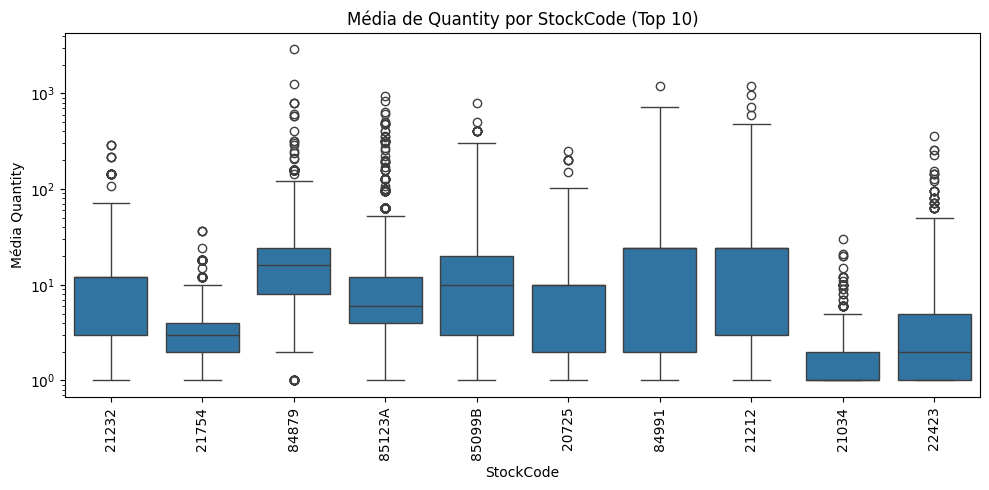

In [19]:

def boxplot(df, x, y, top=10):
    top_groups = df[x].value_counts().head(top).index
    df_top = df[df[x].isin(top_groups)]
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(
        data=df_top,
        x=x,
        y=y,
        log_scale=True
    )
    plt.title(f'Média de {y} por {x} (Top {top})')
    plt.xticks(rotation=90)
    plt.xlabel(x)
    plt.ylabel(f'Média {y}')
    plt.tight_layout()
    plt.show()
boxplot(specified_countries_df, 'Country', 'Price')
boxplot(specified_countries_df, 'Country', 'Quantity')
boxplot(specified_countries_df, 'StockCode', 'Price')
boxplot(specified_countries_df, 'StockCode', 'Quantity')

Preços com cauda longa para valores mais altos tanto para país quanto para produtos (faz sentido, há limite para quão baixo o preço é, mas não para quão alto).  Preços por produtos bem dispersos.

#### Conclusão

Antes da aplicação da ANOVA, realizou-se uma análise descritiva para compreender o comportamento das variáveis de interesse (Quantity e Price) e identificar possíveis padrões entre os países. Também foram removidos registros contendo valores negativos, que correspondem a devoluções, cancelamentos ou ajustes no sistema, de modo a manter apenas vendas efetivas na análise

In [20]:
actual_df = specified_countries_df

### Comparação entre Paı́ses (ANOVA)

Rodemos ANOVA sobre países:

In [21]:
import scipy.stats as stats

from scipy import stats

def anova(df, factor, value):
    # Clean up off missing values
    data = df[[factor, value]].dropna()
    groups = [group[value].values for _, group in data.groupby(factor)]
    f_stat, p_val = stats.f_oneway(*groups)

    # Degrees of freedom
    k = len(groups)           # number of categories
    N = sum(len(g) for g in groups)  # total samples
    df_between = k - 1
    df_within = N - k
    return (
        factor,
        df_between,
        df_within,
        f_stat, 
        p_val
    )

(
    factor,
    df_between,
    df_within,
    f_stat,
    p_value
) = anova(actual_df, 'Country', 'Price')

print(
    f"{factor}:\tF({df_between}, {df_within}) = "
    f"{f_stat:.3f}, p = {p_value:.3e}")


Country:	F(38, 511220) = 5.226, p = 1.282e-23


Temos um _p-value_ muito pequeno, bem menor que e.g. 0,05. Podemos facilmente _rejeitar a hipótese de que não há diferença significativa entre preços._ Em outras palavras, **há diferença estatisticamente significativa entre os preços médios dos países.**

Não só isso, $F = 5,225$ indica variância entre países cinco vezes maior que variância dentro de países. Não só há differença estatisticamente significativa, **a variabilidade entre dos paísees é considerável, na ordem de 5 vezes a variação interna dos páises**.

### Validação de pressupostos

#### Normalidade de resídulos

Vejamos o QQ-plot:

<Figure size 600x600 with 0 Axes>

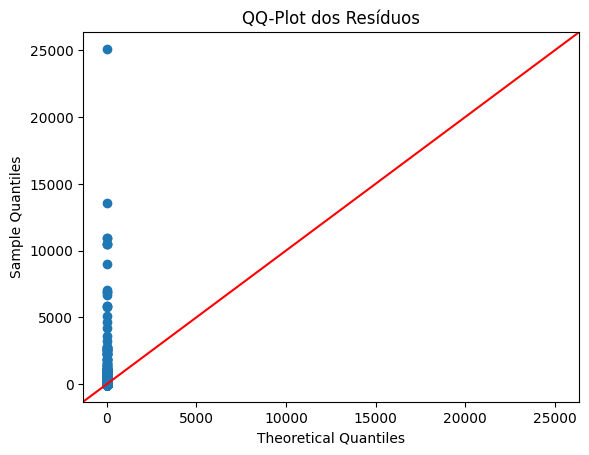

In [22]:
from statsmodels.formula.api import ols

model = ols("Price ~ C(Country)", data=actual_df).fit()

residuals = model.resid


plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='45')
plt.title("QQ-Plot dos Resíduos")
plt.show()

Claramente os resíduos não seguem distribuição normal! Vejamos um histograma:

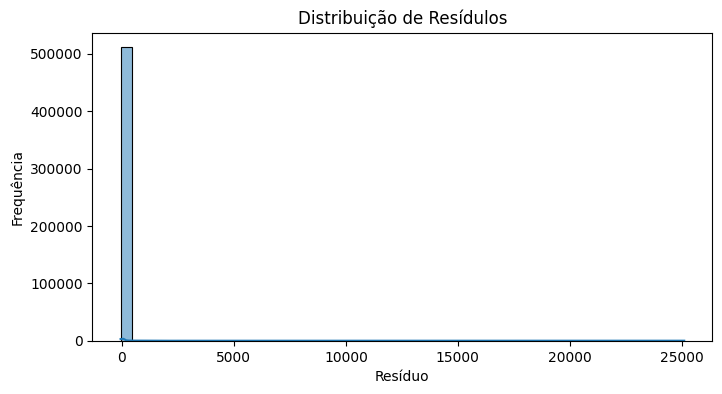

In [23]:
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribuição de Resídulos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.show()

Muitos valores perto de zero! Vejamos em escala logaritmica:

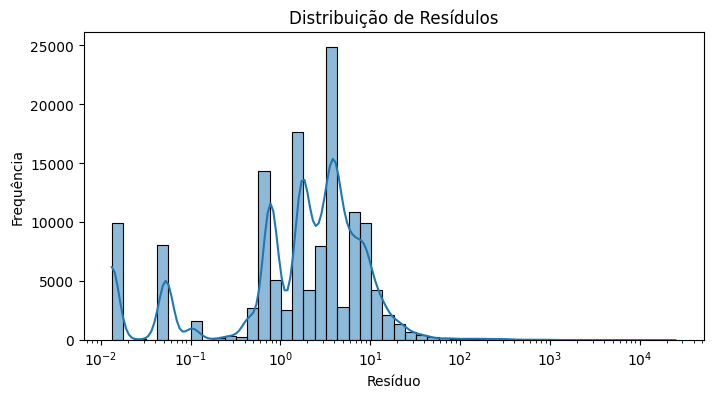

In [24]:
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True, log_scale=(True, False))
plt.title('Distribuição de Resídulos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.show()

Ainda desbalanceado, mas mais próximo de resíduos normais. Vamos calcular ANOVA com o logaritmo dos preços:

In [25]:
actual_df.loc[:,'Price:log'] = np.log1p(actual_df['Price'])
(
    factor,
    df_between,
    df_within,
    f_stat,
    p_value
) = anova(actual_df, 'Country', 'Price:log')

print(
    f"{factor}:\tF({df_between}, {df_within}) = "
    f"{f_stat:.3f}, p = {p_value:.3e}")

Country:	F(38, 511220) = 31.140, p = 2.699e-223


/tmp/ipykernel_861891/1002544387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_df.loc[:,'Price:log'] = np.log1p(actual_df['Price'])


Vejamos os resídulos:

<Figure size 600x600 with 0 Axes>

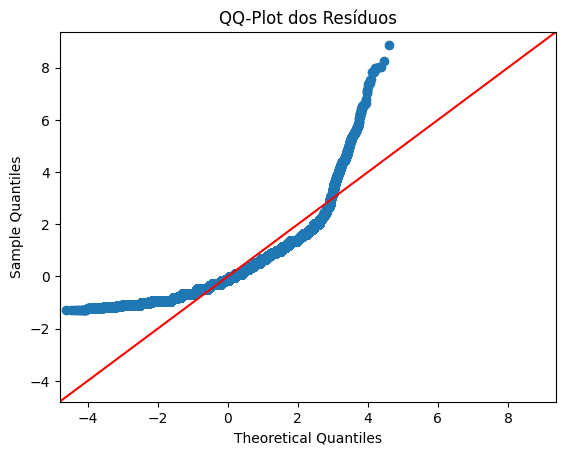

In [26]:
log_model = ols('Q("Price:log") ~ C(Country)', data=actual_df).fit()

residuals = log_model.resid

plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='45')
plt.title("QQ-Plot dos Resíduos")
plt.show()

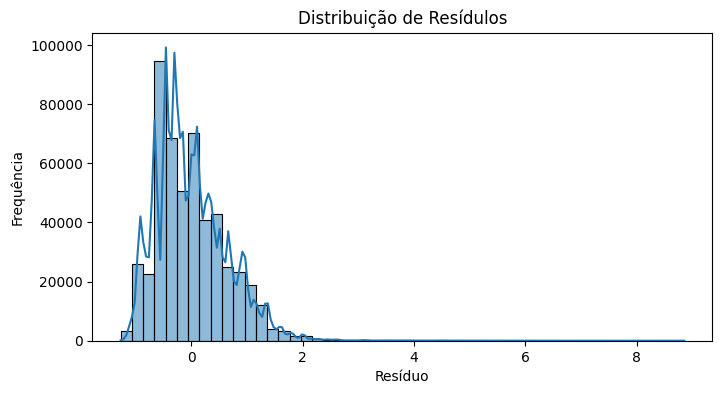

In [27]:
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribuição de Resídulos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.show()

Bem melhor, mas ainda não totalmente normal. ANOVA é resiliente para amostras grandes como a nossa, porém. Esse efeito, talvez causado pelos outliers (temos produtos com valores bem altos!) não necessariamente invalida o modelo.

#### Homocedasticidade

Verificemos a homocedasticidade dos resídulos, podemos usar o [teste de Breusch-Pagan](https://statorials.org/pt/teste-de-breusch-pagao/).

In [28]:
from scipy.stats import levene
actual_df.loc[:,'residuals'] = residuals
def print_levene(df, factor, output):
    groups = [group[output].values for name, group in df.groupby(factor)]
    
    stat, p_value = levene(*groups, center='median')  # ou center='mean'
    print(f"Levene stat={stat:.3f}, p={p_value:.3e}")

print_levene(actual_df, "Country", "Price:log")
print_levene(actual_df, "Country", "residuals")


Levene stat=15.322, p=1.624e-98
Levene stat=15.322, p=1.624e-98


/tmp/ipykernel_861891/1872972466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_df.loc[:,'residuals'] = residuals


Tanto o preço (log) quanto os resídulos são heterocedásticos. Vamos usar então OLS robusta:

In [29]:
robust_model = log_model.get_robustcov_results(cov_type="HC3")
robust_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Q("Price:log")   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     33.60
Date:                Wed, 26 Nov 2025   Prob (F-statistic):          5.59e-243
Time:                        17:43:29   Log-Likelihood:            -4.9945e+05
No. Observations:              511259   AIC:                         9.990e+05
Df Residuals:                  511220   BIC:                         9.994e+05
Df Model:                          38                                         
Covariance Type:                  HC3                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              1.1766      0.027     43.761      0.000       1.124       1.229
C(Country)[T.Austria]                  0.0213      0.042      0.501      0.616      -0.062       0.105
C(Country)[T.Bahrain]                  0.1229      0.060      2.051      0.040       0.005       0.240
C(Country)[T.Belgium]                  0.0933      0.035      2.676      0.007       0.025       0.162
C(Country)[T.Bermuda]                 -0.1024      0.102     -1.003      0.316      -0.303       0.098
C(Country)[T.Brazil]                  -0.2217      0.059     -3.785      0.000      -0.337      -0.107
C(Country)[T.Canada]                  -0.1999      0.056     -3.555      0.000      -0.310      -0.090
C(Country)[T.Channel Islands]          0.2116      0.038      5.584      0.000       0.137       0.286
C(Country)[T.Cyprus]                   0.2582      0.038      6.714      0.000       0.183       0.334
C(Country)[T.Denmark]                 -0.1531      0.042     -3.637      0.000      -0.236      -0.071
C(Country)[T.EIRE]                     0.1492      0.028      5.339      0.000       0.094       0.204
C(Country)[T.Finland]                  0.0346      0.046      0.753      0.452      -0.056       0.125
C(Country)[T.France]                  -0.0301      0.028     -1.065      0.287      -0.086       0.025
C(Country)[T.Germany]                  0.0248      0.028      0.890      0.373      -0.030       0.079
C(Country)[T.Greece]                   0.1215      0.040      3.071      0.002       0.044       0.199
C(Country)[T.Hong Kong]                0.0717      0.136      0.528      0.598      -0.195       0.338
C(Country)[T.Iceland]                 -0.1039      0.063     -1.650      0.099      -0.227       0.020
C(Country)[T.Israel]                   0.0883      0.073      1.202      0.229      -0.056       0.232
C(Country)[T.Italy]                    0.1605      0.038      4.226      0.000       0.086       0.235
C(Country)[T.Japan]                   -0.2105      0.043     -4.864      0.000      -0.295      -0.126
C(Country)[T.Korea]                   -0.0839      0.066     -1.273      0.203      -0.213       0.045
C(Country)[T.Lebanon]                  0.3892      0.241      1.613      0.107      -0.084       0.862
C(Country)[T.Lithuania]               -0.0098      0.046     -0.215      0.830      -0.099       0.080
C(Country)[T.Malta]                    0.1183      0.075      1.585      0.113      -0.028       0.265
C(Country)[T.Netherlands]             -0.1268      0.029     -4.367      0.000      -0.184      -0.070
C(Country)[T.Nigeria]                 -0.0029      0.132     -0.022      0.982      -0.262       0.256
C(Country)[T.Norway]                  -0.1701      0.051     -3.333      0.001      -0.270      

O p-valor segue muito baixo, $5,31 \times 10^{-243}$ logo há de fato diferença entre as médias dos países.

### Interpretação e Tomada de Decisão

Temos variação estatisticamente significativa (p-valor baixo) mas o tamanho da variância dos preços não é necessariamente grande ($R^2$ baixo). 

In [30]:
coef_df = pd.DataFrame({
    "country": model.params.index,
    "coefficient": np.exp(model.params.values)
}).sort_values(by='coefficient')
coef_df

country   coefficient
5                 C(Country)[T.Brazil]  6.101023e-02
6                 C(Country)[T.Canada]  6.620285e-02
19                 C(Country)[T.Japan]  6.675937e-02
20                 C(Country)[T.Korea]  9.408316e-02
38           C(Country)[T.West Indies]  9.468237e-02
16               C(Country)[T.Iceland]  9.674510e-02
4                C(Country)[T.Bermuda]  1.177055e-01
22             C(Country)[T.Lithuania]  1.266908e-01
9                C(Country)[T.Denmark]  1.298696e-01
27                C(Country)[T.Poland]  1.398361e-01
24           C(Country)[T.Netherlands]  1.480573e-01
34              C(Country)[T.Thailand]  1.957062e-01
30             C(Country)[T.Singapore]  2.352986e-01
2                C(Country)[T.Bahrain]  2.614777e-01
17                C(Country)[T.Israel]  2.651027e-01
25               C(Country)[T.Nigeria]  2.967854e-01
13               C(Country)[T.Germany]  3.103086e-01
14                C(Country)[T.Greece]  3.740729e-01
11               C(Country)[T.Finland]  4.009741e-01
28              C(Country)[T.Portugal]  4.032299e-01
12                C(Country)[T.France]  5.460007e-01
37        C(Country)[T.United Kingdom]  6.478952e-01
1                C(Country)[T.Austria]  7.192244e-01
33           C(Country)[T.Switzerland]  7.891040e-01
8                 C(Country)[T.Cyprus]  7.923138e-01
36  C(Country)[T.United Arab Emirates]  8.386523e-01
35                   C(Country)[T.USA]  9.357175e-01
7        C(Country)[T.Channel Islands]  1.108173e+00
18                 C(Country)[T.Italy]  1.204236e+00
31                 C(Country)[T.Spain]  1.570992e+00
3                C(Country)[T.Belgium]  2.225855e+00
32                C(Country)[T.Sweden]  2.362357e+00
10                  C(Country)[T.EIRE]  3.676796e+00
21               C(Country)[T.Lebanon]  5.721631e+00
0                            Intercept  1.025906e+02
29                   C(Country)[T.RSA]  3.837855e+04
23                 C(Country)[T.Malta]  1.667903e+06
26                C(Country)[T.Norway]  3.332550e+15
15             C(Country)[T.Hong Kong]  1.042129e+24

Brasil tem o menor coeficiente, enquanto Líbano tem o maior. Isso pode ajudar a definir preços.

Dito isto, esta análise **não** oferece muito além de uma visão por alto dos níveis de preço. Decisões estratégicas reais dependeriam também do produto em questão. Essa análise pode ajudar, talvez, a decidir-se sobre entrar, ou aumentar presença, em um país, dependendo do interesse de atacar níveis de preços mais altos ou mais baixos.

In [118]:
import math

import numpy as np

from pandas import DataFrame as DF
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Acurácia : {accuracy_score(y_test, y_pred):.03f}")
    print(f"Precisão : {precision_score(y_test, y_pred):.03f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.03f}")
    print(f"F1-score : {f1_score(y_test, y_pred):.03f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão")
    plt.show()

def histograms(df, columns, per_row=3, bins=5, width=5, height=4):
    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        sns.histplot(data=df, x=col, ax=ax, bins=bins)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def boxplots(df, columns, per_row=3, width=5, height=4):
    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        sns.boxplot(data=df, y=col, ax=ax)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def countplots(df, columns, hue='is_canceled', per_row=3, width=5, height=4):
    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        sns.countplot(data=df, x=col, ax=ax, hue=hue)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

## Questão 4

> Você é analista de dados de uma instituição financeira. Sua missão é desenvolver
um modelo preditivo para identificar clientes com maior probabilidade de se tornarem
maus pagadores (inadimplentes). O banco quer usar essas informações para reduzir
riscos, melhorar sua carteira de crédito e apoiar decisões estratégicas de concessão de
empréstimos.
>
> Será utilizada a base de dados Risco de Crédito (Kaggle), que contém informações
sociodemográficas, comportamentais e financeiras dos clientes.
Variável-alvo: Class – good se o cliente é considerado bom pagador ; bad se for
mau pagador.e u


### Contextualização

O risco de crédito modela a propabilidade de um potencial cliente bancário não cumprir seus deveres de pagamentos. Este é um risco óbvio para o banco, que perde capital e lucros; em grande escala, pode, em teoria, ser um risco existencial que pode levar à falência, se o risco for considerado abaixo do real.

Estimar um risco acima do real também é problemático: o banco perderá a oportunidade de fazer um empréstimo e pôr seu capital em uso. Se esse viés for sistêmico, o crédito se tornará muito caro. Se a inadimplencência for alta, também: as instituições cobraram juros mais altos para compensar o risco, aumentando o preço do dinheiro para todos.

Por isso, a própria avaliação do risco de crédito é fundamental não só para a saúde financeira das instituições, mas para o funcionamento mais eficaz de todo o sistema financeiro.

### Análise Descritiva dos Dados

In [3]:
from brandedpipes import __
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "credit_customers.csv"

# Load the latest version
q4_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "ppb00x/credit-risk-customers",
  file_path,
)

q4_df.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 149k/149k [00:00<00:00, 346kB/s]


checking_status  duration                  credit_history  \
0              <0       6.0  critical/other existing credit   
1        0<=X<200      48.0                   existing paid   
2     no checking      12.0  critical/other existing credit   
3              <0      42.0                   existing paid   
4              <0      24.0              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv         1169.0  no known savings        >=7   
1             radio/tv         5951.0              <100     1<=X<4   
2            education         2096.0              <100     4<=X<7   
3  furniture/equipment         7882.0              <100     4<=X<7   
4              new car         4870.0              <100     1<=X<4   

   installment_commitment     personal_status other_parties  ...  \
0                     4.0         male single          none  ...   
1                     2.0  female div/dep/mar          none  ...   
2                     2.0         male single          none  ...   
3                     2.0         male single     guarantor  ...   
4                     3.0         male single          none  ...   

   property_magnitude   age  other_payment_plans   housing existing_credits  \
0         real estate  67.0                 none       own              2.0   
1         real estate  22.0                 none       own              1.0   
2         real estate  49.0                 none       own              1.0   
3      life insurance  45.0                 none  for free              1.0   
4   no known property  53.0                 none  for free              2.0   

                  job num_dependents  own_telephone foreign_worker class  
0             skilled            1.0            yes            yes  good  
1             skilled            1.0           none            yes   bad  
2  unskilled resident            2.0           none            yes  good  
3             skilled            2.0           none            yes  good  
4             skilled            2.0           none            yes   bad  

[5 rows x 21 columns]

Colunas:

In [13]:
q4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

21 colunas, nenhuma com valores nulos. Analisemo-as, dividindo-as entre numéricas e categóricas.

In [24]:
numeric = ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
categorical = [
    "checking_status",
    "credit_history",
    "purpose",
    "savings_status",
    "employment",
    "personal_status",
    "other_parties",
    "property_magnitude",
    "other_payment_plans",
    "housing",
    "job",
    "own_telephone",
    "foreign_worker",
]
target = ["class"]

#### Colunas numéricas

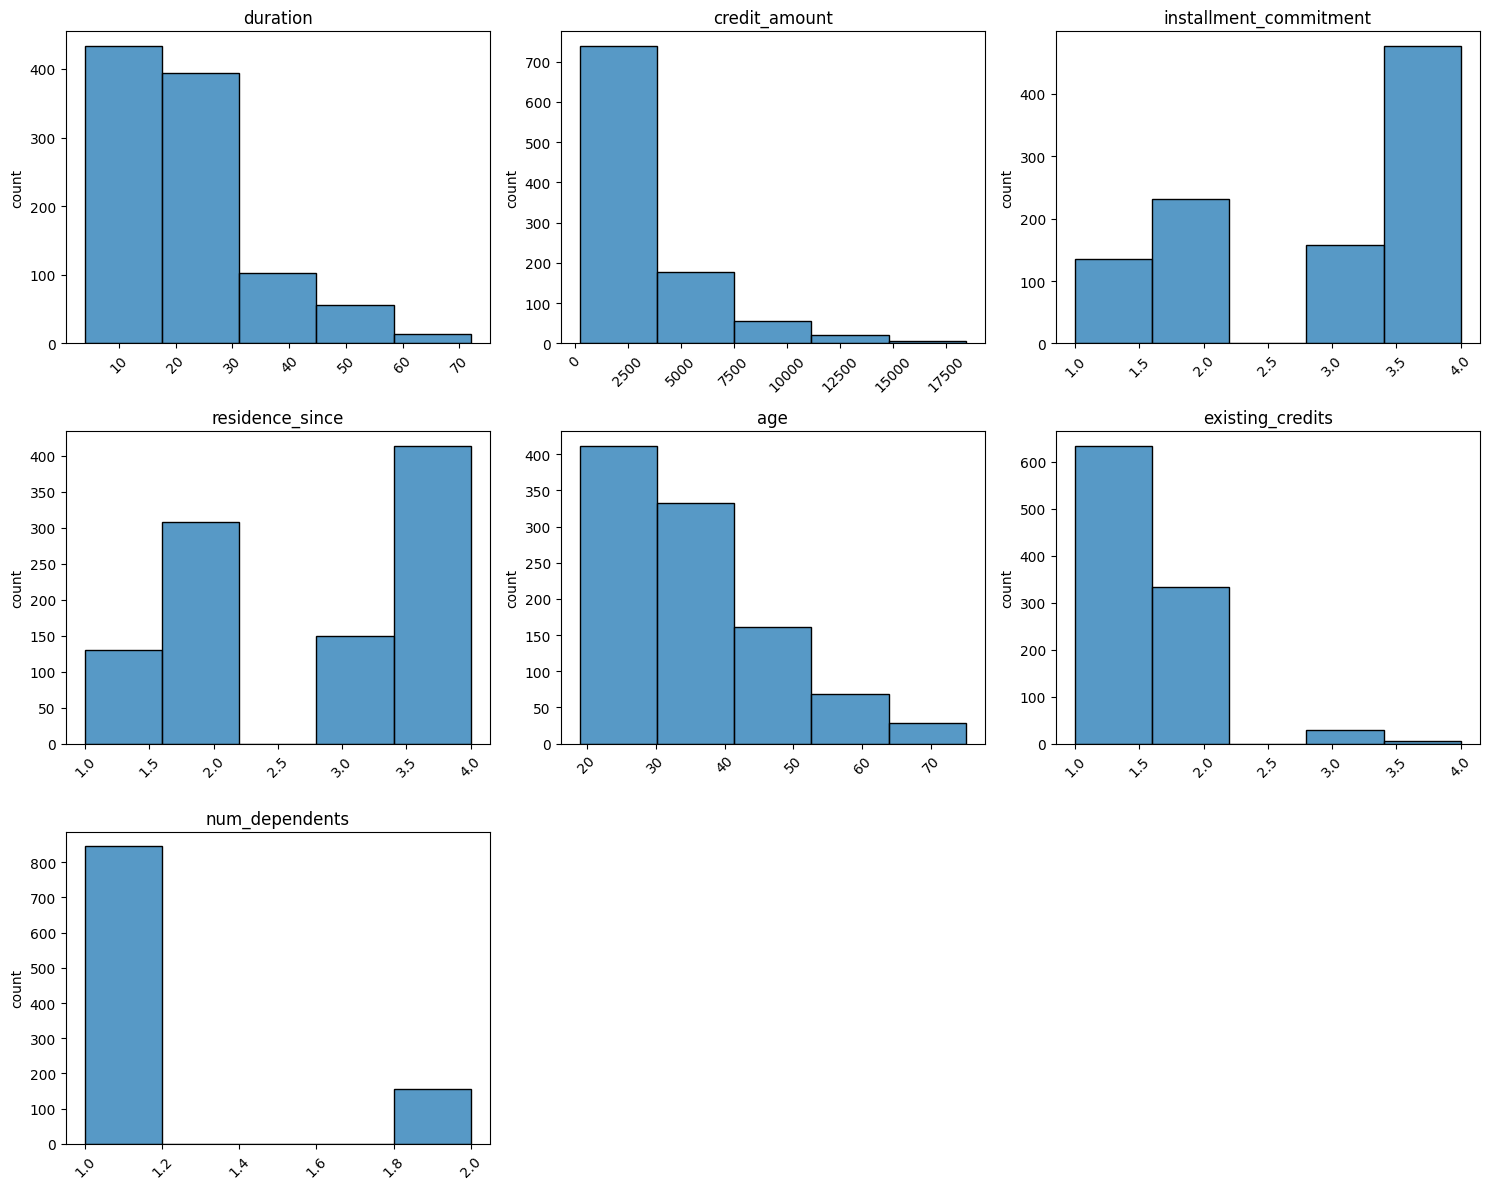

duration  credit_amount  installment_commitment  residence_since  \
count  1000.000000    1000.000000             1000.000000      1000.000000   
mean     20.903000    3271.258000                2.973000         2.845000   
std      12.058814    2822.736876                1.118715         1.103718   
min       4.000000     250.000000                1.000000         1.000000   
25%      12.000000    1365.500000                2.000000         2.000000   
50%      18.000000    2319.500000                3.000000         3.000000   
75%      24.000000    3972.250000                4.000000         4.000000   
max      72.000000   18424.000000                4.000000         4.000000   

               age  existing_credits  num_dependents  
count  1000.000000       1000.000000     1000.000000  
mean     35.546000          1.407000        1.155000  
std      11.375469          0.577654        0.362086  
min      19.000000          1.000000        1.000000  
25%      27.000000          1.000000        1.000000  
50%      33.000000          1.000000        1.000000  
75%      42.000000          2.000000        1.000000  
max      75.000000          4.000000        2.000000

In [14]:
histograms(q4_df, numeric)
q4_df[numeric].describe()

A maioria é quase categórica, valores numéricos inteiros. Exceção é o `credit_amount`.

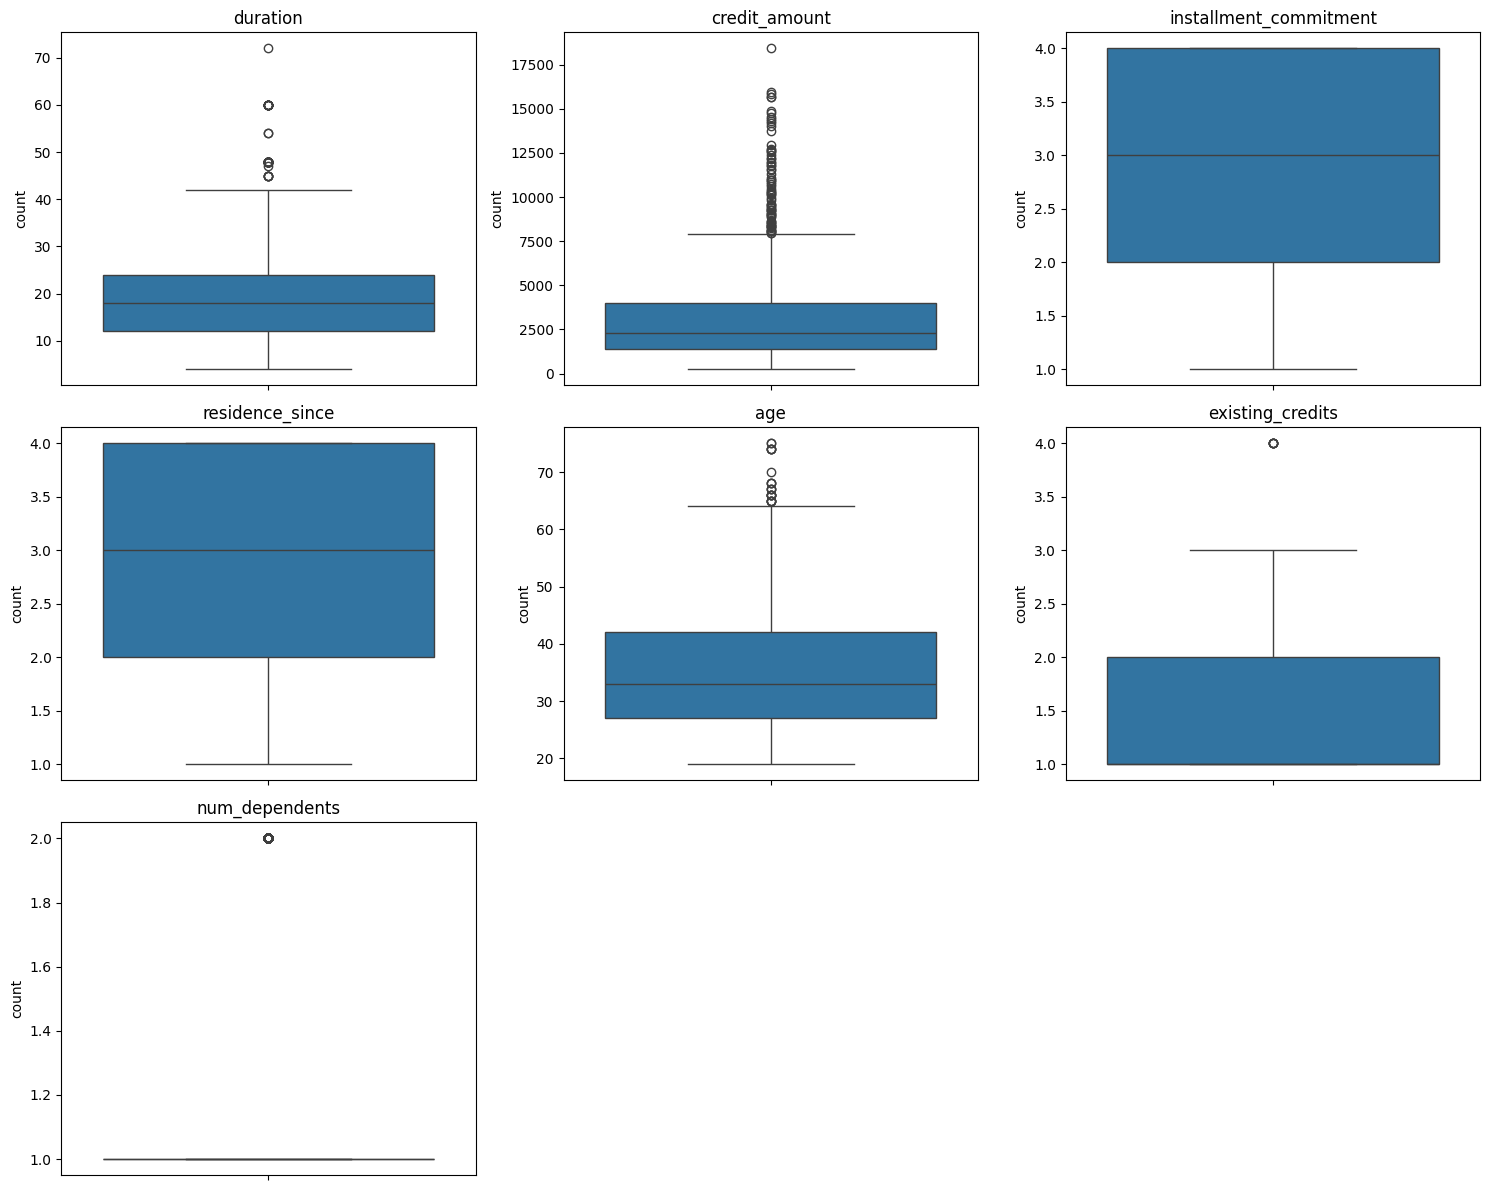

In [18]:
boxplots(q4_df, numeric)

Quase todas têm uma cauda. Vamos usar modelos não paramétricos porém, então isto não deve dar problemas.

#### Colunas categóricas

In [104]:
q4_df['checking_status']

0               <0
1         0<=X<200
2      no checking
3               <0
4               <0
          ...     
995    no checking
996             <0
997    no checking
998             <0
999       0<=X<200
Name: checking_status, Length: 1000, dtype: object

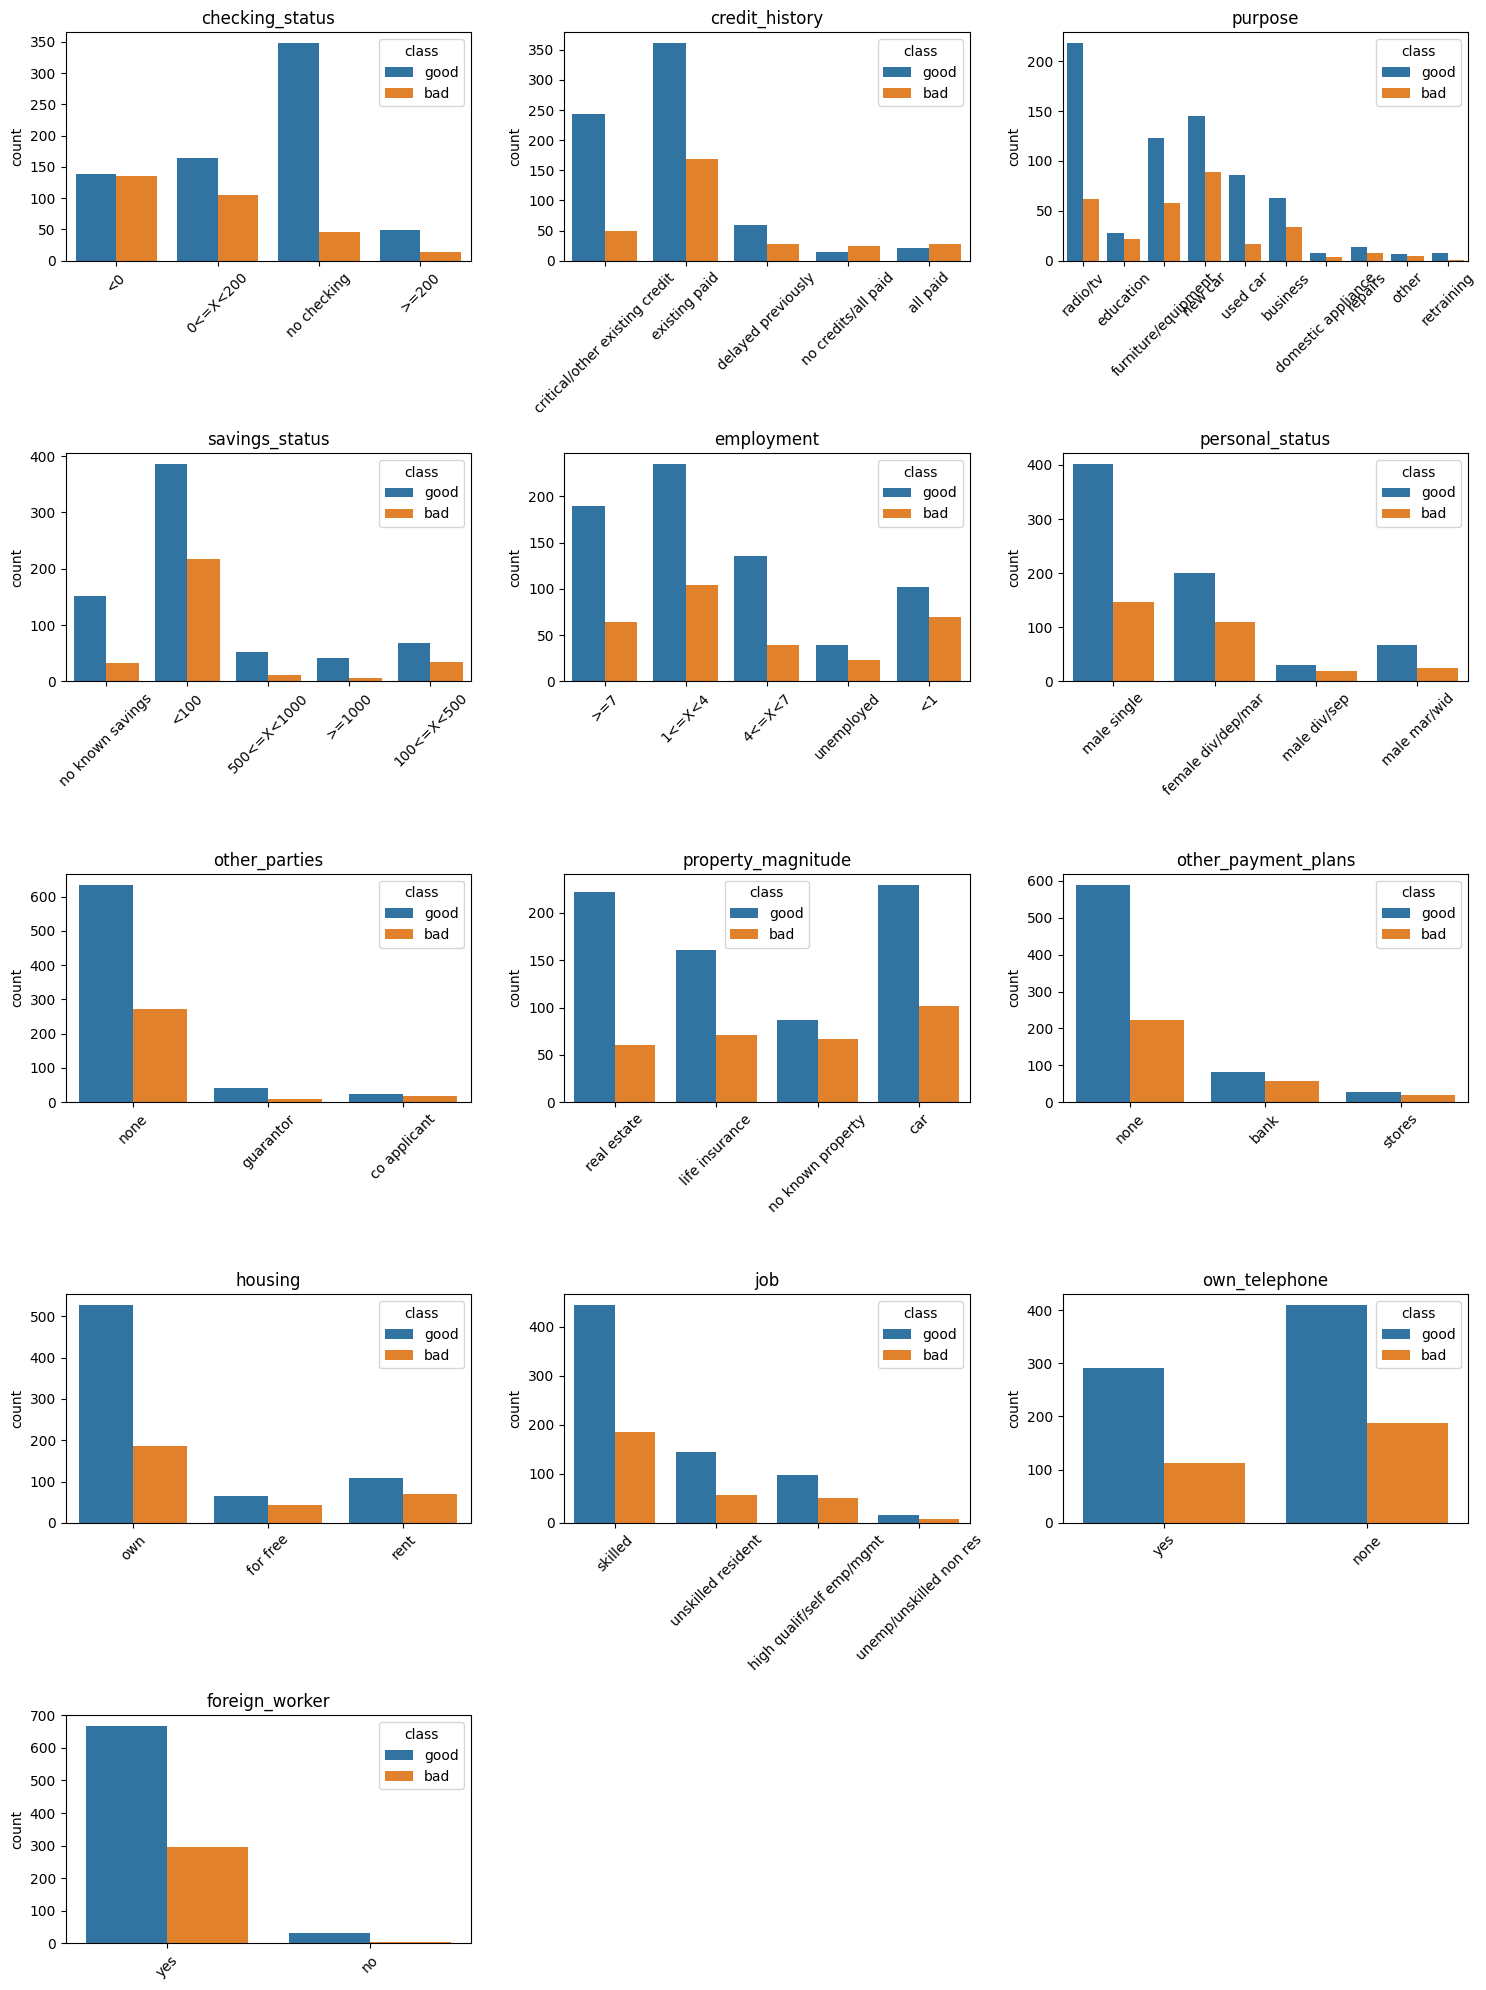

In [35]:
countplots(q4_df, categorical, hue='class')

Categorias bem balanceadas, nenhuma patologicamente desbalanceada, embora algumas bem viesadas (`foreign_worker`, `other_parties`).

NO geral, todas as categorias apresentam valores em ambas as classes. Bom sinal! Isso indica que são, no geral, relevantes.

#### Valor-alvo

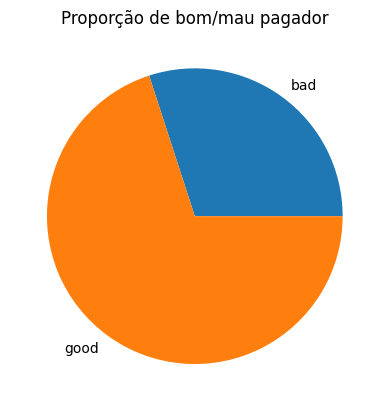

In [90]:
class_groupby = q4_df.groupby('class')
plt.pie(class_groupby.size(), labels=class_groupby.size().index, )
plt.title(label='Proporção de bom/mau pagador')
plt.show()

Diferença entre classes de saída não é tão grande: uma é quase 50% da outra. Balanceamento talvez não seja necessário.

### Definição e Seleção dos Modelos

Vamos testar três modelos: regressão logística, Random Forest e CatBoost. A ideia é comparar o resultado desses três modelos de categorias bem diferentes (regressão, bagging, boosting).

In [70]:
X = q4_df.drop(target, axis=1)
y = q4_df[target]

#### Regressão linear

Antes de mais nada, vamos procurar colinearidades. 

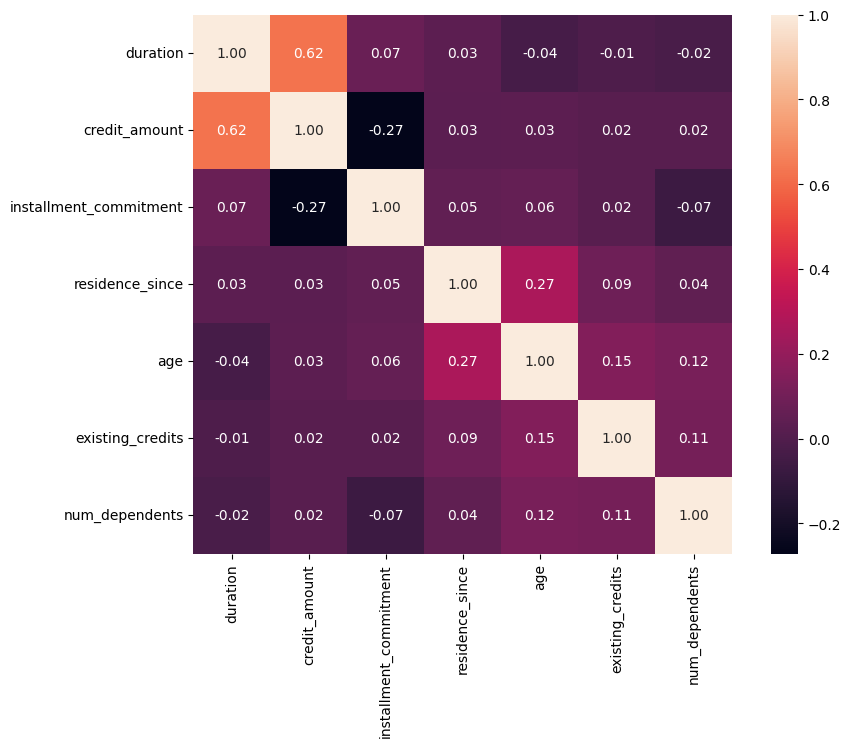

In [71]:
X_corr = X.corr(numeric_only=True)
plt.figure(figsize=(10, 7))
sns.heatmap(X_corr, annot=True, fmt=".2f", square=True)
plt.show()

Única correlação mais forte é entre `credit_amount`  e `duration`. Chequemos VIF:

In [83]:
X_num = sm.add_constant(X[numeric])


vif_df = pd.DataFrame({
    "feature": X_num.columns,
    "VIF": [variance_inflation_factor(X_num.values, i)
            for i in range(X_num.shape[1])]
}).sort_values(by='VIF', ascending=False)
vif_df

feature        VIF
0                   const  35.036815
2           credit_amount   1.994152
1                duration   1.857215
3  installment_commitment   1.227527
5                     age   1.121527
4         residence_since   1.082781
6        existing_credits   1.036226
7          num_dependents   1.030099

Nennum valor extremamente correlacionado. Excelente! Rodemos o modelo.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )

Acurácia : 0.795
Precisão : 0.825
Recall   : 0.901
F1-score : 0.861


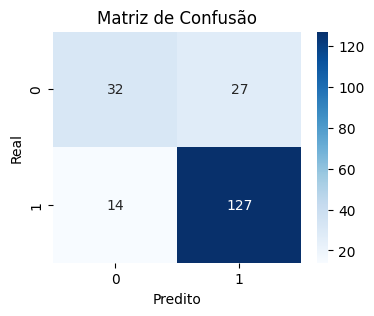

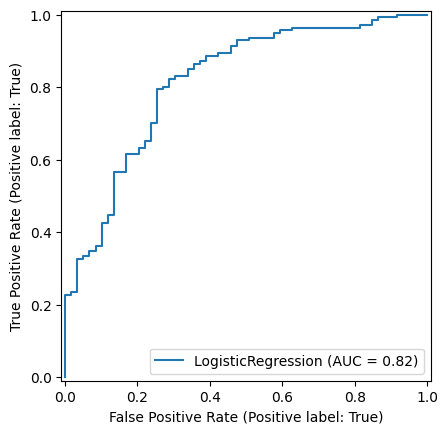

In [119]:
from sklearn.metrics import RocCurveDisplay

def prepare_lreg(X):
    return pd.get_dummies(
        sm.add_constant(X),
        columns=categorical,
        drop_first=True,
        dtype=int
    )

X_lreg_train = prepare_lreg(X_train)
y_train_vector = y_train['class'] == 'good'

lreg_model = LogisticRegression(max_iter=10000)
lreg_model.fit(X_lreg_train, y_train_vector)

X_lreg_test = prepare_lreg(X_test)

y_test_vector = y_test['class'] == 'good'
evaluate_model(lreg_model, X_lreg_test, y_test_vector)

RocCurveDisplay.from_estimator(lreg_model, X_lreg_test, y_test_vector)
plt.show()

Baixa acurácia, boa precisão, recall e F1. Mas precisamos de 1000 iterações para convergir. 

Seria um resultado bom em outros casos, mas queremos evitar os falsos positivos! O modelo, como feito agora, não é ideal.

#### Random Forest

Acurácia : 0.795
Precisão : 0.801
Recall   : 0.943
F1-score : 0.866


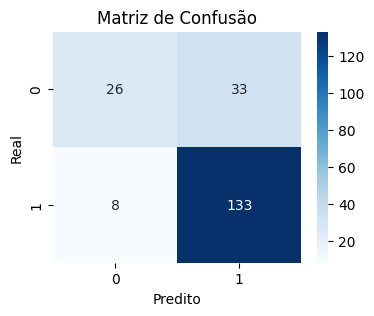

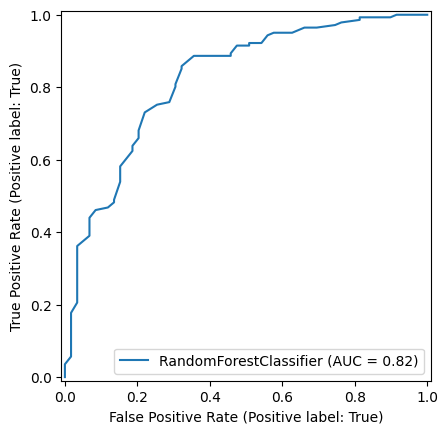

In [123]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

def prepare_rf(X):
    return pd.get_dummies(
        X,
        columns=categorical,
        drop_first=True,
        dtype=int
    )


X_rf_train = prepare_rf(X_train)

rf_model.fit(X_rf_train, y_train_vector)

X_rf_test = prepare_rf(X_test)
evaluate_model(rf_model, X_rf_test, y_test_vector)

RocCurveDisplay.from_estimator(rf_model, X_rf_test, y_test_vector)
plt.show()

Similar a regressão logística, bom recall e precisão, baixa acurácia. AUC-ROC muito promissor. Mas novamente, nosso caso de uso quer evitar falsos positivos para não tomar calote.

#### CatBoost

Uma coisa legal do CatBoost é que não precisamos codificar as categorias!

Acurácia : 0.765
Precisão : 0.801
Recall   : 0.887
F1-score : 0.842


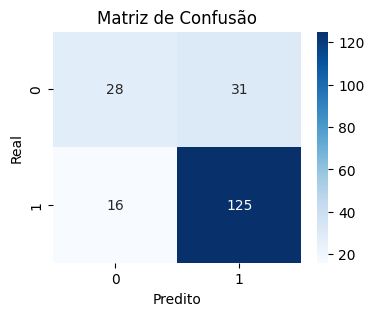

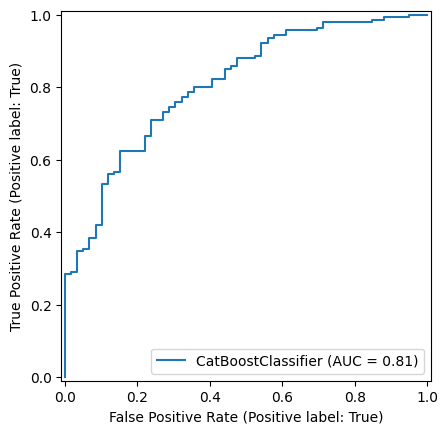

In [127]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    iterations=100, random_state=42, verbose=False
)

catboost_model.fit(X_train, y_train_vector, cat_features=categorical)

evaluate_model(catboost_model, X_test, y_test_vector)
RocCurveDisplay.from_estimator(catboost_model, X_test, y_test_vector)
plt.show()

Assim como os outros, valores semelhantes de acurácia, recall, precisão, F1, AUC-ROC. Aparentemente todos os modelos precisam de algum trabalho!

Um ponto que poderíamos ver seria balanceamento, mas não temos tempo hábil.

### Explicabilidade de Variáveis com SHAP value

#### Regressão linear

In [132]:
import shap

background = X_lreg_train.sample(100, random_state=42)
explainer = shap.KernelExplainer(lreg_model.predict, background)
shap_values = explainer.shap_values(X_lreg_test)

  0%|          | 0/200 [00:00<?, ?it/s]

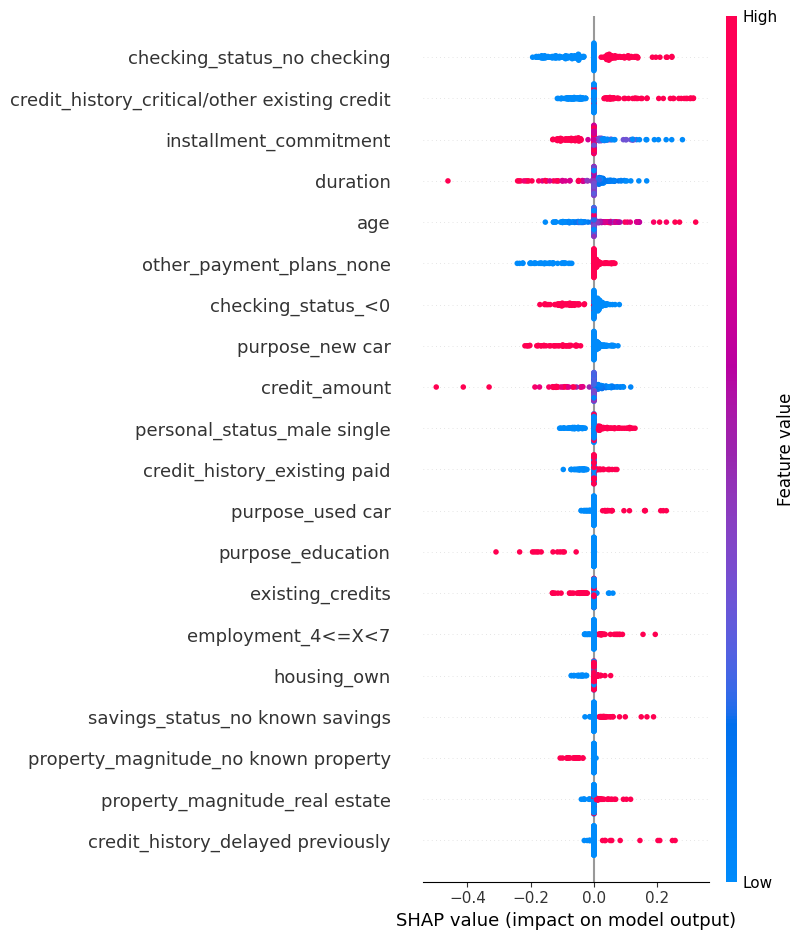

In [137]:
shap.summary_plot(shap_values, X_lreg_test.iloc[:200], feature_names=X_lreg_train.columns)

Valores que parecem afetar mais: não possuir conta-corrente. Intressante notar que, se o propósito é educação, a tendência é ser bom pagador. (Faz sentido, porque nos EUA não se pode declarar falência por empréstimo educacional).

#### Random forest

/tmp/ipykernel_863467/903673919.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_rf_train, feature_names=X_rf_train.columns)
/home/adam/lib/virtualenv/data-mining-experiments/lib/python3.12/site-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/home/adam/lib/virtualenv/data-mining-experiments/lib/python3.12/site-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and

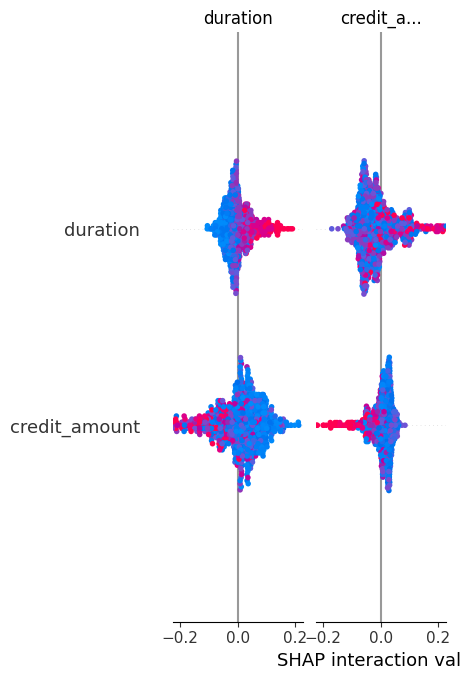

In [173]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_rf_train)
shap.summary_plot(shap_values, X_rf_train, feature_names=X_rf_train.columns)

⚠️⚠️⚠️ Ok, esse gráfico não fez nenhum sentido. Não tem como responder essa questão.

#### CatBoost

/tmp/ipykernel_863467/2029537006.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


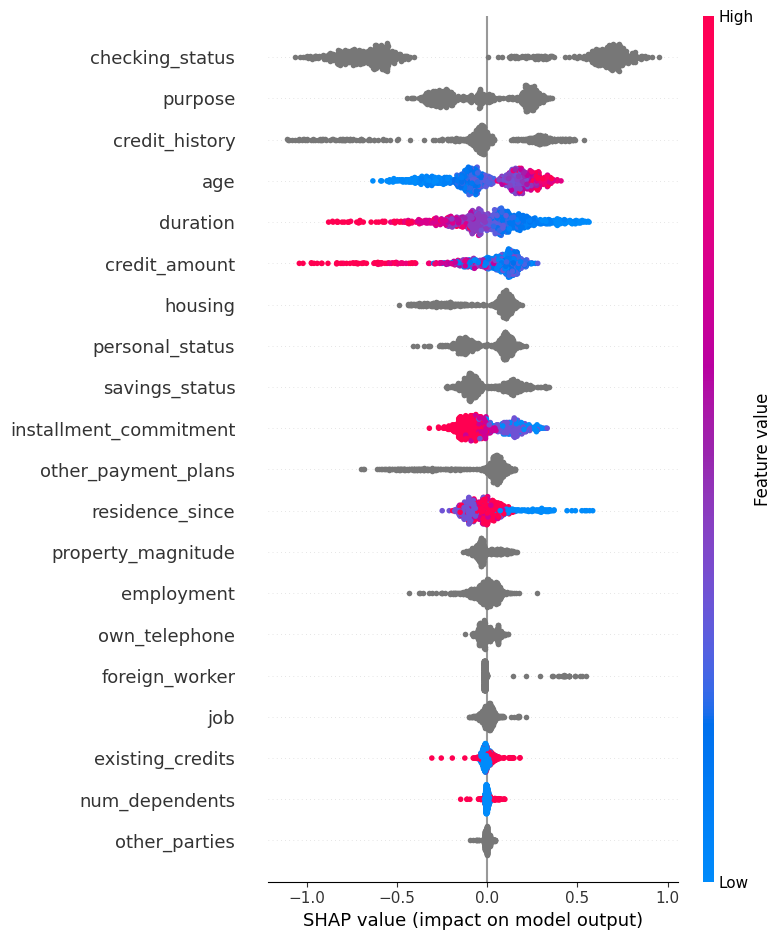

In [179]:
from catboost import Pool
pool = Pool(X_train, y_train_vector, cat_features=categorical)

explainer = shap.TreeExplainer(catboost_model)

shap_values = explainer.shap_values(pool)
shap.summary_plot(shap_values, X_train)

Interessante notar que `credit_amount`, `checking_status` and `credit_history` afetaram drasticamente, inclusive de maneira simétrica em alguns casos. Mais interessante ainda, `other_parties` não afeitou quase nada! Talvez compense dispensar esse dado na hora de empreśtimo.

### Análise não supervisionada

⚠️⚠️⚠️ Esta parte não foi executada.

### Tomada de decisão estratégica

Não faremos uma análise profunda por falta de tempo. Contudo, há algo interessante que mencionamos antes: fiadores, garantidores etc. aparentemente não afetam muito o caráter do pagador. Isso é algo que tende a restringir bastante o acesso ao crédito, então fica apenas essa ideia: talvez abandonar a prática?